# Import Packages

In [161]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import shap
import scikitplot as skplt
import math
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier



# Split Dataset to train and test set 

In [2]:
churn = pd.read_csv(r"C:\KU Leuven\Advanced Analytics\Assignment\data\train.csv")
pd.set_option("display.max_columns", None)

# Split to training set and test set
X = churn.drop("target", axis=1)
y = churn["target"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Missing Data 

In [3]:
print(train.isna().sum())



Gender                    0
Age                       0
Connect_Date              0
L_O_S                     0
Dropped_Calls             0
tariff                    0
Handset                   0
Peak_calls_Sum            0
Peak_mins_Sum             0
OffPeak_calls_Sum         0
OffPeak_mins_Sum          0
Weekend_calls_Sum         0
Weekend_mins_Sum          0
International_mins_Sum    0
Nat_call_cost_Sum         0
AvePeak                   0
AveOffPeak                0
AveWeekend                0
National_calls            0
National mins             0
AveNational               0
All_calls_mins            0
Dropped_calls_ratio       3
Usage_Band                3
Mins_charge               0
call_cost_per_min         3
actual call cost          0
Total_call_cost           0
Total_Cost                0
Tariff_OK                 0
average cost min          0
Peak ratio                0
OffPeak ratio             0
Weekend ratio             0
Nat-InterNat Ratio        0
high Dropped calls  

In [4]:
train.shape

(3530, 39)

In [5]:
train['Dropped_calls_ratio'].fillna(train['Dropped_calls_ratio'].median(), inplace=True)
train['Usage_Band'].fillna(train['Usage_Band'].mode().iloc[0], inplace=True)  # mode() returns a Series, so you need to access the first element with iloc[0]
train['call_cost_per_min'].fillna(train['call_cost_per_min'].median(), inplace=True)

C:\Users\Johnn\AppData\Local\Temp\ipykernel_21708\3019323106.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Dropped_calls_ratio'].fillna(train['Dropped_calls_ratio'].median(), inplace=True)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_21708\3019323106.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

# Visualize Categorical Variables and Target 

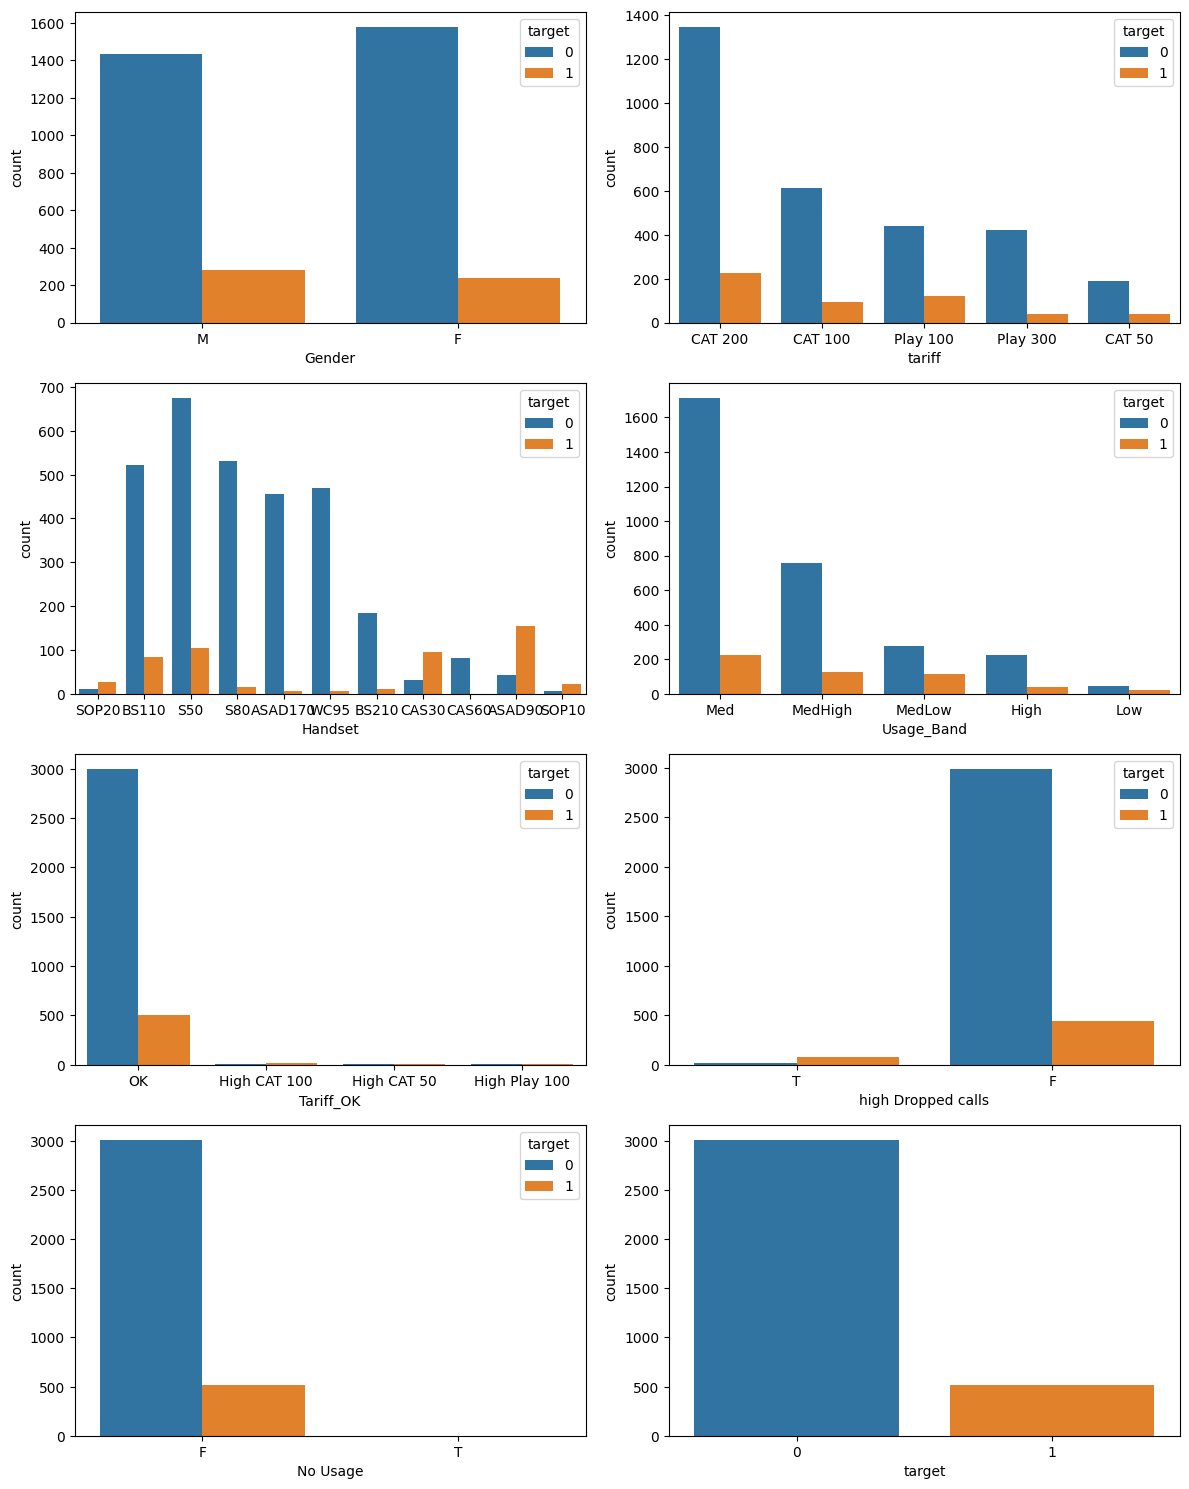

In [6]:
train_categorical = train.select_dtypes(include=["object","int64"])

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 15))

sns.countplot(data=train_categorical, x="Gender", hue="target", ax=axes[0, 0])
sns.countplot(data=train_categorical, x="tariff", hue="target", ax=axes[0, 1])
sns.countplot(data=train_categorical, x="Handset", hue="target", ax=axes[1, 0])
sns.countplot(data=train_categorical, x="Usage_Band", hue="target", ax=axes[1, 1])
sns.countplot(data=train_categorical, x="Tariff_OK", hue="target", ax=axes[2, 0])
sns.countplot(data=train_categorical, x="high Dropped calls", hue="target", ax=axes[2, 1])
sns.countplot(data=train_categorical, x="No Usage", hue="target", ax=axes[3, 0])
sns.countplot(data=train_categorical, x="target", ax=axes[3, 1])

# If you have an extra subplot, you can leave it empty or remove it
# axes[3, 1].axis('off')

plt.tight_layout()
plt.show()

# Preprocessing

## Binarize, Drop and Tranform 

In [7]:
# Binarize the High Dropped calls feature 

train["Connect_Date"] = pd.to_datetime(train["Connect_Date"])

from sklearn.preprocessing import LabelEncoder
# Set up the LabelEncoder object
enc = LabelEncoder()

# Apply the encoding to the "Accessible" column
train["High_Dropped_calls"] = enc.fit_transform(train["high Dropped calls"])

# Compare the two columns
#print(train[["High_Dropped_calls", "high Dropped calls"]].head())

train.drop("high Dropped calls", axis=1, inplace=True)

train.drop("No Usage", axis=1, inplace=True)

enc_2 = LabelEncoder()

# Apply the encoding to the "Accessible" column
train["Gender"] = enc_2.fit_transform(train["Gender"])

   # Create a list of categories
tariff_OK_categories = ["OK", "Other"]

# Create short_flights
okay = "OK"

other = "CAT|Play"
# Create long_flights
#handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (train["Tariff_OK"].str.contains(okay)),
    (train["Tariff_OK"].str.contains(other))
]

# Apply the conditions list to the flight_categories
train["Tariff_OK_cat"] = np.select(conditions, 
                                        tariff_OK_categories)

train.drop("Tariff_OK", axis=1, inplace=True)

train["Tariff_OK_cat"] = np.where(train["Tariff_OK_cat"]=="OK", 1,0)

# Create salary labels
drop_calls_labels = ["0-11", "12-15"]

# Create the salary ranges list
drop_calls_ranges = [-0.1, 12, train["Dropped_Calls"].max()]

# Create salary_level
train["binned_drop_calls"] = pd.cut(train["Dropped_Calls"],
                                  bins=drop_calls_ranges,
                                  labels=drop_calls_labels)

train["above_11_dropped_calls"] = np.where(train["binned_drop_calls"]=="12-15",1,0)

train.drop("binned_drop_calls",axis=1,inplace=True)


C:\Users\Johnn\AppData\Local\Temp\ipykernel_21708\1898938406.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train["Connect_Date"] = pd.to_datetime(train["Connect_Date"])


## Weight of Evidence Transformation

In [8]:
# WOE to group the tariff, Handset and Usage Band and replace the feature categorical values with the WOE values, thus turn the categorical variables into numerical

def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Bin Values': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & 
                    (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & 
                    (dataset[target] == 1)].count()[feature]
        }) 
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    dset = dset.sort_values(by='WoE')
    return dset, iv

In [9]:
tuple_woe_handset = calculate_woe_iv(train, "Handset", "target")
handset_woe = tuple_woe_handset[0]
handset_iv = tuple_woe_handset[1]
#print(handset_woe, handset_iv)

train_by_handset = pd.pivot_table(train, index="target", columns="Handset", aggfunc="size", fill_value=0)
odds = train_by_handset.iloc[0] / train_by_handset.iloc[1]
train_by_handset.loc["Odds"]= train_by_handset.iloc[0] / train_by_handset.iloc[1]

   # Create a list of categories
handset_categories = ["Handset_safe", "Handset_neutral", "Handset_risky"]

# Create short_flights
handset_safe = "BS210|S80|ASAD170|WC95|CAS60"

# Create medium_flights
handset_neutral = "S50|BS110"

# Create long_flights
handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (train["Handset"].str.contains(handset_safe)),
    (train["Handset"].str.contains(handset_neutral)),
    (train["Handset"].str.contains(handset_risky))
]

# Apply the conditions list to the flight_categories
train["Handset_Category"] = np.select(conditions, 
                                        handset_categories)

# Plot the counts of each category
# sns.countplot(data=train, x="Handset_Category")
# plt.show()

tuple_woe_handset_cat = calculate_woe_iv(train, "Handset_Category", "target")
handset_cat_woe = tuple_woe_handset_cat[0]
handset_cat_iv = tuple_woe_handset_cat[1]
#print(handset_cat_woe, handset_cat_iv)

handset_to_woe_dict = dict(zip(handset_cat_woe['Bin Values'], handset_cat_woe['WoE']))
train['woe_handset_cat'] = train['Handset_Category'].map(handset_to_woe_dict)

In [10]:
tuple_woe_tariff = calculate_woe_iv(train, "tariff", "target")
tariff_woe = tuple_woe_tariff[0]
tariff_iv = tuple_woe_tariff[1]
#print(tariff_woe, tariff_iv)

train_by_tariff = pd.pivot_table(train, index="target", columns="tariff", aggfunc="size", fill_value=0)
odds = train_by_tariff.iloc[0] / train_by_tariff.iloc[1]
train_by_tariff.loc["Odds"]= train_by_tariff.iloc[0] / train_by_tariff.iloc[1]

   # Create a list of categories
tariff_categories = ["tariff_play_300", "tariff_CAT", "tariff_play_100"]

# Create short_flights
tariff_less_risky = "Play 300"

tariff_neutral = "CAT 200|CAT 50|CAT 100"

# Create medium_flights
tariff_risky = "Play 100"

# Create long_flights
#handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (train["tariff"].str.contains(tariff_less_risky)),
    (train["tariff"].str.contains(tariff_neutral)),
    (train["tariff"].str.contains(tariff_risky))
]

# Apply the conditions list to the flight_categories
train["Tariff_category"] = np.select(conditions, 
                                        tariff_categories)

# Plot the counts of each category
# sns.countplot(data=train, x="Tariff_category")
# plt.show()

tuple_woe_tariff_cat = calculate_woe_iv(train, "Tariff_category", "target")
tariff_cat_woe = tuple_woe_tariff_cat[0]
tariff_cat_iv = tuple_woe_tariff_cat[1]
#print(tariff_cat_woe, tariff_cat_iv)

tariff_to_woe_dict = dict(zip(tariff_cat_woe['Bin Values'], tariff_cat_woe['WoE']))
train['woe_tariff_cat'] = train['Tariff_category'].map(tariff_to_woe_dict)


In [11]:
tuple_woe_usage_band = calculate_woe_iv(train, "Usage_Band", "target")
usage_band_woe = tuple_woe_usage_band[0]
usage_band_iv = tuple_woe_usage_band[1]
#print(usage_band_woe, usage_band_iv)

train_by_usage = pd.pivot_table(train, index="target", columns="Usage_Band", aggfunc="size", fill_value=0)
odds = train_by_usage.iloc[0] / train_by_usage.iloc[1]
train_by_usage.loc["Odds"]= train_by_usage.iloc[0] / train_by_usage.iloc[1]
#train_by_usage

   # Create a list of categories
usage_categories = ["usage_low", "usage_med", "usage_high"]

# Create short_flights
usage_low = "Low"

usage_med = r"\bMed\b"

usage_high = "High"




# Create long_flights
#handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (train["Usage_Band"].str.contains(usage_low)),
    (train["Usage_Band"].str.contains(usage_med)),
    (train["Usage_Band"].str.contains(usage_high))
]

# Apply the conditions list to the flight_categories
train["Usage_category"] = np.select(conditions, 
                                        usage_categories)

# Plot the counts of each category
# sns.countplot(data=train, x="Usage_category")
# plt.show()

tuple_woe_usage_cat = calculate_woe_iv(train, "Usage_category", "target")
usage_cat_woe = tuple_woe_usage_cat[0]
usage_cat_iv = tuple_woe_usage_cat[1]
#print(usage_cat_woe, usage_cat_iv)

usage_to_woe_dict = dict(zip(usage_cat_woe['Bin Values'], usage_cat_woe['WoE']))
train['woe_usage_cat'] = train['Usage_category'].map(usage_to_woe_dict)

In [12]:
train.drop(["tariff","Handset","Usage_Band","Handset_Category","Tariff_category","Usage_category"],axis=1,inplace=True)

In [13]:
train.head()

Gender   Age Connect_Date      L_O_S  Dropped_Calls  Peak_calls_Sum  \
1608       1  12.0   1997-12-25  34.066667           12.0           351.0   
3024       1  21.0   1997-06-19  40.366667            2.0           277.0   
2902       1  48.0   1998-12-01  33.466667            1.0           500.0   
2691       0  36.0   1997-06-07  39.800000            2.0            29.0   
1617       0  24.0   1997-01-31  45.000000            1.0           397.0   

      Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
1608     590.400000              229.0        415.799999                9.0   
3024     462.600000               40.0        271.499998                9.0   
2902     805.200001               11.0         23.399999                8.0   
2691     121.200000              195.0        359.700000                2.0   
1617     728.400000               33.0        225.300000               33.0   

      Weekend_mins_Sum  International_mins_Sum  Nat_call_cost_Sum   AvePeak  \
1608         95.400000               88.377455           0.000000  1.682051   
3024         17.400000              135.845889          16.900868  1.670036   
2902         16.200001              106.827354          35.572499  1.610400   
2691         36.500000              158.991666           0.000000  4.179310   
1617        126.000000              270.789900           0.000000  1.834761   

      AveOffPeak  AveWeekend  National_calls  National mins  AveNational  \
1608    1.815721   10.600000           589.0    1101.599999     1.870289   
3024    6.787500    1.933333           326.0     751.499998     2.305215   
2902    2.127273    2.025000           519.0     844.800001     1.627746   
2691    1.844615   18.250000           226.0     517.400000     2.289381   
1617    6.827273    3.818182           463.0    1079.700000     2.331965   

      All_calls_mins  Dropped_calls_ratio  Mins_charge  call_cost_per_min  \
1608     1189.977454             0.010187   -98.400001           7.679739   
3024      887.345887             0.003067   151.499998          11.155689   
2902      951.627355             0.000963   244.800001          14.531250   
2691      676.391666             0.004425   -82.600000           9.684963   
1617     1350.489900             0.001080  -120.300000           8.373159   

      actual call cost  Total_call_cost  Total_Cost  average cost min  \
1608          0.000000        26.513236  176.513237          0.148333   
3024         16.900868        57.654635  162.654635          0.183305   
2902         35.572500        67.620706  172.620706          0.181395   
2691          0.000000        63.596666  123.536666          0.182641   
1617          0.000000        81.236970  231.236970          0.171225   

      Peak ratio  OffPeak ratio  Weekend ratio  Nat-InterNat Ratio       id  \
1608    0.535948       0.377451       0.086601            0.080226  K404940   
3024    0.615569       0.361277       0.023154            0.180766  K288220   
2902    0.953125       0.027699       0.019176            0.126453  K282860   
2691    0.234248       0.695207       0.070545            0.307290  K268330   
1617    0.674632       0.208669       0.116699            0.250801  K179730   

      target  High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  \
1608       1                   1              1                       0   
3024       0                   0              1                       0   
2902       0                   0              1                       0   
2691       0                   0              1                       0   
1617       0                   0              1                       0   

      woe_handset_cat  woe_tariff_cat  woe_usage_cat  
1608        -2.954247        0.027035       0.289711  
3024         0.108214        0.027035       0.289711  
2902         0.108214        0.027035       0.289711  
2691         2.114110       -0.448237       0.289711  
1617         2.114110        0.02

# Outliers

In [14]:
# Function to detect outliers 
filtered_columns = train.select_dtypes(include=["int","float"]).columns[~train.select_dtypes(include=["int","float"]).columns.str.contains("^woe")]

filtered_columns = filtered_columns.drop(['target','High_Dropped_calls','Tariff_OK_cat','Gender'])

# For each column calculate median and iqr and use them to calculate robust score for z value. 
# Return  number of outliers per feature, which are only values that have z > 3 

def robust_outlier_detection(dataset, columns):
    outliers = {}
    for feature_name in columns:
       median = np.median(dataset[feature_name])
       q75, q25 = np.percentile(dataset[feature_name], [75 ,25])
       iqr = q75-q25
       robust_z = (dataset[feature_name] - median) / iqr
       mask = abs(robust_z) > 3 
       outliers[feature_name] = sum(mask)
    return outliers
       
#filtered_columns = train.select_dtypes(include=["int","float"]).columns[~train.select_dtypes(include=["int","float"]).columns.str.contains("^woe")]


def truncate_outliers(dataset,columns):
    for feature_name in columns:
       median = np.median(dataset[feature_name])
       q75, q25 = np.percentile(dataset[feature_name], [75 ,25])
       iqr = q75-q25
       k = 3*iqr + median
       dataset[feature_name] = np.where((abs((dataset[feature_name]  - median) / iqr)) > 3, k, dataset[feature_name] )

c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


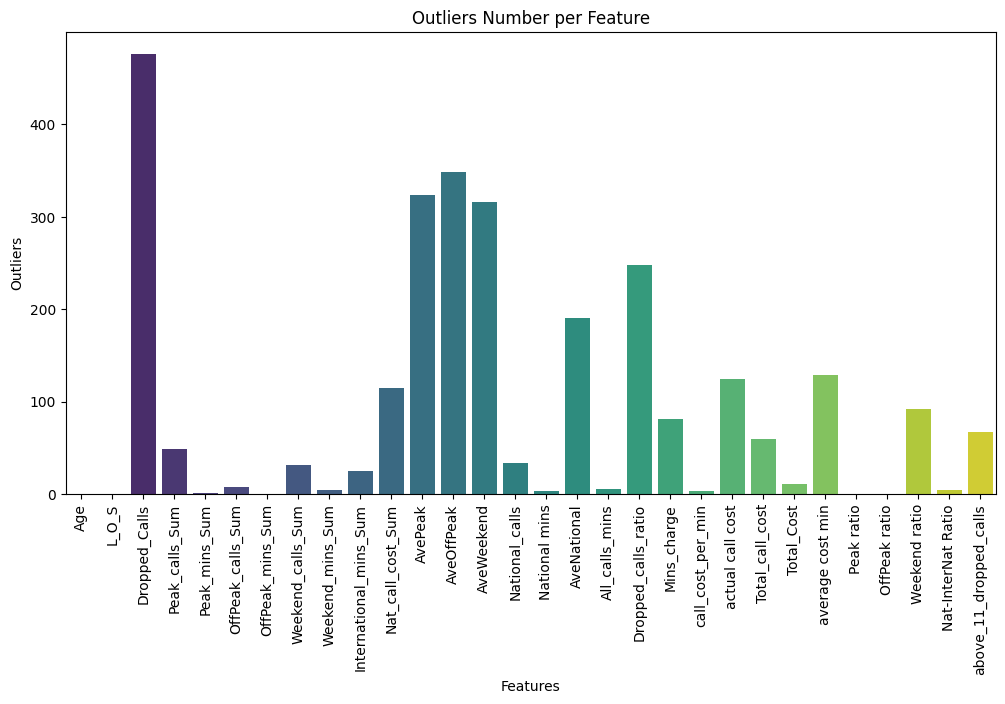

In [15]:
outlier_dict = robust_outlier_detection(train, filtered_columns)

keys = list(outlier_dict.keys())
values = list(outlier_dict.values())

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=keys, y=values, palette='viridis')
plt.xlabel('Features')
plt.ylabel('Outliers')
plt.title('Outliers Number per Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


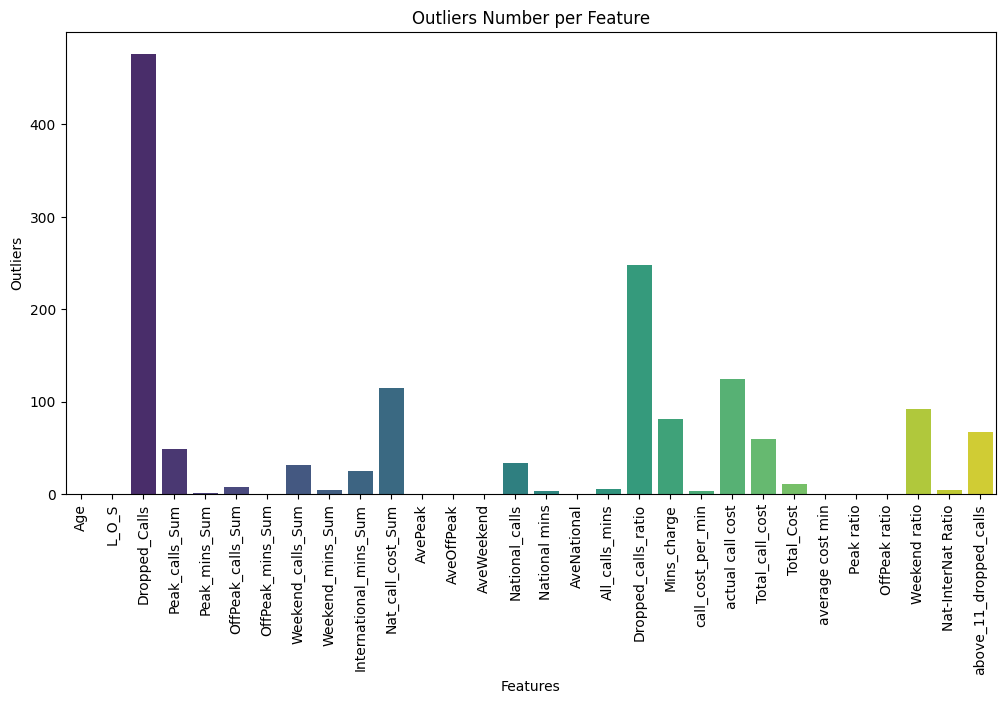

In [16]:
filtered_columns_trunct = list(filtered_columns)
filtered_columns_trunct = filtered_columns_trunct[11:14]  + [filtered_columns_trunct[16]] + [filtered_columns_trunct[24]] 

truncate_outliers(train, filtered_columns_trunct)

outlier_dict = robust_outlier_detection(train,filtered_columns)

keys = list(outlier_dict.keys())
values = list(outlier_dict.values())

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=keys, y=values, palette='viridis')
plt.xlabel('Features')
plt.ylabel('Outliers')
plt.title('Outliers Number per Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Adapt the Validation set
- Impute missing values using the median and mode used in the training set
- Binarize, Drop and Transform the same variables
- Replace Categorical values with the Weight of Evidence values that were used in the training set
- Remove Outliers based on the robust z values that were used in the training set 


## Impute missing values using the mode and median derived from the training set

In [17]:
test['Dropped_calls_ratio'].fillna(X_train['Dropped_calls_ratio'].median(), inplace=True)
test['Usage_Band'].fillna(X_train['Usage_Band'].mode().iloc[0], inplace=True)  # mode() returns a Series, so you need to access the first element with iloc[0]
test['call_cost_per_min'].fillna(X_train['call_cost_per_min'].median(), inplace=True)

C:\Users\Johnn\AppData\Local\Temp\ipykernel_21708\2880926319.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Dropped_calls_ratio'].fillna(X_train['Dropped_calls_ratio'].median(), inplace=True)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_21708\2880926319.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

## Remove Outliers 

c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


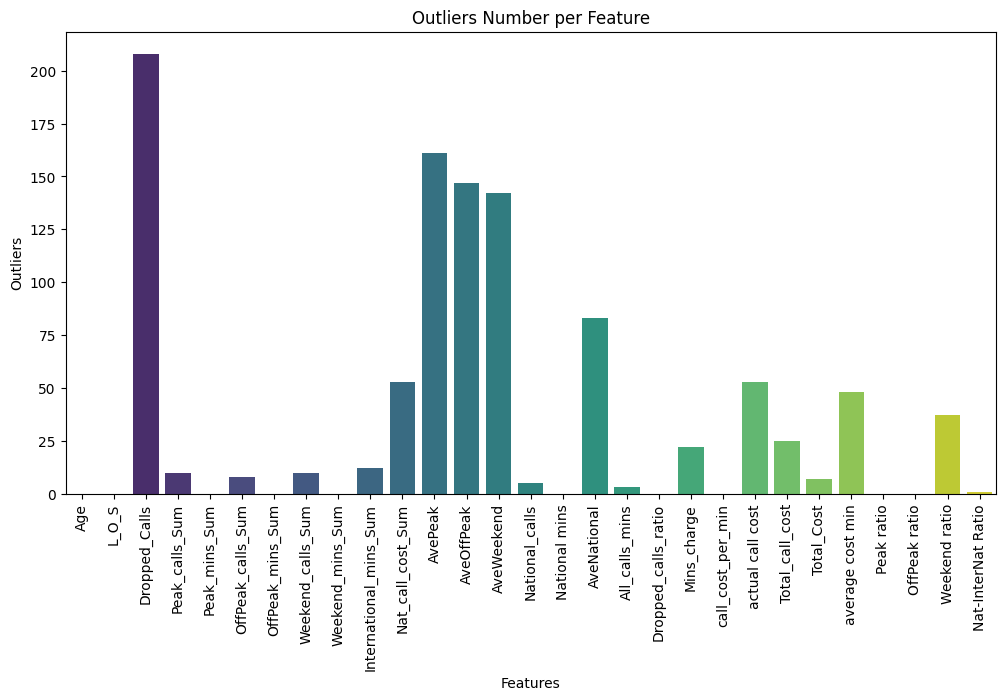

In [18]:
def robust_outlier_detection_test(dataset, columns):
    outliers = {}
    for feature_name in columns:
       median = np.median(X_train[feature_name])
       q75, q25 = np.percentile(X_train[feature_name], [75 ,25])
       iqr = q75-q25
       robust_z = (dataset[feature_name] - median) / iqr
       mask = abs(robust_z) > 3 
       outliers[feature_name] = sum(mask)
    return outliers

def truncate_outliers_test(dataset,columns):
    for feature_name in columns:
       median = np.median(X_train[feature_name])
       q75, q25 = np.percentile(X_train[feature_name], [75 ,25])
       iqr = q75-q25
       k = 3*iqr + median
       dataset[feature_name] = np.where((abs((dataset[feature_name]  - median) / iqr)) > 3, k, dataset[feature_name] )

filtered_columns_test = test.select_dtypes(include=["int","float"]).columns

filtered_columns_test = filtered_columns_test.drop('target')

outlier_dict_test = robust_outlier_detection_test(test,filtered_columns_test)

keys = list(outlier_dict_test.keys())
values = list(outlier_dict_test.values())

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=keys, y=values, palette='viridis')
plt.xlabel('Features')
plt.ylabel('Outliers')
plt.title('Outliers Number per Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


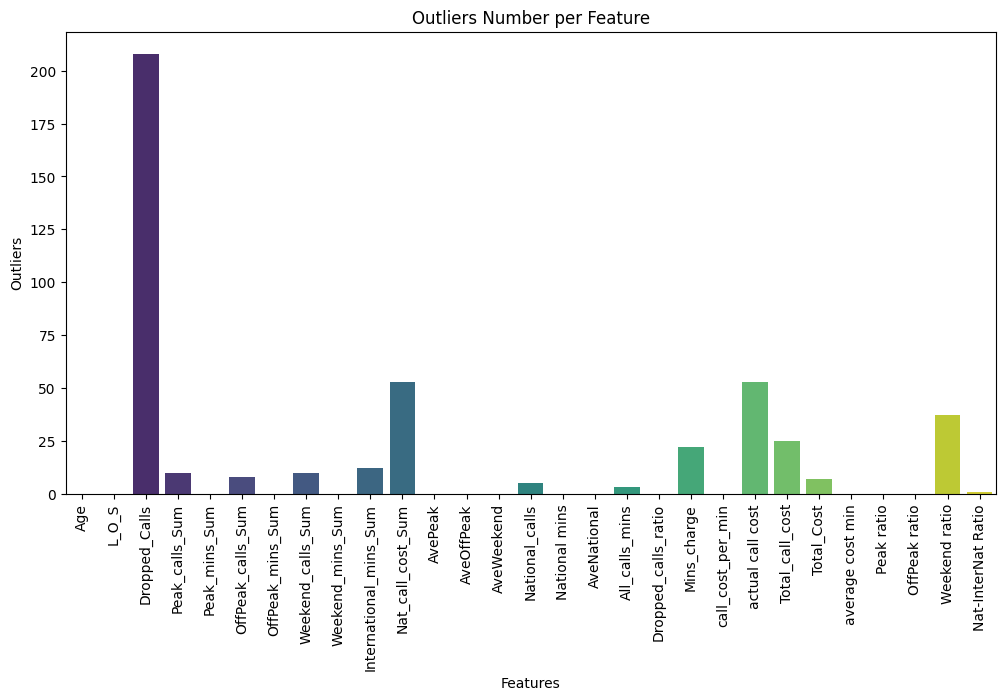

In [19]:
filtered_columns_trunct_test = list(filtered_columns_test)
#filtered_columns_trunct_test
filtered_columns_trunct_test = filtered_columns_trunct_test[11:14]  + [filtered_columns_trunct_test[16]] + [filtered_columns_trunct_test[24]] 

truncate_outliers_test(test,filtered_columns_trunct_test)

outlier_dict_test_2 = robust_outlier_detection_test(test, filtered_columns_test)

keys = list(outlier_dict_test_2.keys())
values = list(outlier_dict_test_2.values())

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=keys, y=values, palette='viridis')
plt.xlabel('Features')
plt.ylabel('Outliers')
plt.title('Outliers Number per Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

## Binarize, Drop and Transform

In [20]:
# Binarize the High Dropped calls feature 


from sklearn.preprocessing import LabelEncoder
# Set up the LabelEncoder object
enc = LabelEncoder()

# Apply the encoding to the "Accessible" column
test["High_Dropped_calls"] = enc.fit_transform(test["high Dropped calls"])

# Compare the two columns
#print(train[["High_Dropped_calls", "high Dropped calls"]].head())

test.drop("high Dropped calls", axis=1, inplace=True)

# The variables connect_month, connect_year, No Usage, Tariff_OK, and Gender are DROPPED from the training set

test.drop("No Usage", axis=1, inplace=True)

enc_2 = LabelEncoder()

# Apply the encoding to the "Accessible" column
test["Gender"] = enc_2.fit_transform(test["Gender"])

   # Create a list of categories
tariff_OK_categories = ["OK", "Other"]

# Create short_flights
okay = "OK"

other = "CAT|Play"
# Create long_flights
#handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (test["Tariff_OK"].str.contains(okay)),
    (test["Tariff_OK"].str.contains(other))
]

# Apply the conditions list to the flight_categories
test["Tariff_OK_cat"] = np.select(conditions, 
                                        tariff_OK_categories)


test["Tariff_OK_cat"] = np.where(test["Tariff_OK_cat"]=="OK", 1,0)

test["Connect_Date"] = pd.to_datetime(test["Connect_Date"])

# Create salary labels
drop_calls_labels = ["0-11", "12-15"]

# Create the salary ranges list
drop_calls_ranges = [-0.1, 12, train["Dropped_Calls"].max()]

# Create salary_level
test["binned_drop_calls"] = pd.cut(test["Dropped_Calls"],
                                  bins=drop_calls_ranges,
                                  labels=drop_calls_labels)

test["above_11_dropped_calls"] = np.where(test["binned_drop_calls"]=="12-15",1,0)

test.drop("binned_drop_calls",axis=1,inplace=True)


C:\Users\Johnn\AppData\Local\Temp\ipykernel_21708\2794519713.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test["Connect_Date"] = pd.to_datetime(test["Connect_Date"])


## Transform the Weight of Evidence Values 

In [21]:
   # Create a list of categories
handset_categories = ["Handset_safe", "Handset_neutral", "Handset_risky"]

# Create short_flights
handset_safe = "BS210|S80|ASAD170|WC95|CAS60"

# Create medium_flights
handset_neutral = "S50|BS110"

# Create long_flights
handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (test["Handset"].str.contains(handset_safe)),
    (test["Handset"].str.contains(handset_neutral)),
    (test["Handset"].str.contains(handset_risky))
]

# Apply the conditions list to the flight_categories
test["Handset_Category"] = np.select(conditions, 
                                        handset_categories)


handset_to_woe_dict = dict(zip(handset_cat_woe['Bin Values'], handset_cat_woe['WoE']))
test['woe_handset_cat'] = test['Handset_Category'].map(handset_to_woe_dict)

   # Create a list of categories
tariff_categories = ["tariff_play_300", "tariff_CAT", "tariff_play_100"]

# Create short_flights
tariff_less_risky = "Play 300"

tariff_neutral = "CAT 200|CAT 50|CAT 100"

# Create medium_flights
tariff_risky = "Play 100"

# Create long_flights
#handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (test["tariff"].str.contains(tariff_less_risky)),
    (test["tariff"].str.contains(tariff_neutral)),
    (test["tariff"].str.contains(tariff_risky))
]

# Apply the conditions list to the flight_categories
test["Tariff_category"] = np.select(conditions, 
                                        tariff_categories)

tariff_to_woe_dict = dict(zip(tariff_cat_woe['Bin Values'], tariff_cat_woe['WoE']))
test['woe_tariff_cat'] = test['Tariff_category'].map(tariff_to_woe_dict)

   # Create a list of categories
usage_categories = ["usage_low", "usage_med", "usage_high"]

# Create short_flights
usage_low = "Low"

usage_med = r"\bMed\b"

usage_high = "High"




# Create long_flights
#handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (test["Usage_Band"].str.contains(usage_low)),
    (test["Usage_Band"].str.contains(usage_med)),
    (test["Usage_Band"].str.contains(usage_high))
]

# Apply the conditions list to the flight_categories
test["Usage_category"] = np.select(conditions, 
                                        usage_categories)

usage_to_woe_dict = dict(zip(usage_cat_woe['Bin Values'], usage_cat_woe['WoE']))
test['woe_usage_cat'] = test['Usage_category'].map(usage_to_woe_dict)

test.drop(["tariff","Handset","Usage_Band","Tariff_OK","Handset_Category","Tariff_category","Usage_category"],axis=1,inplace=True)


In [22]:
test.head()

Gender   Age Connect_Date      L_O_S  Dropped_Calls  Peak_calls_Sum  \
1664       1  27.0   1996-06-03  56.033333            0.0           629.0   
1976       1  32.0   1997-07-07  39.766667            2.0           168.0   
1315       1  30.0   1999-08-01  21.433333            0.0           260.0   
1676       0  54.0   1996-09-08  50.833333            2.0           280.0   
640        0  14.0   1998-08-04  30.600000            0.0            43.0   

      Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
1664    1018.200000               25.0        533.100000               35.0   
1976     285.000000               64.0        351.300001               34.0   
1315     816.000000              186.0        294.300001                9.0   
1676     693.000000              118.0        354.300000                9.0   
640      891.600001               13.0        283.800001               11.0   

      Weekend_mins_Sum  International_mins_Sum  Nat_call_cost_Sum    AvePeak  \
1664        115.800000              535.905465          37.619329   1.618760   
1976        118.199999              153.994417           0.000000   1.696429   
1315         34.200001               19.687083           0.000000   3.138462   
1676         19.000000               29.241814           0.000000   2.475000   
640          37.199999              133.064545           1.093226  14.632444   

      AveOffPeak  AveWeekend  National_calls  National mins  AveNational  \
1664   14.554806    3.308571           689.0    1667.100000     2.419594   
1976    5.489063    3.476471           266.0     754.500000     2.836466   
1315    1.582258    3.800000           455.0    1144.500002     2.515385   
1676    3.002542    2.111111           407.0    1066.300000     2.619902   
640    14.554806    3.381818            67.0    1212.600001     9.838100   

      All_calls_mins  Dropped_calls_ratio  Mins_charge  call_cost_per_min  \
1664     2203.005465             0.000000   467.100000           8.053806   
1976      908.494417             0.003759 -1045.500000          10.687873   
1315     1164.187085             0.000000   -55.499998           8.564875   
1676     1095.541814             0.002457  -133.700000           8.249555   
640      1345.664546             0.000000    12.600001           8.676398   

      actual call cost  Total_call_cost  Total_Cost  average cost min  \
1664         37.619328       198.390967  348.390967          0.158143   
1976          0.000000        61.597767  139.537767          0.153592   
1315          0.000000         5.906125  155.906125          0.133918   
1676          0.000000         8.772544  158.772544          0.144926   
640           1.093226        41.012590  191.012590          0.141947   

      Peak ratio  OffPeak ratio  Weekend ratio  Nat-InterNat Ratio       id  \
1664    0.610761       0.319777       0.069462            0.321460  K117540   
1976    0.377734       0.465606       0.156660            0.204101  K276210   
1315    0.712975       0.257143       0.029882            0.017201  K316950   
1676    0.649911       0.332270       0.017819            0.027424  K311260   
640     0.735280       0.234043       0.030678            0.109735  K246870   

      target  High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  \
1664       0                   0              1                       0   
1976       0                   0              1                       0   
1315       0                   0              1                       0   
1676       0                   0              1                       0   
640        0                   0              1                       0   

      woe_handset_cat  woe_tariff_cat  woe_usage_cat  
1664         2.114110        0.027035       0.008955  
1976         2.114110        0.602513       0.289711  
1315         0.108214        0.027035       0.289711  
1676         0.108214        0.027035       0.289711  
640          0.108214      

In [23]:
train.head()

Gender   Age Connect_Date      L_O_S  Dropped_Calls  Peak_calls_Sum  \
1608       1  12.0   1997-12-25  34.066667           12.0           351.0   
3024       1  21.0   1997-06-19  40.366667            2.0           277.0   
2902       1  48.0   1998-12-01  33.466667            1.0           500.0   
2691       0  36.0   1997-06-07  39.800000            2.0            29.0   
1617       0  24.0   1997-01-31  45.000000            1.0           397.0   

      Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
1608     590.400000              229.0        415.799999                9.0   
3024     462.600000               40.0        271.499998                9.0   
2902     805.200001               11.0         23.399999                8.0   
2691     121.200000              195.0        359.700000                2.0   
1617     728.400000               33.0        225.300000               33.0   

      Weekend_mins_Sum  International_mins_Sum  Nat_call_cost_Sum   AvePeak  \
1608         95.400000               88.377455           0.000000  1.682051   
3024         17.400000              135.845889          16.900868  1.670036   
2902         16.200001              106.827354          35.572499  1.610400   
2691         36.500000              158.991666           0.000000  4.179310   
1617        126.000000              270.789900           0.000000  1.834761   

      AveOffPeak  AveWeekend  National_calls  National mins  AveNational  \
1608    1.815721   10.600000           589.0    1101.599999     1.870289   
3024    6.787500    1.933333           326.0     751.499998     2.305215   
2902    2.127273    2.025000           519.0     844.800001     1.627746   
2691    1.844615   12.880580           226.0     517.400000     2.289381   
1617    6.827273    3.818182           463.0    1079.700000     2.331965   

      All_calls_mins  Dropped_calls_ratio  Mins_charge  call_cost_per_min  \
1608     1189.977454             0.010187   -98.400001           7.679739   
3024      887.345887             0.003067   151.499998          11.155689   
2902      951.627355             0.000963   244.800001          14.531250   
2691      676.391666             0.004425   -82.600000           9.684963   
1617     1350.489900             0.001080  -120.300000           8.373159   

      actual call cost  Total_call_cost  Total_Cost  average cost min  \
1608          0.000000        26.513236  176.513237          0.148333   
3024         16.900868        57.654635  162.654635          0.183305   
2902         35.572500        67.620706  172.620706          0.181395   
2691          0.000000        63.596666  123.536666          0.182641   
1617          0.000000        81.236970  231.236970          0.171225   

      Peak ratio  OffPeak ratio  Weekend ratio  Nat-InterNat Ratio       id  \
1608    0.535948       0.377451       0.086601            0.080226  K404940   
3024    0.615569       0.361277       0.023154            0.180766  K288220   
2902    0.953125       0.027699       0.019176            0.126453  K282860   
2691    0.234248       0.695207       0.070545            0.307290  K268330   
1617    0.674632       0.208669       0.116699            0.250801  K179730   

      target  High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  \
1608       1                   1              1                       0   
3024       0                   0              1                       0   
2902       0                   0              1                       0   
2691       0                   0              1                       0   
1617       0                   0              1                       0   

      woe_handset_cat  woe_tariff_cat  woe_usage_cat  
1608        -2.954247        0.027035       0.289711  
3024         0.108214        0.027035       0.289711  
2902         0.108214        0.027035       0.289711  
2691         2.114110       -0.448237       0.289711  
1617         2.114110        0.02

In [24]:
test.shape

(1514, 39)

In [25]:
train.shape

(3530, 39)

In [26]:
y_test.shape

(1514,)

In [27]:
y_train.value_counts(normalize=True)

target
0    0.852408
1    0.147592
Name: proportion, dtype: float64

In [28]:
y_test.value_counts(normalize=True)

target
0    0.852048
1    0.147952
Name: proportion, dtype: float64

In [29]:
train.head()

Gender   Age Connect_Date      L_O_S  Dropped_Calls  Peak_calls_Sum  \
1608       1  12.0   1997-12-25  34.066667           12.0           351.0   
3024       1  21.0   1997-06-19  40.366667            2.0           277.0   
2902       1  48.0   1998-12-01  33.466667            1.0           500.0   
2691       0  36.0   1997-06-07  39.800000            2.0            29.0   
1617       0  24.0   1997-01-31  45.000000            1.0           397.0   

      Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
1608     590.400000              229.0        415.799999                9.0   
3024     462.600000               40.0        271.499998                9.0   
2902     805.200001               11.0         23.399999                8.0   
2691     121.200000              195.0        359.700000                2.0   
1617     728.400000               33.0        225.300000               33.0   

      Weekend_mins_Sum  International_mins_Sum  Nat_call_cost_Sum   AvePeak  \
1608         95.400000               88.377455           0.000000  1.682051   
3024         17.400000              135.845889          16.900868  1.670036   
2902         16.200001              106.827354          35.572499  1.610400   
2691         36.500000              158.991666           0.000000  4.179310   
1617        126.000000              270.789900           0.000000  1.834761   

      AveOffPeak  AveWeekend  National_calls  National mins  AveNational  \
1608    1.815721   10.600000           589.0    1101.599999     1.870289   
3024    6.787500    1.933333           326.0     751.499998     2.305215   
2902    2.127273    2.025000           519.0     844.800001     1.627746   
2691    1.844615   12.880580           226.0     517.400000     2.289381   
1617    6.827273    3.818182           463.0    1079.700000     2.331965   

      All_calls_mins  Dropped_calls_ratio  Mins_charge  call_cost_per_min  \
1608     1189.977454             0.010187   -98.400001           7.679739   
3024      887.345887             0.003067   151.499998          11.155689   
2902      951.627355             0.000963   244.800001          14.531250   
2691      676.391666             0.004425   -82.600000           9.684963   
1617     1350.489900             0.001080  -120.300000           8.373159   

      actual call cost  Total_call_cost  Total_Cost  average cost min  \
1608          0.000000        26.513236  176.513237          0.148333   
3024         16.900868        57.654635  162.654635          0.183305   
2902         35.572500        67.620706  172.620706          0.181395   
2691          0.000000        63.596666  123.536666          0.182641   
1617          0.000000        81.236970  231.236970          0.171225   

      Peak ratio  OffPeak ratio  Weekend ratio  Nat-InterNat Ratio       id  \
1608    0.535948       0.377451       0.086601            0.080226  K404940   
3024    0.615569       0.361277       0.023154            0.180766  K288220   
2902    0.953125       0.027699       0.019176            0.126453  K282860   
2691    0.234248       0.695207       0.070545            0.307290  K268330   
1617    0.674632       0.208669       0.116699            0.250801  K179730   

      target  High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  \
1608       1                   1              1                       0   
3024       0                   0              1                       0   
2902       0                   0              1                       0   
2691       0                   0              1                       0   
1617       0                   0              1                       0   

      woe_handset_cat  woe_tariff_cat  woe_usage_cat  
1608        -2.954247        0.027035       0.289711  
3024         0.108214        0.027035       0.289711  
2902         0.108214        0.027035       0.289711  
2691         2.114110       -0.448237       0.289711  
1617         2.114110        0.02

In [30]:
X_training = train.drop("target",axis=1)

In [31]:
X_training.head()

Gender   Age Connect_Date      L_O_S  Dropped_Calls  Peak_calls_Sum  \
1608       1  12.0   1997-12-25  34.066667           12.0           351.0   
3024       1  21.0   1997-06-19  40.366667            2.0           277.0   
2902       1  48.0   1998-12-01  33.466667            1.0           500.0   
2691       0  36.0   1997-06-07  39.800000            2.0            29.0   
1617       0  24.0   1997-01-31  45.000000            1.0           397.0   

      Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
1608     590.400000              229.0        415.799999                9.0   
3024     462.600000               40.0        271.499998                9.0   
2902     805.200001               11.0         23.399999                8.0   
2691     121.200000              195.0        359.700000                2.0   
1617     728.400000               33.0        225.300000               33.0   

      Weekend_mins_Sum  International_mins_Sum  Nat_call_cost_Sum   AvePeak  \
1608         95.400000               88.377455           0.000000  1.682051   
3024         17.400000              135.845889          16.900868  1.670036   
2902         16.200001              106.827354          35.572499  1.610400   
2691         36.500000              158.991666           0.000000  4.179310   
1617        126.000000              270.789900           0.000000  1.834761   

      AveOffPeak  AveWeekend  National_calls  National mins  AveNational  \
1608    1.815721   10.600000           589.0    1101.599999     1.870289   
3024    6.787500    1.933333           326.0     751.499998     2.305215   
2902    2.127273    2.025000           519.0     844.800001     1.627746   
2691    1.844615   12.880580           226.0     517.400000     2.289381   
1617    6.827273    3.818182           463.0    1079.700000     2.331965   

      All_calls_mins  Dropped_calls_ratio  Mins_charge  call_cost_per_min  \
1608     1189.977454             0.010187   -98.400001           7.679739   
3024      887.345887             0.003067   151.499998          11.155689   
2902      951.627355             0.000963   244.800001          14.531250   
2691      676.391666             0.004425   -82.600000           9.684963   
1617     1350.489900             0.001080  -120.300000           8.373159   

      actual call cost  Total_call_cost  Total_Cost  average cost min  \
1608          0.000000        26.513236  176.513237          0.148333   
3024         16.900868        57.654635  162.654635          0.183305   
2902         35.572500        67.620706  172.620706          0.181395   
2691          0.000000        63.596666  123.536666          0.182641   
1617          0.000000        81.236970  231.236970          0.171225   

      Peak ratio  OffPeak ratio  Weekend ratio  Nat-InterNat Ratio       id  \
1608    0.535948       0.377451       0.086601            0.080226  K404940   
3024    0.615569       0.361277       0.023154            0.180766  K288220   
2902    0.953125       0.027699       0.019176            0.126453  K282860   
2691    0.234248       0.695207       0.070545            0.307290  K268330   
1617    0.674632       0.208669       0.116699            0.250801  K179730   

      High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  \
1608                   1              1                       0   
3024                   0              1                       0   
2902                   0              1                       0   
2691                   0              1                       0   
1617                   0              1                       0   

      woe_handset_cat  woe_tariff_cat  woe_usage_cat  
1608        -2.954247        0.027035       0.289711  
3024         0.108214        0.027035       0.289711  
2902         0.108214        0.027035       0.289711  
2691         2.114110       -0.448237       0.289711  
1617         2.114110        0.027035       0.289711

In [32]:
X_testing = test.drop("target",axis=1)

In [33]:
X_testing.head()

Gender   Age Connect_Date      L_O_S  Dropped_Calls  Peak_calls_Sum  \
1664       1  27.0   1996-06-03  56.033333            0.0           629.0   
1976       1  32.0   1997-07-07  39.766667            2.0           168.0   
1315       1  30.0   1999-08-01  21.433333            0.0           260.0   
1676       0  54.0   1996-09-08  50.833333            2.0           280.0   
640        0  14.0   1998-08-04  30.600000            0.0            43.0   

      Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
1664    1018.200000               25.0        533.100000               35.0   
1976     285.000000               64.0        351.300001               34.0   
1315     816.000000              186.0        294.300001                9.0   
1676     693.000000              118.0        354.300000                9.0   
640      891.600001               13.0        283.800001               11.0   

      Weekend_mins_Sum  International_mins_Sum  Nat_call_cost_Sum    AvePeak  \
1664        115.800000              535.905465          37.619329   1.618760   
1976        118.199999              153.994417           0.000000   1.696429   
1315         34.200001               19.687083           0.000000   3.138462   
1676         19.000000               29.241814           0.000000   2.475000   
640          37.199999              133.064545           1.093226  14.632444   

      AveOffPeak  AveWeekend  National_calls  National mins  AveNational  \
1664   14.554806    3.308571           689.0    1667.100000     2.419594   
1976    5.489063    3.476471           266.0     754.500000     2.836466   
1315    1.582258    3.800000           455.0    1144.500002     2.515385   
1676    3.002542    2.111111           407.0    1066.300000     2.619902   
640    14.554806    3.381818            67.0    1212.600001     9.838100   

      All_calls_mins  Dropped_calls_ratio  Mins_charge  call_cost_per_min  \
1664     2203.005465             0.000000   467.100000           8.053806   
1976      908.494417             0.003759 -1045.500000          10.687873   
1315     1164.187085             0.000000   -55.499998           8.564875   
1676     1095.541814             0.002457  -133.700000           8.249555   
640      1345.664546             0.000000    12.600001           8.676398   

      actual call cost  Total_call_cost  Total_Cost  average cost min  \
1664         37.619328       198.390967  348.390967          0.158143   
1976          0.000000        61.597767  139.537767          0.153592   
1315          0.000000         5.906125  155.906125          0.133918   
1676          0.000000         8.772544  158.772544          0.144926   
640           1.093226        41.012590  191.012590          0.141947   

      Peak ratio  OffPeak ratio  Weekend ratio  Nat-InterNat Ratio       id  \
1664    0.610761       0.319777       0.069462            0.321460  K117540   
1976    0.377734       0.465606       0.156660            0.204101  K276210   
1315    0.712975       0.257143       0.029882            0.017201  K316950   
1676    0.649911       0.332270       0.017819            0.027424  K311260   
640     0.735280       0.234043       0.030678            0.109735  K246870   

      High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  \
1664                   0              1                       0   
1976                   0              1                       0   
1315                   0              1                       0   
1676                   0              1                       0   
640                    0              1                       0   

      woe_handset_cat  woe_tariff_cat  woe_usage_cat  
1664         2.114110        0.027035       0.008955  
1976         2.114110        0.602513       0.289711  
1315         0.108214        0.027035       0.289711  
1676         0.108214        0.027035       0.289711  
640          0.108214        0.027035       0.289711

In [34]:
# Reorder the features in the test set to match the order of the training set
X_testing = X_testing[X_training.columns.tolist()]

# Investigate Correlations

c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


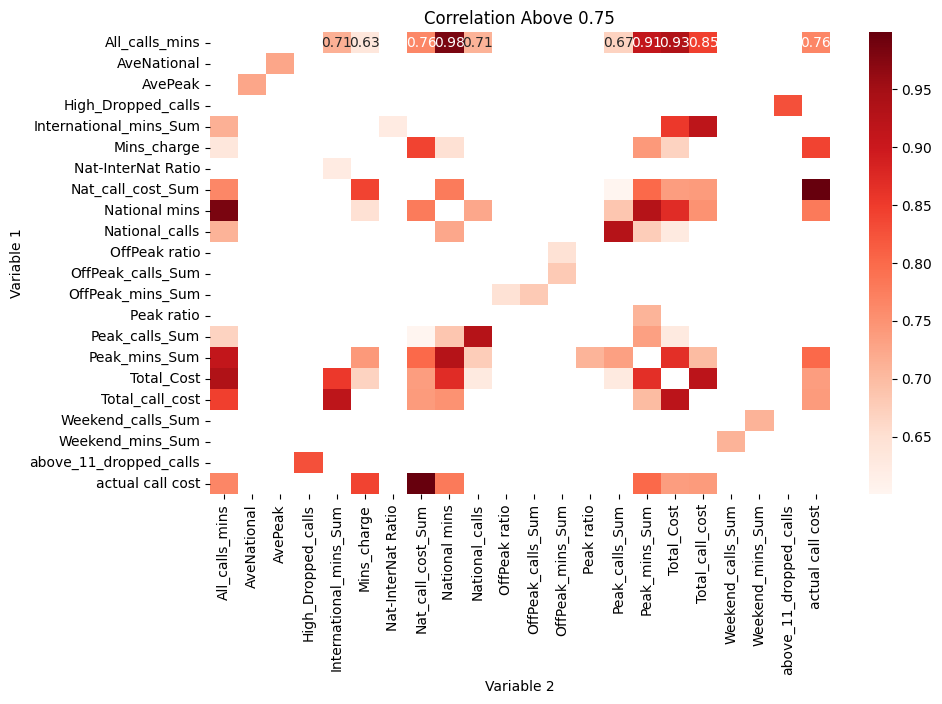

In [35]:
corr = X_training.drop("id",axis=1).corr()

high_corr = corr[(corr > 0.60) & (corr < 1.0)]

# Remove NaN values and duplicate entries
high_corr = high_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').stack().reset_index()

# Rename columns
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Plotting the high correlations using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(high_corr.pivot_table(index='Variable 1', columns='Variable 2', values='Correlation'), annot=True, cmap='Reds', fmt=".2f")
plt.title('Correlation Above 0.75')
plt.show()

In [36]:
variable_list = list(set(high_corr['Variable 1']).union(set(high_corr['Variable 2'])))

# Print the list of variables
print("Variables used in the heatmap:")
print(variable_list)

Variables used in the heatmap:
['Nat-InterNat Ratio', 'AvePeak', 'National_calls', 'AveNational', 'Nat_call_cost_Sum', 'above_11_dropped_calls', 'Weekend_calls_Sum', 'OffPeak ratio', 'Weekend_mins_Sum', 'OffPeak_mins_Sum', 'Total_call_cost', 'Total_Cost', 'National mins', 'High_Dropped_calls', 'Peak_calls_Sum', 'Peak ratio', 'International_mins_Sum', 'actual call cost', 'OffPeak_calls_Sum', 'Peak_mins_Sum', 'All_calls_mins', 'Mins_charge']


# Dimensionality Reduction - PCA
- Standardize the data 
- apply PCA, such that the highest amount of variance is explaned
- choose number of components based on skree plot
- replace correlated features with their corresponding principal components 
- Adjust PCA to the test set using tranform

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cols_to_scale = ['Age', 'L_O_S', 'Dropped_Calls',
       'Peak_calls_Sum', 'Peak_mins_Sum', 'OffPeak_calls_Sum',
       'OffPeak_mins_Sum', 'Weekend_calls_Sum', 'Weekend_mins_Sum',
       'International_mins_Sum', 'Nat_call_cost_Sum', 'AvePeak', 'AveOffPeak',
       'AveWeekend', 'National_calls', 'National mins', 'AveNational',
       'All_calls_mins', 'Dropped_calls_ratio', 'Mins_charge',
       'call_cost_per_min', 'actual call cost', 'Total_call_cost',
       'Total_Cost', 'average cost min', 'Peak ratio', 'OffPeak ratio',
       'Weekend ratio', 'Nat-InterNat Ratio' ]

# Create the StandardScaler object
scaler = StandardScaler()

# Fit and transform the specified columns
X_training[cols_to_scale] = scaler.fit_transform(X_training[cols_to_scale])
X_testing[cols_to_scale] = scaler.transform(X_testing[cols_to_scale])

In [38]:
X_training.head()

Gender       Age Connect_Date     L_O_S  Dropped_Calls  Peak_calls_Sum  \
1608       1 -1.522189   1997-12-25  0.023503       2.687861        0.440537   
3024       1 -0.820099   1997-06-19  0.471394      -0.197917        0.139886   
2902       1  1.286170   1998-12-01 -0.019154      -0.486495        1.045901   
2691       0  0.350050   1997-06-07  0.431107      -0.197917       -0.867700   
1617       0 -0.586069   1997-01-31  0.800795      -0.486495        0.627428   

      Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
1608      -0.234048           1.270758          0.512455          -0.454938   
3024      -0.485180          -0.656323         -0.209448          -0.454938   
2902       0.188042          -0.952013         -1.450640          -0.515314   
2691      -1.156044           0.924087          0.231798          -0.877568   
1617       0.037127          -0.727696         -0.440577           0.994077   

      Weekend_mins_Sum  International_mins_Sum  Nat_call_cost_Sum   AvePeak  \
1608          1.254814               -0.573411          -0.682452 -0.758208   
3024         -0.893269               -0.239518          -0.090219 -0.761135   
2902         -0.926317               -0.443634           0.564065 -0.775661   
2691         -0.367264               -0.076711          -0.682452 -0.149936   
1617          2.097523                0.709676          -0.682452 -0.721012   

      AveOffPeak  AveWeekend  National_calls  National mins  AveNational  \
1608   -0.727825    1.731495        0.844922       0.052645    -0.859437   
3024    0.480156   -0.631000       -0.140394      -0.585288    -0.663015   
2902   -0.652128   -0.606012        0.582670      -0.415282    -0.968974   
2691   -0.720805    2.353171       -0.515039      -1.011851    -0.670166   
1617    0.489820   -0.117198        0.372869       0.012740    -0.650934   

      All_calls_mins  Dropped_calls_ratio  Mins_charge  call_cost_per_min  \
1608       -0.082095             0.140007    -0.344371          -1.134484   
3024       -0.554170            -0.217394     0.173317           0.509602   
2902       -0.453897            -0.323024     0.366596           2.106205   
2691       -0.883237            -0.149255    -0.311640          -0.186036   
1617        0.168288            -0.317174    -0.389739          -0.806504   

      actual call cost  Total_call_cost  Total_Cost  average cost min  \
1608         -0.678500        -0.782966   -0.125022         -0.314921   
3024         -0.085791        -0.268230   -0.292427          0.510814   
2902          0.569017        -0.103500   -0.172041          0.465716   
2691         -0.678500        -0.170014   -0.764953          0.495136   
1617         -0.678500         0.121563    0.536014          0.225589   

      Peak ratio  OffPeak ratio  Weekend ratio  Nat-InterNat Ratio       id  \
1608   -0.322162       0.230763       0.378521           -0.771061  K404940   
3024    0.031671       0.153838      -0.588895            0.172061  K288220   
2902    1.531757      -1.432697      -0.649550           -0.337426  K282860   
2691   -1.662906       1.742047       0.133705            1.358927  K268330   
1617    0.294145      -0.571983       0.837444            0.829028  K179730   

      High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  \
1608                   1              1                       0   
3024                   0              1                       0   
2902                   0              1                       0   
2691                   0              1                       0   
1617                   0              1                       0   

      woe_handset_cat  woe_tariff_cat  woe_usage_cat  
1608        -2.954247        0.027035       0.289711  
3024         0.108214        0.027035       0.289711  
2902         0.108214        0.027035       0.289711  
2691         2.114110       -0.448237       0.289711  
1617         2.114110        0.027035       0.289711

In [39]:
X_testing.head()

Gender       Age Connect_Date     L_O_S  Dropped_Calls  Peak_calls_Sum  \
1664       1 -0.352039   1996-06-03  1.585197      -0.775072        1.570008   
1976       1  0.038011   1997-07-07  0.428738      -0.197917       -0.302964   
1315       1 -0.118009   1999-08-01 -0.874650      -0.775072        0.070818   
1676       0  1.754230   1996-09-08  1.215509      -0.197917        0.152075   
640        0 -1.366169   1998-08-04 -0.222956      -0.775072       -0.810820   

      Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
1664       0.606595          -0.809266          1.099282           1.114828   
1976      -0.834171          -0.411614          0.189775           1.054453   
1315       0.209264           0.832322         -0.095384          -0.454938   
1676      -0.032435           0.138980          0.204783          -0.454938   
640        0.357821          -0.931620         -0.147913          -0.334187   

      Weekend_mins_Sum  International_mins_Sum  Nat_call_cost_Sum   AvePeak  \
1664          1.816620                2.574495           0.635789 -0.773625   
1976          1.882715               -0.111862          -0.682452 -0.754706   
1315         -0.430605               -1.056578          -0.682452 -0.403462   
1676         -0.849206               -0.989370          -0.682452 -0.565065   
640          -0.347987               -0.259082          -0.644144  2.396198   

      AveOffPeak  AveWeekend  National_calls  National mins  AveNational  \
1664    2.367359   -0.256116        1.219567       1.083066    -0.611359   
1976    0.164678   -0.210347       -0.365181      -0.579821    -0.423090   
1315   -0.784549   -0.122155        0.342898       0.130815    -0.568097   
1676   -0.439466   -0.582538        0.163068      -0.011677    -0.520895   
640     2.367359   -0.236149       -1.110724       0.254903     2.739000   

      All_calls_mins  Dropped_calls_ratio  Mins_charge  call_cost_per_min  \
1664        1.498127            -0.371388     0.827109          -0.957555   
1976       -0.521180            -0.182659    -2.306367           0.288330   
1315       -0.122325            -0.371388    -0.255500          -0.715825   
1676       -0.229405            -0.248041    -0.417498          -0.864968   
640         0.160761            -0.371388    -0.114426          -0.663076   

      actual call cost  Total_call_cost  Total_Cost  average cost min  \
1664          0.640799         2.058001    1.951177         -0.083294   
1976         -0.678500        -0.203053   -0.571667         -0.190749   
1315         -0.678500        -1.123581   -0.373945         -0.655278   
1676         -0.678500        -1.076202   -0.339321         -0.395365   
640          -0.640161        -0.543306    0.050123         -0.465703   

      Peak ratio  OffPeak ratio  Weekend ratio  Nat-InterNat Ratio       id  \
1664    0.010304      -0.043541       0.117192            1.491849  K117540   
1976   -1.025259       0.650038       1.446754            0.390956  K276210   
1315    0.464539      -0.341435      -0.486309           -1.362271  K316950   
1676    0.184285       0.015877      -0.670241           -1.266373  K311260   
640     0.563662      -0.451302      -0.474172           -0.494250  K246870   

      High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  \
1664                   0              1                       0   
1976                   0              1                       0   
1315                   0              1                       0   
1676                   0              1                       0   
640                    0              1                       0   

      woe_handset_cat  woe_tariff_cat  woe_usage_cat  
1664         2.114110        0.027035       0.008955  
1976         2.114110        0.602513       0.289711  
1315         0.108214        0.027035       0.289711  
1676         0.108214        0.027035       0.289711  
640          0.108214        0.027035       0.289711

In [40]:
# Apply PCA on the correlated features 

X_train_pca = X_training[['National mins', 'OffPeak_calls_Sum', 'OffPeak ratio', 'National_calls', 'Total_Cost', 'Peak_mins_Sum', 'All_calls_mins', 'Mins_charge', 'OffPeak_mins_Sum', 'Nat_call_cost_Sum', 'Peak ratio', 'Weekend_calls_Sum', 'Total_call_cost', 'actual call cost', 'AveNational', 'International_mins_Sum', 'AvePeak', 'Peak_calls_Sum', 'Nat-InterNat Ratio', 'Weekend_mins_Sum']]
X_test_pca = X_testing[['National mins', 'OffPeak_calls_Sum', 'OffPeak ratio', 'National_calls', 'Total_Cost', 'Peak_mins_Sum', 'All_calls_mins', 'Mins_charge', 'OffPeak_mins_Sum', 'Nat_call_cost_Sum', 'Peak ratio', 'Weekend_calls_Sum', 'Total_call_cost', 'actual call cost', 'AveNational', 'International_mins_Sum', 'AvePeak', 'Peak_calls_Sum', 'Nat-InterNat Ratio', 'Weekend_mins_Sum']]

pca = PCA(random_state=78)
pc = pca.fit_transform(X_train_pca)
pc_test = pca.transform(X_test_pca)

pc_df = pd.DataFrame(pc)
pc_test_df = pd.DataFrame(pc_test)

In [41]:
pca.n_components_

20

In [42]:
pca.explained_variance_ratio_.round(2)

array([0.44, 0.15, 0.12, 0.09, 0.08, 0.04, 0.03, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [43]:
pca.explained_variance_ratio_.cumsum()

array([0.43647724, 0.58783875, 0.70421444, 0.79057739, 0.87275058,
       0.9130695 , 0.94193532, 0.95680683, 0.97024996, 0.97943524,
       0.98722874, 0.99296447, 0.99782502, 0.99896441, 0.99981548,
       0.99996351, 1.        , 1.        , 1.        , 1.        ])

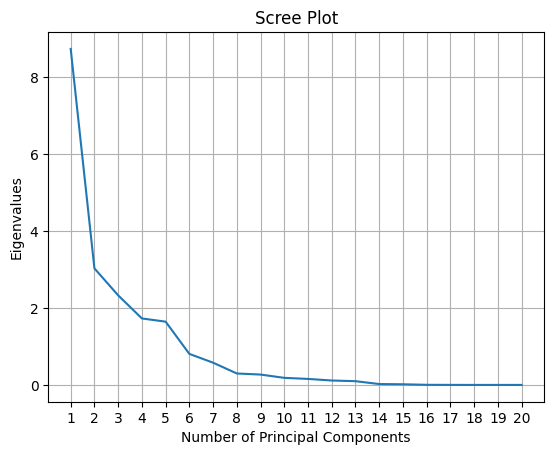

In [44]:
plt.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_)

plt.xlabel('Number of Principal Components')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot')

plt.xticks(np.arange(1, len(pca.explained_variance_) + 1))
plt.grid(True)

plt.show()

In [45]:
component_values = pca.components_.round(2)

for i in range(0,6): 
    print(f'PC {i+1} effects = ' + str(dict(zip(X_train_pca.columns, component_values[0:6][i]))))

PC 1 effects = {'National mins': 0.31, 'OffPeak_calls_Sum': 0.04, 'OffPeak ratio': -0.17, 'National_calls': 0.26, 'Total_Cost': 0.32, 'Peak_mins_Sum': 0.32, 'All_calls_mins': 0.32, 'Mins_charge': 0.27, 'OffPeak_mins_Sum': 0.04, 'Nat_call_cost_Sum': 0.29, 'Peak ratio': 0.2, 'Weekend_calls_Sum': 0.0, 'Total_call_cost': 0.29, 'actual call cost': 0.29, 'AveNational': -0.03, 'International_mins_Sum': 0.23, 'AvePeak': -0.04, 'Peak_calls_Sum': 0.26, 'Nat-InterNat Ratio': 0.03, 'Weekend_mins_Sum': 0.01}
PC 2 effects = {'National mins': 0.08, 'OffPeak_calls_Sum': 0.45, 'OffPeak ratio': 0.44, 'National_calls': 0.15, 'Total_Cost': 0.04, 'Peak_mins_Sum': -0.11, 'All_calls_mins': 0.11, 'Mins_charge': -0.15, 'OffPeak_mins_Sum': 0.5, 'Nat_call_cost_Sum': -0.02, 'Peak ratio': -0.4, 'Weekend_calls_Sum': 0.06, 'Total_call_cost': 0.15, 'actual call cost': -0.02, 'AveNational': -0.17, 'International_mins_Sum': 0.16, 'AvePeak': -0.09, 'Peak_calls_Sum': -0.02, 'Nat-InterNat Ratio': 0.13, 'Weekend_mins_Sum':

In [46]:
PC_1 = {'National mins': 0.31, 'OffPeak_calls_Sum': 0.04, 'OffPeak ratio': -0.17, 'National_calls': 0.26, 'Total_Cost': 0.32, 'Peak_mins_Sum': 0.32, 'All_calls_mins': 0.32, 'Mins_charge': 0.27, 'OffPeak_mins_Sum': 0.04, 'Nat_call_cost_Sum': 0.29, 'Peak ratio': 0.2, 'Weekend_calls_Sum': 0.0, 'Total_call_cost': 0.29, 'actual call cost': 0.29, 'AveNational': -0.03, 'International_mins_Sum': 0.23, 'AvePeak': -0.04, 'Peak_calls_Sum': 0.26, 'Nat-InterNat Ratio': 0.03, 'Weekend_mins_Sum': 0.01}
PC_2 = {'National mins': 0.08, 'OffPeak_calls_Sum': 0.45, 'OffPeak ratio': 0.44, 'National_calls': 0.15, 'Total_Cost': 0.04, 'Peak_mins_Sum': -0.11, 'All_calls_mins': 0.11, 'Mins_charge': -0.15, 'OffPeak_mins_Sum': 0.5, 'Nat_call_cost_Sum': -0.02, 'Peak ratio': -0.4, 'Weekend_calls_Sum': 0.06, 'Total_call_cost': 0.15, 'actual call cost': -0.02, 'AveNational': -0.17, 'International_mins_Sum': 0.16, 'AvePeak': -0.09, 'Peak_calls_Sum': -0.02, 'Nat-InterNat Ratio': 0.13, 'Weekend_mins_Sum': 0.05}
PC_3 = {'National mins': 0.04, 'OffPeak_calls_Sum': -0.05, 'OffPeak ratio': 0.07, 'National_calls': -0.33, 'Total_Cost': 0.14, 'Peak_mins_Sum': 0.01, 'All_calls_mins': 0.09, 'Mins_charge': 0.02, 'OffPeak_mins_Sum': 0.09, 'Nat_call_cost_Sum': 0.03, 'Peak ratio': -0.05, 'Weekend_calls_Sum': -0.04, 'Total_call_cost': 0.2, 'actual call cost': 0.03, 'AveNational': 0.55, 'International_mins_Sum': 0.24, 'AvePeak': 0.52, 'Peak_calls_Sum': -0.34, 'Nat-InterNat Ratio': 0.25, 'Weekend_mins_Sum': -0.01}
PC_4 = {'National mins': -0.01, 'OffPeak_calls_Sum': -0.09, 'OffPeak ratio': -0.09, 'National_calls': -0.01, 'Total_Cost': 0.01, 'Peak_mins_Sum': -0.03, 'All_calls_mins': 0.0, 'Mins_charge': -0.02, 'OffPeak_mins_Sum': -0.09, 'Nat_call_cost_Sum': -0.02, 'Peak ratio': -0.05, 'Weekend_calls_Sum': 0.69, 'Total_call_cost': 0.04, 'actual call cost': -0.02, 'AveNational': -0.02, 'International_mins_Sum': 0.06, 'AvePeak': 0.01, 'Peak_calls_Sum': -0.02, 'Nat-InterNat Ratio': 0.08, 'Weekend_mins_Sum': 0.69}
PC_5 = {'National mins': -0.18, 'OffPeak_calls_Sum': -0.16, 'OffPeak ratio': -0.09, 'National_calls': -0.01, 'Total_Cost': 0.14, 'Peak_mins_Sum': -0.1, 'All_calls_mins': -0.07, 'Mins_charge': -0.14, 'OffPeak_mins_Sum': -0.22, 'Nat_call_cost_Sum': -0.19, 'Peak ratio': 0.07, 'Weekend_calls_Sum': -0.1, 'Total_call_cost': 0.21, 'actual call cost': -0.19, 'AveNational': -0.21, 'International_mins_Sum': 0.4, 'AvePeak': -0.27, 'Peak_calls_Sum': 0.06, 'Nat-InterNat Ratio': 0.65, 'Weekend_mins_Sum': -0.1}
PC_6= {'National mins': -0.2, 'OffPeak_calls_Sum': -0.21, 'OffPeak ratio': 0.24, 'National_calls': -0.15, 'Total_Cost': -0.12, 'Peak_mins_Sum': -0.17, 'All_calls_mins': -0.2, 'Mins_charge': 0.41, 'OffPeak_mins_Sum': -0.13, 'Nat_call_cost_Sum': 0.43, 'Peak ratio': -0.31, 'Weekend_calls_Sum': -0.01, 'Total_call_cost': 0.13, 'actual call cost': 0.43, 'AveNational': -0.07, 'International_mins_Sum': -0.1, 'AvePeak': -0.19, 'Peak_calls_Sum': -0.08, 'Nat-InterNat Ratio': 0.15, 'Weekend_mins_Sum': -0.02}

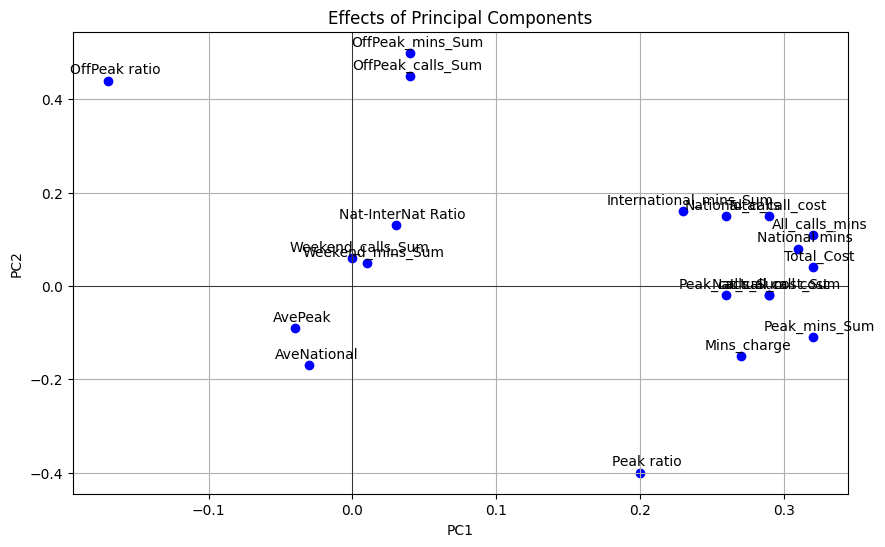

In [47]:
# Extract keys and values from the dictionaries
PC1_keys = list(PC_1.keys())
PC1_values = list(PC_1.values())

PC2_keys = list(PC_2.keys())
PC2_values = list(PC_2.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(PC1_values, PC2_values, color='blue')

# Add labels to each point
for i, txt in enumerate(PC1_keys):
    plt.annotate(txt, (PC1_values[i], PC2_values[i]), textcoords="offset points", xytext=(5,5), ha='center')

# Set plot title and labels
plt.title('Effects of Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [48]:
dict_list = [PC_1, PC_2, PC_3, PC_4, PC_5, PC_6]

# Create a DataFrame
df = pd.DataFrame(dict_list)

# Transpose the DataFrame
df = df.transpose()

# Set column names
df.columns = ['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6']

print(df)

                        PC_1  PC_2  PC_3  PC_4  PC_5  PC_6
National mins           0.31  0.08  0.04 -0.01 -0.18 -0.20
OffPeak_calls_Sum       0.04  0.45 -0.05 -0.09 -0.16 -0.21
OffPeak ratio          -0.17  0.44  0.07 -0.09 -0.09  0.24
National_calls          0.26  0.15 -0.33 -0.01 -0.01 -0.15
Total_Cost              0.32  0.04  0.14  0.01  0.14 -0.12
Peak_mins_Sum           0.32 -0.11  0.01 -0.03 -0.10 -0.17
All_calls_mins          0.32  0.11  0.09  0.00 -0.07 -0.20
Mins_charge             0.27 -0.15  0.02 -0.02 -0.14  0.41
OffPeak_mins_Sum        0.04  0.50  0.09 -0.09 -0.22 -0.13
Nat_call_cost_Sum       0.29 -0.02  0.03 -0.02 -0.19  0.43
Peak ratio              0.20 -0.40 -0.05 -0.05  0.07 -0.31
Weekend_calls_Sum       0.00  0.06 -0.04  0.69 -0.10 -0.01
Total_call_cost         0.29  0.15  0.20  0.04  0.21  0.13
actual call cost        0.29 -0.02  0.03 -0.02 -0.19  0.43
AveNational            -0.03 -0.17  0.55 -0.02 -0.21 -0.07
International_mins_Sum  0.23  0.16  0.24  0.06  0.40 -0.

In [49]:
pca_X_train_6 = pc_df.iloc[:,0:6]
pca_X_test_6 = pc_test_df.iloc[:,0:6]
pca_X_train_6.columns = ["PC_1","PC_2","PC_3","PC_4","PC_5","PC_6"]
pca_X_test_6.columns = ["PC_1","PC_2","PC_3","PC_4","PC_5","PC_6"]

In [50]:
X_train_after_pca = X_training.drop(['National mins', 'OffPeak_calls_Sum', 'OffPeak ratio', 'National_calls', 'Total_Cost', 'Peak_mins_Sum', 'All_calls_mins', 'Mins_charge', 'OffPeak_mins_Sum', 'Nat_call_cost_Sum', 'Peak ratio', 'Weekend_calls_Sum', 'Total_call_cost', 'actual call cost', 'AveNational', 'International_mins_Sum', 'AvePeak', 'Peak_calls_Sum', 'Nat-InterNat Ratio', 'Weekend_mins_Sum'],axis=1)
X_test_after_pca = X_testing.drop(['National mins', 'OffPeak_calls_Sum', 'OffPeak ratio', 'National_calls', 'Total_Cost', 'Peak_mins_Sum', 'All_calls_mins', 'Mins_charge', 'OffPeak_mins_Sum', 'Nat_call_cost_Sum', 'Peak ratio', 'Weekend_calls_Sum', 'Total_call_cost', 'actual call cost', 'AveNational', 'International_mins_Sum', 'AvePeak', 'Peak_calls_Sum', 'Nat-InterNat Ratio', 'Weekend_mins_Sum'],axis=1)

In [51]:
X_train_after_pca.reset_index(drop=True,inplace=True)
X_test_after_pca.reset_index(drop=True,inplace=True)

X_train_after_pca = pd.merge(X_train_after_pca, pca_X_train_6, left_index=True, right_index=True, how='outer')
X_test_after_pca = pd.merge(X_test_after_pca, pca_X_test_6, left_index=True, right_index=True, how='outer')


In [52]:
X_train_after_pca.head()

Gender       Age Connect_Date     L_O_S  Dropped_Calls  AveOffPeak  \
0       1 -1.522189   1997-12-25  0.023503       2.687861   -0.727825   
1       1 -0.820099   1997-06-19  0.471394      -0.197917    0.480156   
2       1  1.286170   1998-12-01 -0.019154      -0.486495   -0.652128   
3       0  0.350050   1997-06-07  0.431107      -0.197917   -0.720805   
4       0 -0.586069   1997-01-31  0.800795      -0.486495    0.489820   

   AveWeekend  Dropped_calls_ratio  call_cost_per_min  average cost min  \
0    1.731495             0.140007          -1.134484         -0.314921   
1   -0.631000            -0.217394           0.509602          0.510814   
2   -0.606012            -0.323024           2.106205          0.465716   
3    2.353171            -0.149255          -0.186036          0.495136   
4   -0.117198            -0.317174          -0.806504          0.225589   

   Weekend ratio       id  High_Dropped_calls  Tariff_OK_cat  \
0       0.378521  K404940                   1              1   
1      -0.588895  K288220                   0              1   
2      -0.649550  K282860                   0              1   
3       0.133705  K268330                   0              1   
4       0.837444  K179730                   0              1   

   above_11_dropped_calls  woe_handset_cat  woe_tariff_cat  woe_usage_cat  \
0                       0        -2.954247        0.027035       0.289711   
1                       0         0.108214        0.027035       0.289711   
2                       0         0.108214        0.027035       0.289711   
3                       0         2.114110       -0.448237       0.289711   
4                       0         2.114110        0.027035       0.289711   

       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  
0 -0.614796  1.217934 -1.830216  0.286092 -0.624709 -0.983982  
1 -0.758775 -0.400732 -0.894722 -0.860130  0.749651  0.767275  
2  0.950486 -2.497942 -1.946074 -0.832964  0.697511  0.428025  
3 -2.646538  2.096460  0.240503 -0.833572  1.151226  1.081384  
4  0.407168 -0.176704 -0.759885  2.420086  1.547001 -0.783275

In [53]:
X_test_after_pca.head()

Gender       Age Connect_Date     L_O_S  Dropped_Calls  AveOffPeak  \
0       1 -0.352039   1996-06-03  1.585197      -0.775072    2.367359   
1       1  0.038011   1997-07-07  0.428738      -0.197917    0.164678   
2       1 -0.118009   1999-08-01 -0.874650      -0.775072   -0.784549   
3       0  1.754230   1996-09-08  1.215509      -0.197917   -0.439466   
4       0 -1.366169   1998-08-04 -0.222956      -0.775072    2.367359   

   AveWeekend  Dropped_calls_ratio  call_cost_per_min  average cost min  \
0   -0.256116            -0.371388          -0.957555         -0.083294   
1   -0.210347            -0.182659           0.288330         -0.190749   
2   -0.122155            -0.371388          -0.715825         -0.655278   
3   -0.582538            -0.248041          -0.864968         -0.395365   
4   -0.236149            -0.371388          -0.663076         -0.465703   

   Weekend ratio       id  High_Dropped_calls  Tariff_OK_cat  \
0       0.117192  K117540                   0              1   
1       1.446754  K276210                   0              1   
2      -0.486309  K316950                   0              1   
3      -0.670241  K311260                   0              1   
4      -0.474172  K246870                   0              1   

   above_11_dropped_calls  woe_handset_cat  woe_tariff_cat  woe_usage_cat  \
0                       0         2.114110        0.027035       0.008955   
1                       0         2.114110        0.602513       0.289711   
2                       0         0.108214        0.027035       0.289711   
3                       0         0.108214        0.027035       0.289711   
4                       0         0.108214        0.027035       0.289711   

       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  
0  4.291632  1.683734  0.301091  2.259975  1.999310  0.131713  
1 -2.319786  1.186444 -0.560833  2.174288  0.764209 -0.332762  
2 -0.807671 -0.363238 -1.645772 -0.869161 -1.067074 -1.244452  
3 -1.125369 -0.235184 -1.535966 -1.117940 -0.804168 -0.878411  
4 -0.928442 -1.937057  3.065500 -0.423836 -1.291564 -1.362494

In [54]:
X_test_after_pca.shape

(1514, 24)

In [55]:
X_testing.shape

(1514, 38)

In [56]:
X_train_after_pca.shape

(3530, 24)

In [57]:
X_training.shape

(3530, 38)

In [58]:
y_test.shape

(1514,)

In [59]:
y_train.shape

(3530,)

# Define Profit Function

In [60]:
# go to X_test_after_pca
# select id and average cost min into a new dataframe
# add y_test (true target values)
# add predict proba (prob of target)
# add predict (predictions of target values)
# sort by probability 
# filter the top 20 rows where true target = 1 


def profit_metric(actual_target,prob_array,predict_array,dataset=X_test_after_pca):
    profit_table = dataset[["id","average cost min"]]
    profit_table.loc[:,"Prob_1"] = pd.Series(prob_array, index=profit_table.index)
    profit_table.loc[:,"target"]= actual_target.reset_index(drop=True)
    profit_table.loc[:,"Pred_1"] = pd.Series(predict_array, index=profit_table.index)
    profit_table_sorted = profit_table.sort_values("Prob_1", ascending=False)
    top_k_table = profit_table_sorted.head(20)
    profit_at_top_20 = top_k_table[(top_k_table["target"] == 1) & (top_k_table['Pred_1'] ==1)]['average cost min'].sum()  

    return profit_at_top_20


    

In [61]:
def calculate_profit_metric_2(y_true, y_test_proba, dataset=X_test_after_pca, top_k=20):
    # Reset indices of the dataset DataFrame
    dataset.reset_index(drop=True, inplace=True)
    
    # Convert y_probabilities to a DataFrame and then reset indices
    #proba_df = pd.DataFrame(proba, columns=['Prob_0', 'Prob_1'])
    proba_df = pd.DataFrame(y_test_proba, columns=['Prob_1'])
    proba_df.reset_index(drop=True, inplace=True)

    y_true.reset_index(drop=True, inplace=True)

    # Now concatenate the DataFrames
    profit_df = pd.concat([dataset[['average cost min']], proba_df, y_true], axis=1)

    # Sort concatenated_df by PROB_1 column in descending order
    profit_df_sorted = profit_df.sort_values(by='Prob_1', ascending=False)

    # Filter the top 20 rows
    top_k_rows = profit_df_sorted.head(top_k)

    # Filter the top 20 rows where target == 1 (actual churner) and sum the 'average cost min' values
    profit_at_top_k = top_k_rows[(top_k_rows[y_true.name] == 1) & (top_k_rows['Prob_1'] > 0.5)]['average cost min'].sum() 
    
    return profit_at_top_k

profit_scorer = make_scorer(calculate_profit_metric_2, needs_proba=True, greater_is_better=True)



c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [62]:
def profit_metric_2(actual_target,prob_array,predict_array,dataset=X_test_after_pca):
    profit_table = dataset[["id","average cost min"]]
    profit_table.loc[:,"Prob_1"] = pd.Series(prob_array, index=profit_table.index)
    profit_table.loc[:,"target"]= actual_target.reset_index(drop=True)
    profit_table.loc[:,"Pred_1"] = pd.Series(predict_array, index=profit_table.index)
    profit_table_sorted = profit_table.sort_values("Prob_1", ascending=False)
    top_k_table = profit_table_sorted.head(20)
    profit_at_top_20 = abs(top_k_table[(top_k_table["target"] == 1) & (top_k_table['Pred_1'] ==1)]['average cost min']).sum()  

    return profit_at_top_20

In [63]:
# def profit_metric_3(actual_target,prob_array,predict_array,dataset=X_test_after_pca_prof):
#     profit_table = dataset[["id","average cost min"]]
#     profit_table.loc[:,"Prob_1"] = pd.Series(prob_array, index=profit_table.index)
#     profit_table.loc[:,"target"]= actual_target.reset_index(drop=True)
#     profit_table.loc[:,"Pred_1"] = pd.Series(predict_array, index=profit_table.index)
#     profit_table_sorted = profit_table.sort_values("Prob_1", ascending=False)
#     top_k_table = profit_table_sorted.head(20)
#     profit_at_top_20 = abs(top_k_table[(top_k_table["target"] == 1) & (top_k_table['Pred_1'] ==1)]['average cost min']).sum()  

#     return profit_at_top_20

# SMOTE to balance the churners (target=1) and non-churners (target=0)


In [64]:
X_train_after_pca_cl = X_train_after_pca.drop(["id","Connect_Date"],axis=1)
X_test_after_pca_cl = X_test_after_pca.drop(["id","Connect_Date"],axis=1)


smt = SMOTE(random_state=34)
X_train_after_pca_smote, y_train_smote = smt.fit_resample(X_train_after_pca_cl,y_train)

In [65]:
Counter(y_train)

Counter({0: 3009, 1: 521})

In [66]:
Counter(y_train_smote)

Counter({1: 3009, 0: 3009})

In [67]:
X_train_after_pca_smote.shape

(6018, 22)

# Random Forest

## Random Forest - Cross Validation using Profit Metric"

In [68]:
random_f = RandomForestClassifier(bootstrap=True,random_state=7)

grid_param = {
    "n_estimators" : [50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200],
    'criterion': ['gini','entropy'],
   # 'class_weight' : ["balanced", "balanced_subsample"],
    'max_features' : [1,2,"log2","sqrt"]
}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

random_searcher = GridSearchCV(random_f, grid_param, scoring="precision")
random_searcher.fit(X_train_after_pca_smote, y_train_smote)



GridSearchCV(estimator=RandomForestClassifier(random_state=7),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [1, 2, 'log2', 'sqrt'],
                         'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120,
                                          130, 140, 150, 160, 170, 180, 190,
                                          200]},
             scoring='precision')

In [69]:
random_searcher.best_params_

{'criterion': 'gini', 'max_features': 1, 'n_estimators': 120}

In [70]:
random_f_best = RandomForestClassifier(bootstrap=True, max_features=1,random_state=7,criterion="gini",n_estimators=120)

In [71]:
random_f_best.fit(X_train_after_pca_smote, y_train_smote)


RandomForestClassifier(max_features=1, n_estimators=120, random_state=7)

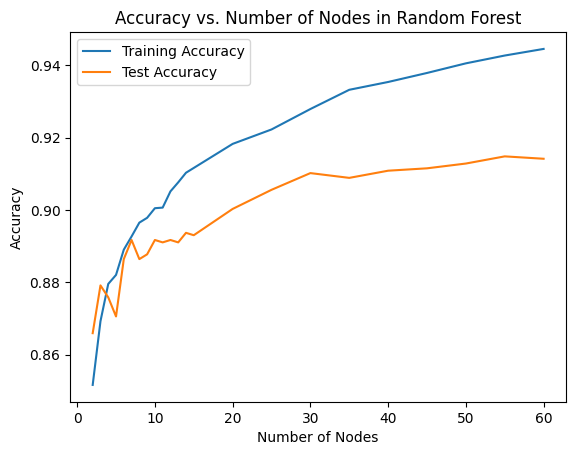

In [72]:

# Define a range of values for the number of nodes
node_values = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,30,35,40,45,50,55,60]  # Adjust this range as needed

# Initialize lists to store accuracy values
train_accuracies = []
test_accuracies = []

# Train Random Forest models with different numbers of nodes
for num_nodes in node_values:
    # Create and fit Random Forest model
    rf_model = RandomForestClassifier(bootstrap=True, max_features=1,random_state=7,criterion="gini",n_estimators=120, max_leaf_nodes=num_nodes)
    rf_model.fit(X_train_after_pca_smote, y_train_smote)

    #RandomForestClassifier(bootstrap=True, max_features="log2", random_state=45, class_weight="balanced")
    # Predict on training and test data
    train_preds = rf_model.predict(X_train_after_pca_smote)
    test_preds = rf_model.predict(X_test_after_pca_cl)
    
    # Calculate accuracy and append to lists
    train_accuracy = accuracy_score(y_train_smote, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(node_values, train_accuracies, label='Training Accuracy')
plt.plot(node_values, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Nodes in Random Forest')
plt.legend()
plt.show()

In [107]:
random_f_best = RandomForestClassifier(bootstrap=True, max_features=1,random_state=7,criterion="gini",n_estimators=120,max_leaf_nodes=30)

In [108]:

random_f_best.fit(X_train_after_pca_smote,y_train_smote)

RandomForestClassifier(max_features=1, max_leaf_nodes=30, n_estimators=120,
                       random_state=7)

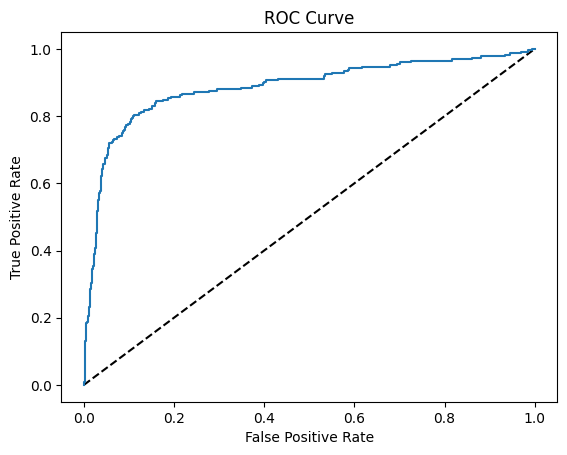

0.885046373200443
[[1220   70]
 [  66  158]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1290
           1       0.69      0.71      0.70       224

    accuracy                           0.91      1514
   macro avg       0.82      0.83      0.82      1514
weighted avg       0.91      0.91      0.91      1514



In [109]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_f_best.predict_proba(X_test_after_pca_cl)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_f_best.predict_proba(X_test_after_pca_cl)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_f_best.predict(X_test_after_pca_cl)))

# Calculate the classification report
print(classification_report(y_test, random_f_best.predict(X_test_after_pca_cl)))

In [374]:
profit_metric(y_test,random_f_best.predict_proba(X_test_after_pca_cl)[:,1],random_f_best.predict(X_test_after_pca_cl))

C:\Users\Johnn\AppData\Local\Temp\ipykernel_8096\1477244914.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_table.loc[:,"Prob_1"] = pd.Series(prob_array, index=profit_table.index)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_8096\1477244914.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_table.loc[:,"target"]= actual_target.reset_index(drop=True)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_8096\1477244914.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

3.760488535813245

In [438]:
calculate_profit_metric_2(y_test,random_f_best.predict_proba(X_test_after_pca_cl)[:,1])

3.760488535813245

c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

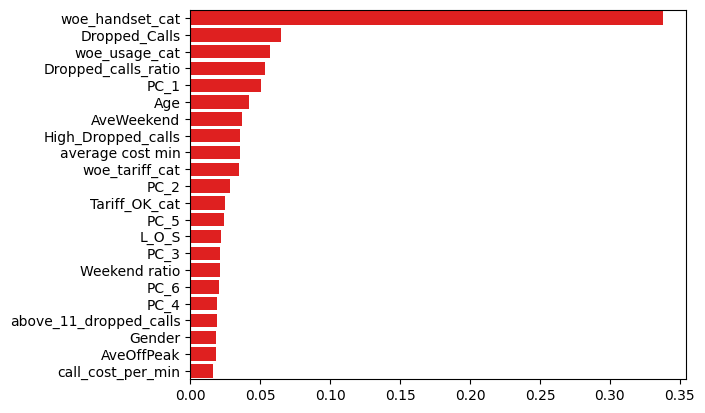

In [110]:
# Feature Importance 

diction = {key: value for key, value in zip(X_test_after_pca_cl.columns.values, random_f_best.feature_importances_)}
sorted_dict = dict(sorted(diction.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(sorted_dict.values()),y=list(sorted_dict.keys()),color="red")

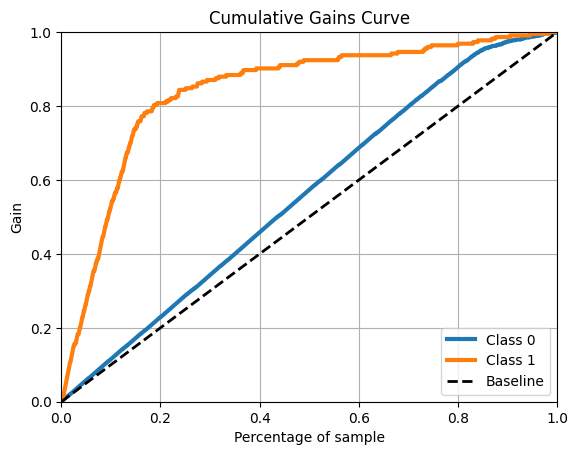

In [440]:
skplt.metrics.plot_cumulative_gain(y_test, random_f_best.predict_proba(X_test_after_pca_cl))
plt.show()

### Random Forest with cross val on subset based on feature selection with feature importance threshold 

In [ ]:
# Pick threshold importance, cross val, fit, check performance 

In [111]:
sorted_ft = sorted(random_f_best.feature_importances_)

In [112]:
sorted_ft

[0.01595464713195246,
 0.018312262817732027,
 0.018411414255650224,
 0.01886976387543,
 0.018870318076440577,
 0.020279118477147383,
 0.020977890410978483,
 0.02114002164496471,
 0.022020883939141023,
 0.024292767808289546,
 0.02454763010604663,
 0.028560763657139526,
 0.03490222629198814,
 0.03518645385692808,
 0.03585666079101761,
 0.03669563142681871,
 0.0420598331572837,
 0.05023526376668079,
 0.05356680203888621,
 0.05695944280329174,
 0.06451691903747592,
 0.33778328462871665]

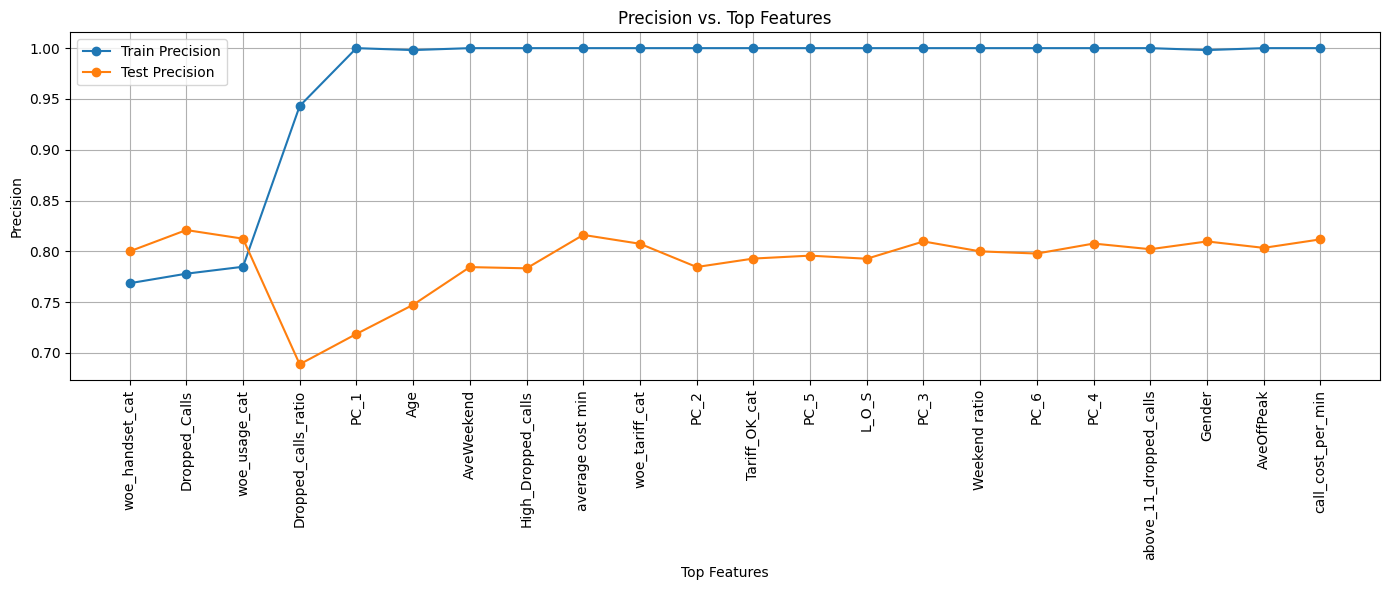

In [113]:

# Get feature importance dictionary
feature_importance_dict = {key: value for key, value in zip(X_train_after_pca_smote.columns.values, random_f_best.feature_importances_)}
sorted_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Initialize lists to store precision scores
train_precision_scores = []
test_precision_scores = []

# Initialize the model
model = RandomForestClassifier()

# Iterate over increasing number of top features
for i in range(1, len(sorted_dict) + 1):
    top_features = list(sorted_dict.keys())[:i]
    
    # Train model using top features
    model.fit(X_train_after_pca_cl[top_features], y_train)
    
    # Predictions on train and test set
    train_pred = model.predict(X_train_after_pca_cl[top_features])
    test_pred = model.predict(X_test_after_pca_cl[top_features])
    
    # Calculate precision scores
    train_precision = precision_score(y_train, train_pred)
    test_precision = precision_score(y_test, test_pred)
    
    # Append precision scores to lists
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)

# Plot precision scores
plt.figure(figsize=(14, 6))
plt.plot(list(sorted_dict.keys()), train_precision_scores, label='Train Precision', marker='o')
plt.plot(list(sorted_dict.keys()), test_precision_scores, label='Test Precision', marker='o')
plt.xlabel('Top Features')
plt.ylabel('Precision')
plt.title('Precision vs. Top Features')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
mask = random_f_best.feature_importances_ > 0.06

In [115]:
reduced_train = X_train_after_pca_smote.loc[:,mask]

In [116]:
reduced_train.head()

Dropped_Calls  woe_handset_cat
0       2.687861        -2.954247
1      -0.197917         0.108214
2      -0.486495         0.108214
3      -0.197917         2.114110
4      -0.486495         2.114110

In [117]:
reduced_test = X_test_after_pca_cl.loc[:,mask]

In [118]:
random_f_best.fit(reduced_train,y_train_smote)

RandomForestClassifier(max_features=1, max_leaf_nodes=30, n_estimators=120,
                       random_state=7)

In [392]:
profit_metric(y_test,random_f_best.predict_proba(reduced_test)[:,1],random_f_best.predict(reduced_test))

C:\Users\Johnn\AppData\Local\Temp\ipykernel_8096\1477244914.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_table.loc[:,"Prob_1"] = pd.Series(prob_array, index=profit_table.index)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_8096\1477244914.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_table.loc[:,"target"]= actual_target.reset_index(drop=True)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_8096\1477244914.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

1.1392134698621166

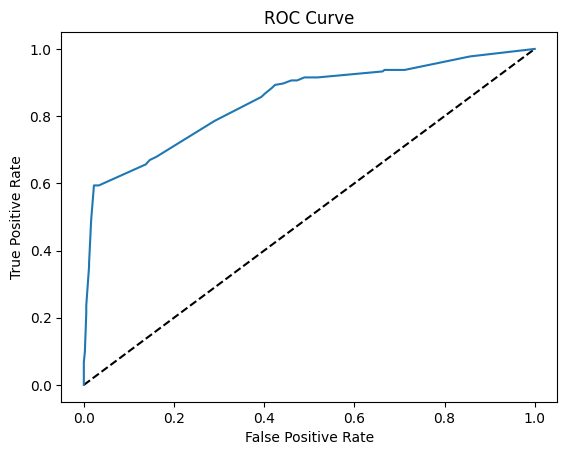

0.846752145625692
[[1261   29]
 [  91  133]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1290
           1       0.82      0.59      0.69       224

    accuracy                           0.92      1514
   macro avg       0.88      0.79      0.82      1514
weighted avg       0.92      0.92      0.92      1514



In [119]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_f_best.predict_proba(reduced_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_f_best.predict_proba(reduced_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_f_best.predict(reduced_test)))

# Calculate the classification report
print(classification_report(y_test, random_f_best.predict(reduced_test)))

In [94]:
int(math.log2(len(reduced_train.columns)+1))

3

In [133]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': random_f_best.predict(X_test_after_pca_prof.loc[:,reduced_test.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_rf_importance.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
 # 7th position: 3.936732 0.749565

### RFECV for feature selection and cross val on the subset of selected features based on profit metric 

In [134]:
random_rfe = RandomForestClassifier(bootstrap=True, max_features=1,random_state=7,criterion="gini",n_estimators=120,max_leaf_nodes=30)

In [135]:
kf = KFold(n_splits=5, shuffle=True, random_state=5)
rfecv = RFECV(random_rfe, cv=kf, scoring="precision", min_features_to_select=1)

In [136]:
rfecv.fit(X_train_after_pca_smote, y_train_smote)

RFECV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
      estimator=RandomForestClassifier(max_features=1, max_leaf_nodes=30,
                                       n_estimators=120, random_state=7),
      scoring='precision')

In [137]:
rfecv.n_features_

2

In [138]:
rfecv.get_feature_names_out()

array(['Dropped_Calls', 'woe_handset_cat'], dtype=object)

In [144]:
mask_rfe = rfecv.get_support()
mask_rfe

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False])

In [145]:
reduced_train_rfe = X_train_after_pca_smote.loc[:,rfecv.get_support()]
reduced_test_rfe = X_test_after_pca_cl.loc[:,rfecv.get_support()]

In [146]:
reduced_test_rfe.head()

Dropped_Calls  woe_handset_cat
0      -0.775072         2.114110
1      -0.197917         2.114110
2      -0.775072         0.108214
3      -0.197917         0.108214
4      -0.775072         0.108214

In [415]:
int(math.log2(len(reduced_train_rfe.columns)+1))

4

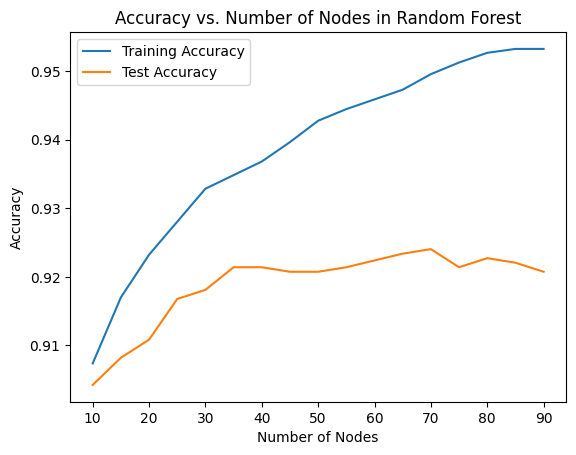

In [416]:
# Define a range of values for the number of nodes
node_values = [10,15,20,25,30,35,40,45,50,55,65,70,75,80,85,90]  # Adjust this range as needed

# Initialize lists to store accuracy values
train_accuracies = []
test_accuracies = []

# Train Random Forest models with different numbers of nodes
for num_nodes in node_values:
    # Create and fit Random Forest model
    rf_model = RandomForestClassifier(bootstrap=True, max_features=1,random_state=7,class_weight="balanced_subsample",criterion="gini",n_estimators=120, max_leaf_nodes=num_nodes)
    rf_model.fit(reduced_train_rfe, y_train)
    #RandomForestClassifier(bootstrap=True, max_features="log2", random_state=45, class_weight="balanced")
    # Predict on training and test data
    train_preds = rf_model.predict(reduced_train_rfe)
    test_preds = rf_model.predict(reduced_test_rfe)
    
    # Calculate accuracy and append to lists
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(node_values, train_accuracies, label='Training Accuracy')
plt.plot(node_values, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Nodes in Random Forest')
plt.legend()
plt.show()


In [147]:
random_rfe = RandomForestClassifier(bootstrap=True, max_features=1,random_state=7,criterion="gini",n_estimators=120,max_leaf_nodes=30)

In [149]:
random_rfe.fit(reduced_train_rfe,y_train_smote)

RandomForestClassifier(max_features=1, max_leaf_nodes=30, n_estimators=120,
                       random_state=7)

In [460]:
calculate_profit_metric_2(y_test,random_rfe.predict_proba(reduced_test_rfe)[:,1])

4.0524467884764785

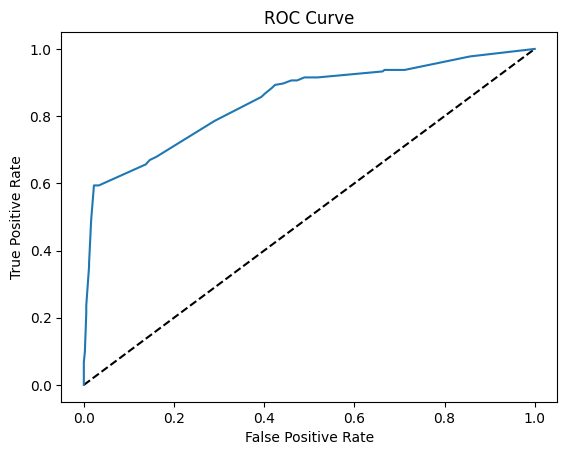

0.846752145625692
[[1261   29]
 [  91  133]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1290
           1       0.82      0.59      0.69       224

    accuracy                           0.92      1514
   macro avg       0.88      0.79      0.82      1514
weighted avg       0.92      0.92      0.92      1514



In [150]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_rfe.predict_proba(reduced_test_rfe)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_rfe.predict_proba(reduced_test_rfe)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_rfe.predict(reduced_test_rfe)))

# Calculate the classification report
print(classification_report(y_test, random_rfe.predict(reduced_test_rfe)))

In [462]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': random_rfe.predict(X_test_after_pca_prof.loc[:,reduced_test_rfe.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_16.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

### Step Forward Feature Selection - cross val

In [154]:
random_rfe

RandomForestClassifier(max_features=1, max_leaf_nodes=30, n_estimators=120,
                       random_state=7)

In [155]:
step_f = SequentialFeatureSelector(random_rfe,n_features_to_select=6,cv=kf,scoring="precision")


In [157]:
step_f.fit(X_train_after_pca_smote,y_train_smote)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                          estimator=RandomForestClassifier(max_features=1,
                                                           max_leaf_nodes=30,
                                                           n_estimators=120,
                                                           random_state=7),
                          n_features_to_select=6, scoring='precision')

In [158]:
mask_step = step_f.get_support()
mask_step

array([False,  True, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False])

In [159]:
reduced_train_step = X_train_after_pca_smote.loc[:,step_f.get_support()]
reduced_test_step = X_test_after_pca_cl.loc[:,step_f.get_support()]

In [160]:
reduced_train_step.head()

Age  High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  \
0 -1.522189                   1              1                       0   
1 -0.820099                   0              1                       0   
2  1.286170                   0              1                       0   
3  0.350050                   0              1                       0   
4 -0.586069                   0              1                       0   

   woe_handset_cat  woe_tariff_cat  
0        -2.954247        0.027035  
1         0.108214        0.027035  
2         0.108214        0.027035  
3         2.114110       -0.448237  
4         2.114110        0.027035

In [161]:
random_rfe.fit(reduced_train_step,y_train_smote)

RandomForestClassifier(max_features=1, max_leaf_nodes=30, n_estimators=120,
                       random_state=7)

In [612]:
calculate_profit_metric_2(y_test, random_rfe.predict_proba(reduced_test_step)[:,1])

3.437626894438794

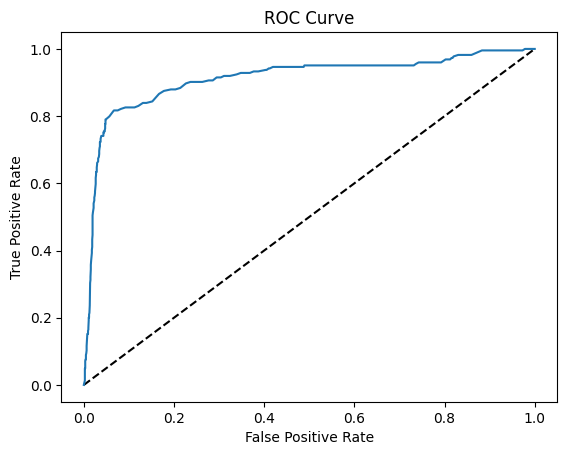

0.9114254568106313
[[1228   62]
 [  48  176]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1290
           1       0.74      0.79      0.76       224

    accuracy                           0.93      1514
   macro avg       0.85      0.87      0.86      1514
weighted avg       0.93      0.93      0.93      1514



In [162]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_rfe.predict_proba(reduced_test_step)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_rfe.predict_proba(reduced_test_step)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_rfe.predict(reduced_test_step)))

# Calculate the classification report
print(classification_report(y_test, random_rfe.predict(reduced_test_step)))

In [163]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': random_rfe.predict(X_test_after_pca_prof.loc[:,reduced_test_step.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_rf_step.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
# 8th 3.826936 0.857

### K-Best (ANOVA, VARIANCE CONTRIBUTION )

In [165]:
# Specify L2 regularization
#liblinear is the optimization method used to estimate the coefficients. liblinear is need for l1

random_k_best = RandomForestClassifier(random_state=8, bootstrap=True)

pipeline = Pipeline(
    [
     ('selector',SelectKBest(f_regression)),
     ('model',random_k_best)
    ]
)

param_grid = {
    'model__n_estimators' : [50,70,100,120],
    'model__max_features' : [1,2,"log2"],
    'selector__k' : [1,2,3,4,5,6]

}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

# Instantiate the GridSearchCV object and run the search
# The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
searcher_random = RandomizedSearchCV(pipeline, param_grid, cv=kf, scoring="precision")
searcher_random.fit(X_train_after_pca_smote, y_train_smote)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=Pipeline(steps=[('selector',
                                              SelectKBest(score_func=<function f_regression at 0x0000024717CDA4D0>)),
                                             ('model',
                                              RandomForestClassifier(random_state=8))]),
                   param_distributions={'model__max_features': [1, 2, 'log2'],
                                        'model__n_estimators': [50, 70, 100,
                                                                120],
                                        'selector__k': [1, 2, 3, 4, 5, 6]},
                   scoring='precision')

In [172]:
searcher_random.best_params_

{'selector__k': 2, 'model__n_estimators': 70, 'model__max_features': 2}

In [167]:

# Get the best pipeline
best_pipeline = searcher_random.best_estimator_

# Extract the best feature selector from the pipeline
best_selector = best_pipeline.named_steps['selector']

In [168]:
mask_anova = best_selector.get_support()
mask_anova

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False])

In [170]:
# Get the indices of the selected features
selected_indices = best_selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train_after_pca_smote.columns[selected_indices]
selected_feature_names

Index(['High_Dropped_calls', 'woe_handset_cat'], dtype='object')

In [171]:
reduced_train_anova = X_train_after_pca_smote.loc[:,selected_feature_names]
reduced_test_anove = X_test_after_pca_cl.loc[:,selected_feature_names]

In [175]:
random_k_best = RandomForestClassifier(random_state=8, bootstrap=True,n_estimators=70,max_features=2)
random_k_best.fit(reduced_train_anova,y_train_smote)

RandomForestClassifier(max_features=2, n_estimators=70, random_state=8)

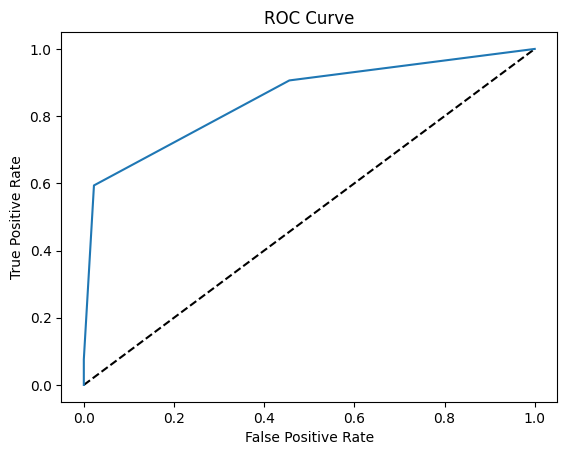

0.8512043189368771
[[1261   29]
 [  91  133]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1290
           1       0.82      0.59      0.69       224

    accuracy                           0.92      1514
   macro avg       0.88      0.79      0.82      1514
weighted avg       0.92      0.92      0.92      1514



In [176]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_k_best.predict_proba(reduced_test_anove)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_k_best.predict_proba(reduced_test_anove)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_k_best.predict(reduced_test_anove)))

# Calculate the classification report
print(classification_report(y_test, random_k_best.predict(reduced_test_anove)))

In [177]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': random_k_best.predict(X_test_after_pca_prof.loc[:,reduced_test_anove.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_rf_k_best.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
 	# 7th 3.936732 0.749565

### IDE Plots 

In [615]:
# random_rfe.fit(X_train_after_pca_cl,y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_features=1,
                       max_leaf_nodes=35, n_estimators=120, random_state=7)

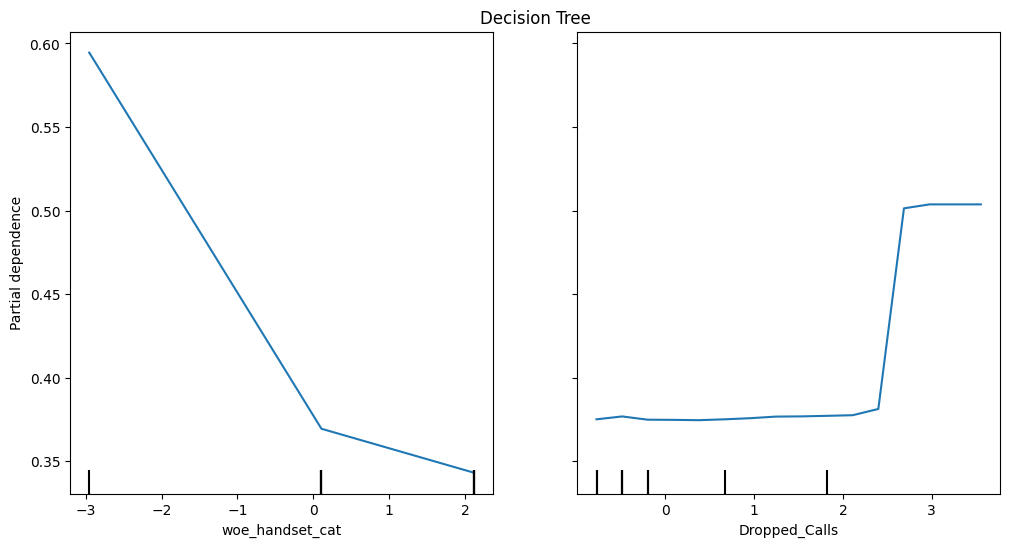

In [617]:
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.set_title("Decision Tree")
# tree_disp = PartialDependenceDisplay.from_estimator(random_rfe, X_train_after_pca_cl, ["woe_handset_cat", "Dropped_Calls"], ax=ax,response_method="predict_proba")

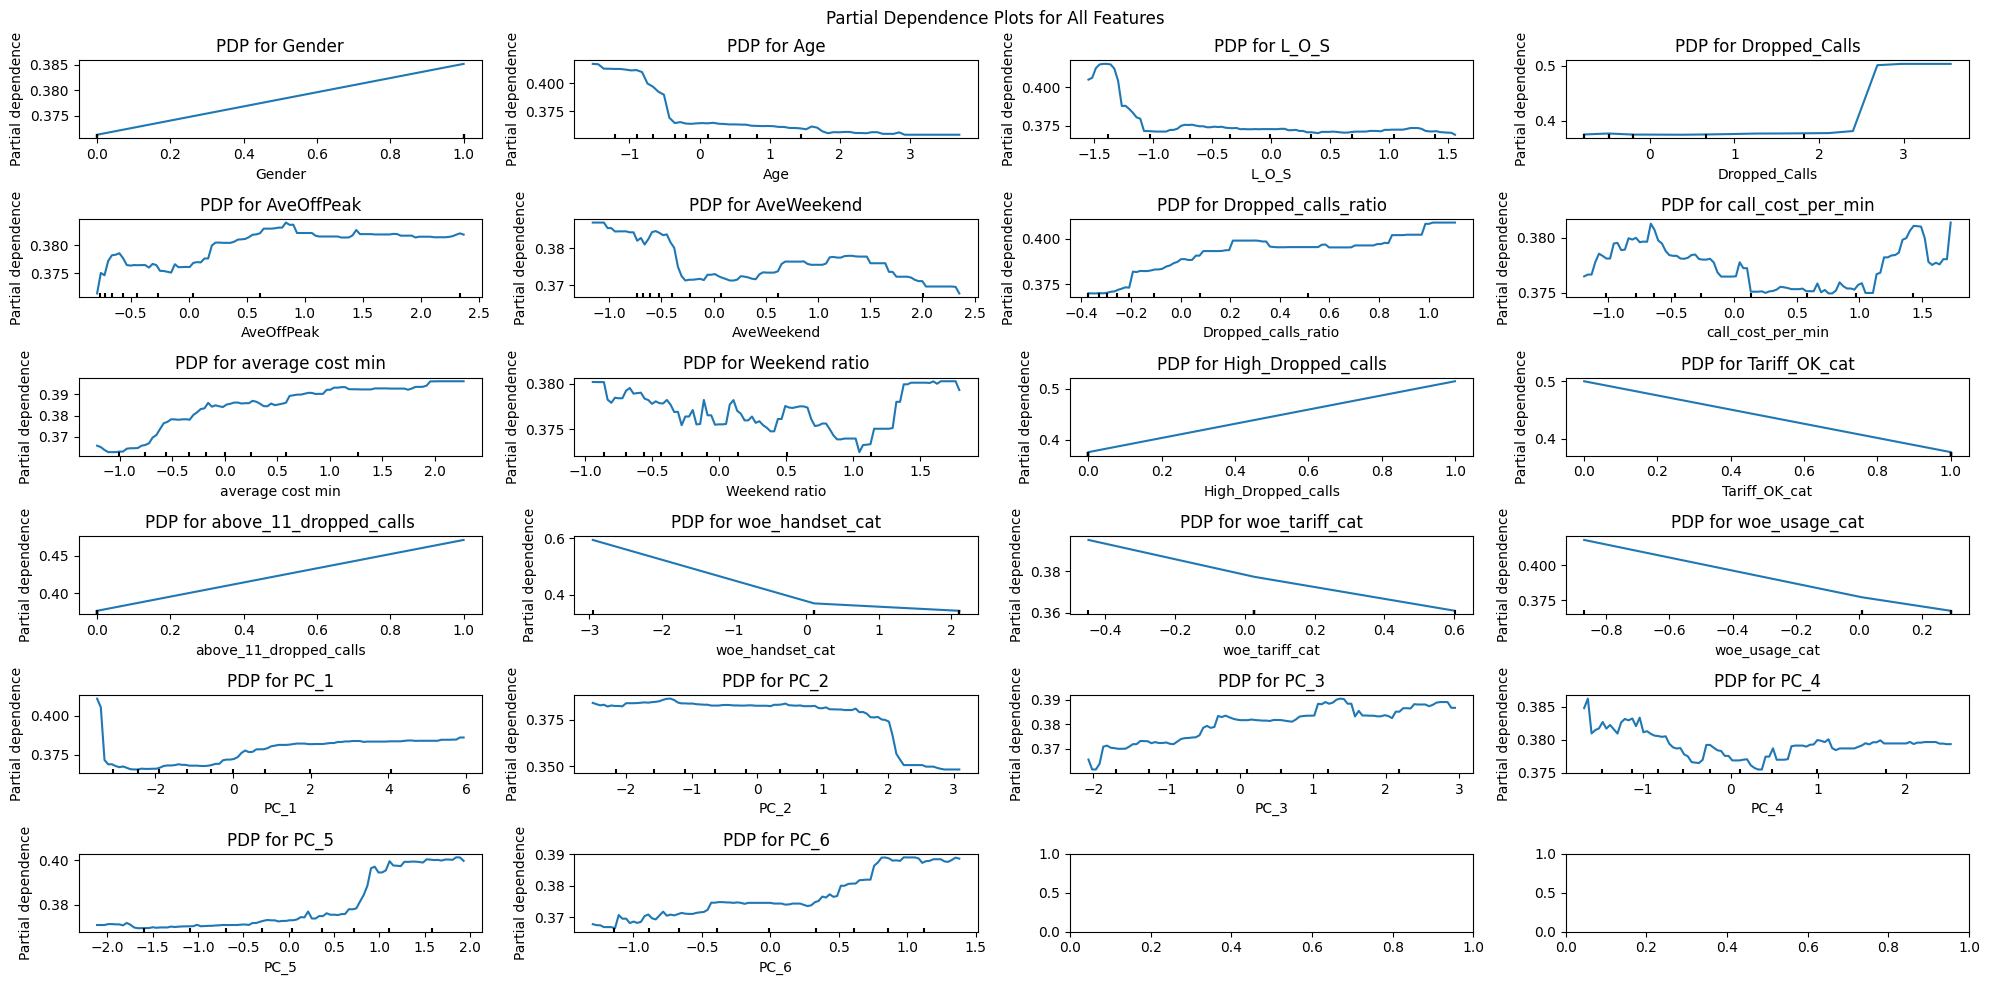

In [620]:
# fig, axs = plt.subplots(figsize=(20, 10), nrows=6, ncols=4)  # Assuming you have 12 features
# fig.suptitle('Partial Dependence Plots for All Features')

# feature_names = ['Gender', 'Age', 'L_O_S', 'Dropped_Calls', 'AveOffPeak', 'AveWeekend',
#        'Dropped_calls_ratio', 'call_cost_per_min', 'average cost min',
#        'Weekend ratio', 'High_Dropped_calls', 'Tariff_OK_cat',
#        'above_11_dropped_calls', 'woe_handset_cat', 'woe_tariff_cat',
#        'woe_usage_cat', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6']  # List all your feature names here

# for i, feature in enumerate(feature_names):
#     ax = axs[i//4, i%4]  # Calculate subplot index
#     PartialDependenceDisplay.from_estimator(random_rfe, X_train_after_pca_cl, features=[feature], ax=ax, response_method="predict_proba")
#     ax.set_title(f'PDP for {feature}')

# plt.tight_layout()
# plt.show()
# plt.show()

### SHAP Values

In [178]:
random_grid = RandomForestClassifier(bootstrap=True, max_features=1,random_state=7,criterion="gini",n_estimators=120,max_leaf_nodes=30)

In [179]:
random_grid.fit(X_train_after_pca_smote,y_train_smote)

RandomForestClassifier(max_features=1, max_leaf_nodes=30, n_estimators=120,
                       random_state=7)

PermutationExplainer explainer: 1515it [04:37,  5.32it/s]                          


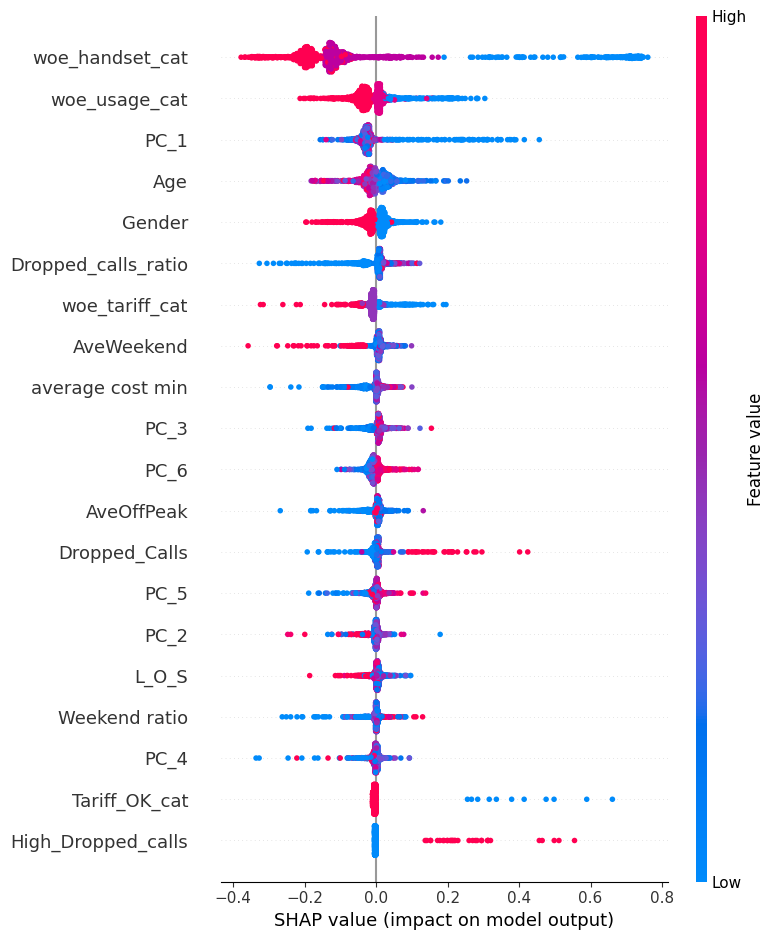

In [180]:
explainer = shap.Explainer(random_grid.predict,X_test_after_pca_cl)
shap_values = explainer(X_test_after_pca_cl)

shap.summary_plot(shap_values)

In [181]:
mean_shap_values = np.abs(shap_values.values).mean(axis=0)
mean_shap_values

array([0.02540171, 0.0279011 , 0.00917497, 0.01087577, 0.0119731 ,
       0.01664915, 0.02470608, 0.00545094, 0.01596914, 0.00882791,
       0.00771767, 0.00799598, 0.00379969, 0.1951321 , 0.01980335,
       0.04107842, 0.04074877, 0.00949922, 0.01397802, 0.00817401,
       0.01055362, 0.0132899 ])

In [182]:
shap_dict = dict(zip(X_train_after_pca_cl.columns.values, mean_shap_values))
sorted_dict = dict(sorted(shap_dict.items(), key=lambda item: item[1], reverse=True))
sorted_dict

{'woe_handset_cat': 0.19513210039630097,
 'woe_usage_cat': 0.04107841959889513,
 'PC_1': 0.04074876906448903,
 'Age': 0.027901104839678146,
 'Gender': 0.025401705296024948,
 'Dropped_calls_ratio': 0.024706076618229832,
 'woe_tariff_cat': 0.019803350546415285,
 'AveWeekend': 0.016649153356550955,
 'average cost min': 0.01596913654377322,
 'PC_3': 0.01397802329770626,
 'PC_6': 0.01328990032424643,
 'AveOffPeak': 0.011973099555662295,
 'Dropped_Calls': 0.010875765581842169,
 'PC_5': 0.010553620751771296,
 'PC_2': 0.009499219406749105,
 'L_O_S': 0.009174972979464364,
 'Weekend ratio': 0.0088279092110003,
 'PC_4': 0.00817401224930944,
 'Tariff_OK_cat': 0.007995976942476259,
 'High_Dropped_calls': 0.007717665425723531,
 'call_cost_per_min': 0.005450942716464478,
 'above_11_dropped_calls': 0.0037996877626996577}

In [183]:
X_train_shap = X_train_after_pca_smote.reindex(columns=sorted_dict.keys())

X_test_shap = X_test_after_pca_cl.reindex(columns=sorted_dict.keys())

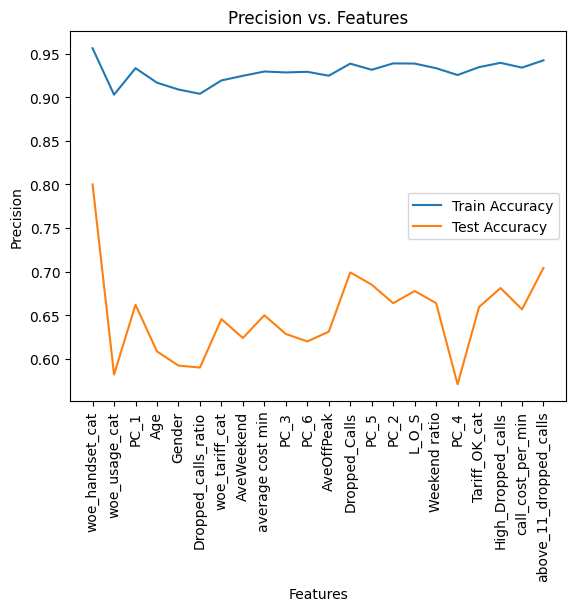

In [185]:
# Initialize lists to store error rates and number of features
train_errors = []
test_errors = []
num_features = []

# Store feature names
feature_names = X_train_shap.columns.tolist()

# Fit the model with increasing number of features
for i in range(1, X_train_shap.shape[1] + 1):
    random_grid.fit(X_train_shap.iloc[:, :i], y_train_smote)  # Fit the model with the first i features
    
    # Predictions
    y_train_pred = random_grid.predict(X_train_shap.iloc[:, :i])
    y_test_pred = random_grid.predict(X_test_shap.iloc[:, :i])
    
    # Calculate error rates
    train_error = precision_score(y_train_smote, y_train_pred)
    test_error = precision_score(y_test, y_test_pred)
    
    # Append to lists
    train_errors.append(train_error)
    test_errors.append(test_error)
    num_features.append(i)

# Plot the error rates
plt.plot(feature_names, train_errors, label='Train Accuracy')
plt.plot(feature_names, test_errors, label='Test Accuracy')
plt.xlabel('Features')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.ylabel('Precision')
plt.title('Precision vs. Features')
plt.legend()
plt.show()

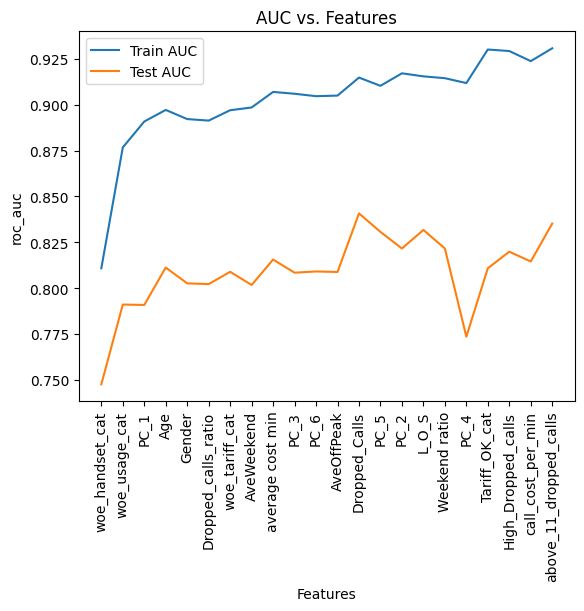

In [188]:
# Initialize lists to store error rates and number of features
train_errors = []
test_errors = []
num_features = []

# Store feature names
feature_names = X_train_shap.columns.tolist()

# Fit the model with increasing number of features
for i in range(1, X_train_shap.shape[1] + 1):
    random_grid.fit(X_train_shap.iloc[:, :i], y_train_smote)  # Fit the model with the first i features
    
    # Predictions
    y_train_pred = random_grid.predict(X_train_shap.iloc[:, :i])
    y_test_pred = random_grid.predict(X_test_shap.iloc[:, :i])
    
    # Calculate error rates
    train_error = roc_auc_score(y_train_smote, y_train_pred)
    test_error = roc_auc_score(y_test, y_test_pred)
    
    # Append to lists
    train_errors.append(train_error)
    test_errors.append(test_error)
    num_features.append(i)

# Plot the error rates
plt.plot(feature_names, train_errors, label='Train AUC')
plt.plot(feature_names, test_errors, label='Test AUC')
plt.xlabel('Features')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.ylabel('roc_auc')
plt.title('AUC vs. Features')
plt.legend()
plt.show()

In [199]:
sorted_dict

{'woe_handset_cat': 0.19513210039630097,
 'woe_usage_cat': 0.04107841959889513,
 'PC_1': 0.04074876906448903,
 'Age': 0.027901104839678146,
 'Gender': 0.025401705296024948,
 'Dropped_calls_ratio': 0.024706076618229832,
 'woe_tariff_cat': 0.019803350546415285,
 'AveWeekend': 0.016649153356550955,
 'average cost min': 0.01596913654377322,
 'PC_3': 0.01397802329770626,
 'PC_6': 0.01328990032424643,
 'AveOffPeak': 0.011973099555662295,
 'Dropped_Calls': 0.010875765581842169,
 'PC_5': 0.010553620751771296,
 'PC_2': 0.009499219406749105,
 'L_O_S': 0.009174972979464364,
 'Weekend ratio': 0.0088279092110003,
 'PC_4': 0.00817401224930944,
 'Tariff_OK_cat': 0.007995976942476259,
 'High_Dropped_calls': 0.007717665425723531,
 'call_cost_per_min': 0.005450942716464478,
 'above_11_dropped_calls': 0.0037996877626996577}

In [200]:
mask_shap = mean_shap_values > 0.07

In [201]:
shap_subset_train = X_train_after_pca_smote.loc[:,mask_shap]
shap_subset_test = X_test_after_pca_cl.loc[:,mask_shap]

In [202]:
random_grid.fit(shap_subset_train,y_train_smote)

RandomForestClassifier(max_features=1, max_leaf_nodes=30, n_estimators=120,
                       random_state=7)

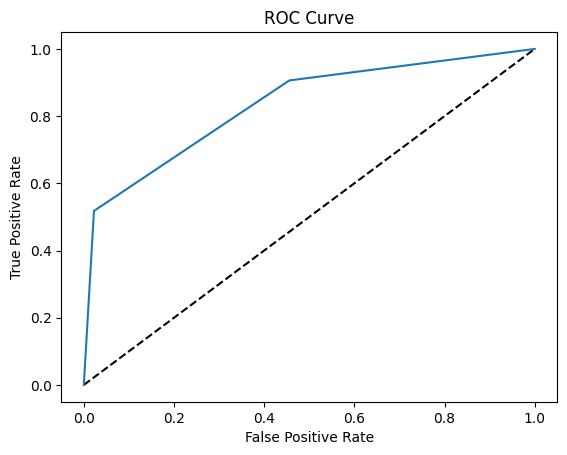

0.8330547480620154
[[1261   29]
 [ 108  116]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1290
           1       0.80      0.52      0.63       224

    accuracy                           0.91      1514
   macro avg       0.86      0.75      0.79      1514
weighted avg       0.90      0.91      0.90      1514



In [203]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_grid.predict_proba(shap_subset_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_grid.predict_proba(shap_subset_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  random_grid.predict(shap_subset_test)))

# Calculate the classification report
print(classification_report(y_test,  random_grid.predict(shap_subset_test)))

In [204]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': random_grid.predict(X_test_after_pca_prof.loc[:,shap_subset_test.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_rf_shap.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
 	# 8th 3.817858 0.728699

### Vote on the features that are selected from feature importance (rfe), forward step and IDE

array([False, False, False,  True, False, False,  True, False, False,
       False,  True, False,  True,  True, False,  True, False, False,
       False, False, False, False])

In [229]:
votes = np.sum([mask,mask_anova,mask_rfe,mask_step,mask_shap],axis=0)
print(votes)

[0 1 0 2 0 0 0 0 0 0 2 1 1 5 1 0 0 0 0 0 0 0]


In [240]:
meta_mask = votes >= 1

In [231]:
votes

array([0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 5, 1, 0, 0, 0, 0, 0, 0, 0])

In [241]:
meta_mask

array([False,  True, False,  True, False, False, False, False, False,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False])

In [242]:
reduced_vote_train = X_train_after_pca_smote.loc[:,meta_mask]
reduced_vote_test = X_test_after_pca_cl.loc[:,meta_mask]

In [243]:
reduced_vote_train.head()

Age  Dropped_Calls  High_Dropped_calls  Tariff_OK_cat  \
0 -1.522189       2.687861                   1              1   
1 -0.820099      -0.197917                   0              1   
2  1.286170      -0.486495                   0              1   
3  0.350050      -0.197917                   0              1   
4 -0.586069      -0.486495                   0              1   

   above_11_dropped_calls  woe_handset_cat  woe_tariff_cat  
0                       0        -2.954247        0.027035  
1                       0         0.108214        0.027035  
2                       0         0.108214        0.027035  
3                       0         2.114110       -0.448237  
4                       0         2.114110        0.027035

In [244]:
random_vote = RandomForestClassifier(bootstrap=True,random_state=7)

grid_param = {
    "n_estimators" : [50,70,100,120,150,180,200],
    'criterion': ['gini','entropy'],
   # 'class_weight' : ["balanced", "balanced_subsample"],
    'max_features' : [1,2,"log2","sqrt"]
}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

random_searcher = GridSearchCV(random_vote, grid_param, scoring="precision")
random_searcher.fit(reduced_vote_train, y_train_smote)


GridSearchCV(estimator=RandomForestClassifier(random_state=7),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [1, 2, 'log2', 'sqrt'],
                         'n_estimators': [50, 70, 100, 120, 150, 180, 200]},
             scoring='precision')

In [245]:
random_searcher.best_params_

{'criterion': 'gini', 'max_features': 2, 'n_estimators': 180}

In [246]:
random_rf_vote = RandomForestClassifier(bootstrap=True, max_features=2,random_state=7,criterion="gini",n_estimators=180)

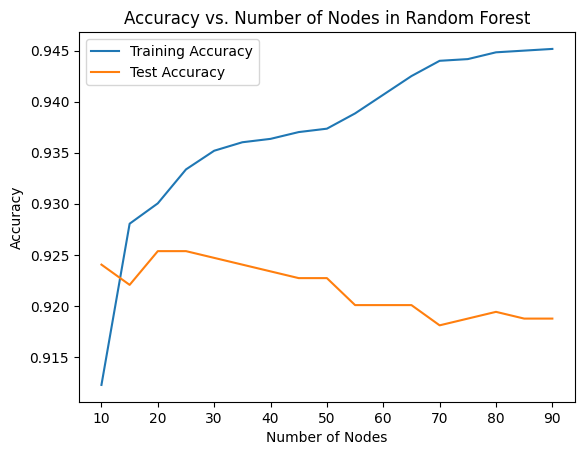

In [247]:
# Define a range of values for the number of nodes
node_values = [10,15,20,25,30,35,40,45,50,55,65,70,75,80,85,90]  # Adjust this range as needed

# Initialize lists to store accuracy values
train_accuracies = []
test_accuracies = []

# Train Random Forest models with different numbers of nodes
for num_nodes in node_values:
    # Create and fit Random Forest model
    rf_model = RandomForestClassifier(bootstrap=True, max_features=2,random_state=7,criterion="gini",n_estimators=180, max_leaf_nodes=num_nodes)
    rf_model.fit(reduced_vote_train, y_train_smote)
    #RandomForestClassifier(bootstrap=True, max_features="log2", random_state=45, class_weight="balanced")
    # Predict on training and test data
    train_preds = rf_model.predict(reduced_vote_train)
    test_preds = rf_model.predict(reduced_vote_test)
    
    # Calculate accuracy and append to lists
    train_accuracy = accuracy_score(y_train_smote, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(node_values, train_accuracies, label='Training Accuracy')
plt.plot(node_values, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Nodes in Random Forest')
plt.legend()
plt.show()

In [248]:
random_rf_vote = RandomForestClassifier(bootstrap=True, max_features=2,random_state=7,criterion="gini",n_estimators=180, max_leaf_nodes=20)

In [249]:
random_rf_vote.fit(reduced_vote_train,y_train_smote)

RandomForestClassifier(max_features=2, max_leaf_nodes=20, n_estimators=180,
                       random_state=7)

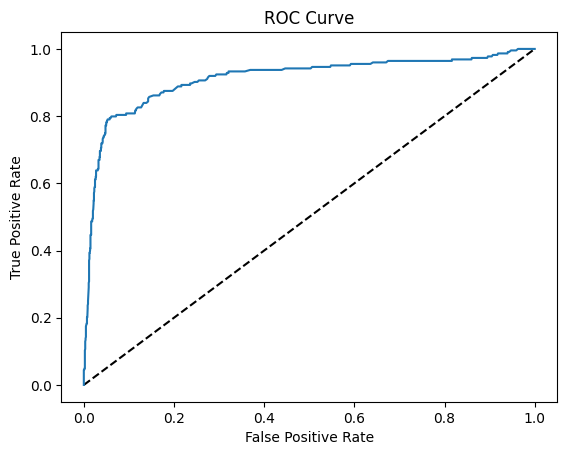

0.9118805370985603
[[1228   62]
 [  51  173]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1290
           1       0.74      0.77      0.75       224

    accuracy                           0.93      1514
   macro avg       0.85      0.86      0.85      1514
weighted avg       0.93      0.93      0.93      1514



In [250]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, random_rf_vote.predict_proba(reduced_vote_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, random_rf_vote.predict_proba(reduced_vote_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, random_rf_vote.predict(reduced_vote_test)))

# Calculate the classification report
print(classification_report(y_test, random_rf_vote.predict(reduced_vote_test)))

In [251]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': random_rf_vote.predict(X_test_after_pca_prof.loc[:,reduced_vote_test.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_rf_vote_2.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
# 	7th 3.936732 0.749565
# 	8th 3.826936 0.848799
#

# Logistic with smote and with weight 

## Logistic (smote) with Lasso Regularization (for feature selection) and Grid Search 

In [530]:
X_train_after_pca_smote.head()

Gender       Age     L_O_S  Dropped_Calls  AveOffPeak  AveWeekend  \
0       1 -1.522189  0.023503       2.687861   -0.727825    1.731495   
1       1 -0.820099  0.471394      -0.197917    0.480156   -0.631000   
2       1  1.286170 -0.019154      -0.486495   -0.652128   -0.606012   
3       0  0.350050  0.431107      -0.197917   -0.720805    2.353171   
4       0 -0.586069  0.800795      -0.486495    0.489820   -0.117198   

   Dropped_calls_ratio  call_cost_per_min  average cost min  Weekend ratio  \
0             0.140007          -1.134484         -0.314921       0.378521   
1            -0.217394           0.509602          0.510814      -0.588895   
2            -0.323024           2.106205          0.465716      -0.649550   
3            -0.149255          -0.186036          0.495136       0.133705   
4            -0.317174          -0.806504          0.225589       0.837444   

   High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  woe_handset_cat  \
0                   1              1                       0        -2.954247   
1                   0              1                       0         0.108214   
2                   0              1                       0         0.108214   
3                   0              1                       0         2.114110   
4                   0              1                       0         2.114110   

   woe_tariff_cat  woe_usage_cat      PC_1      PC_2      PC_3      PC_4  \
0        0.027035       0.289711 -0.614796  1.217934 -1.830216  0.286092   
1        0.027035       0.289711 -0.758775 -0.400732 -0.894722 -0.860130   
2        0.027035       0.289711  0.950486 -2.497942 -1.946074 -0.832964   
3       -0.448237       0.289711 -2.646538  2.096460  0.240503 -0.833572   
4        0.027035       0.289711  0.407168 -0.176704 -0.759885  2.420086   

       PC_5      PC_6  
0 -0.624709 -0.983982  
1  0.749651  0.767275  
2  0.697511  0.428025  
3  1.151226  1.081384  
4  1.547001 -0.783275

In [531]:
# Specify L1 regularization
#liblinear is the optimization method used to estimate the coefficients. liblinear is need for l1
lr = LogisticRegression(solver='liblinear', penalty="l1",random_state=8) 

param_grid = {
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],

}

scoring = {"Precision": "precision", "Profit": profit_scorer}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

# Instantiate the GridSearchCV object and run the search
# The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
searcher_lasso = GridSearchCV(lr, param_grid, cv=kf, scoring=scoring,refit="Precision")
searcher_lasso.fit(X_train_after_pca_smote, y_train_smote)


GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=8,
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit='Precision',
             scoring={'Precision': 'precision',
                      'Profit': make_scorer(calculate_profit_metric_2, response_method='predict_proba')})

In [532]:
searcher_lasso.best_params_

{'C': 0.001}

In [122]:
lr = LogisticRegression(solver='liblinear', penalty="l1",random_state=8,C=0.001) 
lr.fit(X_train_after_pca_smote,y_train_smote)

LogisticRegression(C=0.001, penalty='l1', random_state=8, solver='liblinear')

In [123]:
lr.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.61118591,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [124]:
mask_lasso = abs(lr.coef_) > 0.24
mask_lasso.shape
mask_lasso = mask_lasso[0]
mask_lasso

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False])

In [125]:
reduced_train_lasso= X_train_after_pca_smote.loc[:,mask_lasso]
reduced_test_lasso = X_test_after_pca_cl.loc[:,mask_lasso]
reduced_train_lasso.head()

woe_handset_cat
0        -2.954247
1         0.108214
2         0.108214
3         2.114110
4         2.114110

In [537]:
lr.fit(reduced_train_lasso,y_train_smote)

LogisticRegression(C=0.001, penalty='l1', random_state=8, solver='liblinear')

In [538]:
calculate_profit_metric_2(y_test,lr.predict_proba(reduced_test_lasso)[:,1])

4.0524467884764785

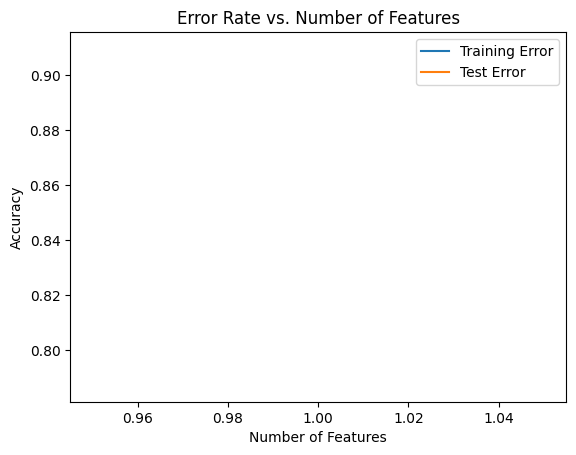

In [539]:
# Initialize lists to store error rates and number of features
train_errors = []
test_errors = []
num_features = []

# Fit the model with increasing number of features
for i in range(1, reduced_train_lasso.shape[1] + 1):
    lr.fit(reduced_train_lasso.iloc[:, :i], y_train_smote)  # Fit the model with the first i features
    
    # Predictions
    y_train_pred = lr.predict(reduced_train_lasso.iloc[:, :i])
    y_test_pred = lr.predict(reduced_test_lasso.iloc[:, :i])
    
    # Calculate error rates
    train_error = accuracy_score(y_train_smote, y_train_pred)
    test_error = accuracy_score(y_test, y_test_pred)
    
    # Append to lists
    train_errors.append(train_error)
    test_errors.append(test_error)
    num_features.append(i)

# Plot the error rates
plt.plot(num_features, train_errors, label='Training Error')
plt.plot(num_features, test_errors, label='Test Error')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Error Rate vs. Number of Features')
plt.legend()
plt.show()

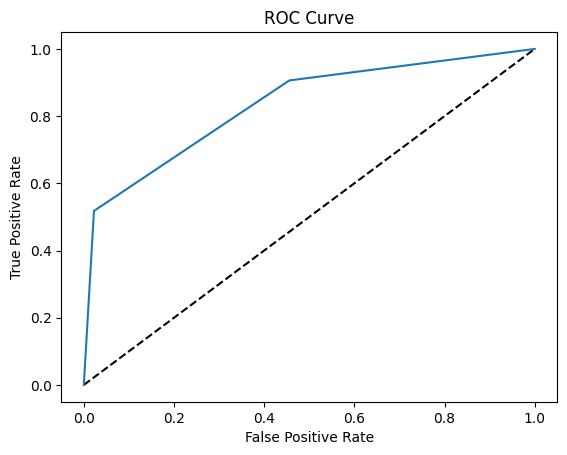

0.8330547480620154
[[1261   29]
 [ 108  116]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1290
           1       0.80      0.52      0.63       224

    accuracy                           0.91      1514
   macro avg       0.86      0.75      0.79      1514
weighted avg       0.90      0.91      0.90      1514



In [540]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(reduced_test_lasso)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, lr.predict_proba(reduced_test_lasso)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  lr.predict(reduced_test_lasso)))

# Calculate the classification report
print(classification_report(y_test,  lr.predict(reduced_test_lasso)))

In [541]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': lr.predict(X_test_after_pca_prof.loc[:,reduced_test_lasso.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_lr_lasso.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
# Result in Dashboard: 8th: 3.817858 0.728699

### RFE with Logistic on Ridge Regularization (default)

In [126]:
# Create RFECV estimator
rfecv = RFECV(LogisticRegression(random_state=8),cv=kf, scoring="precision")

param_grid = {
    'estimator__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
   # 'min_features_to_select' : [1,2,3,4,5,6,7,8,9,10]
}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

grid_search_rfe_lr = GridSearchCV(rfecv, param_grid, cv=kf, scoring="precision")

grid_search_rfe_lr.fit(X_train_after_pca_smote, y_train_smote)

GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RFECV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                             estimator=LogisticRegression(random_state=8),
                             scoring='precision'),
             param_grid={'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='precision')

In [127]:
grid_search_rfe_lr.best_params_


{'estimator__C': 0.01}

In [128]:
mask_rfe_lr = grid_search_rfe_lr.best_estimator_.get_support()
mask_rfe_lr

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False])

In [129]:
reduced_train_rfe_lr = X_train_after_pca_smote.loc[:,mask_rfe_lr]
reduced_test_rfe_lr = X_test_after_pca_cl.loc[:,mask_rfe_lr]

In [130]:
reduced_train_rfe_lr.head()

Tariff_OK_cat  woe_handset_cat
0              1        -2.954247
1              1         0.108214
2              1         0.108214
3              1         2.114110
4              1         2.114110

In [547]:
lr_rfe = LogisticRegression(random_state=8, C=0.01)
lr_rfe.fit(reduced_train_rfe_lr,y_train_smote)

LogisticRegression(C=0.01, random_state=8)

In [548]:
calculate_profit_metric_2(y_test,lr_rfe.predict_proba(reduced_test_rfe_lr)[:,1])

1.5772962482377246

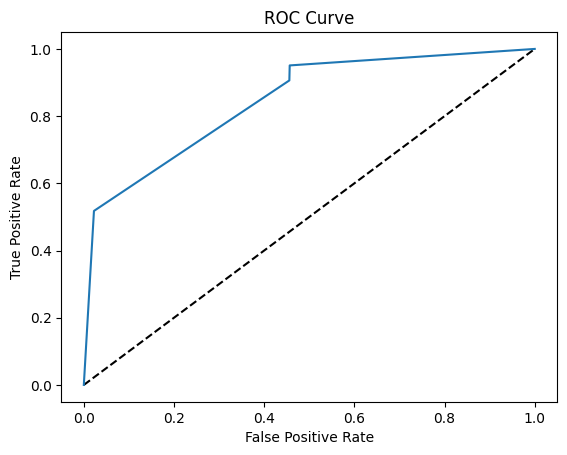

0.8451654208194905
[[1261   29]
 [ 108  116]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1290
           1       0.80      0.52      0.63       224

    accuracy                           0.91      1514
   macro avg       0.86      0.75      0.79      1514
weighted avg       0.90      0.91      0.90      1514



In [549]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr_rfe.predict_proba(reduced_test_rfe_lr)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, lr_rfe.predict_proba(reduced_test_rfe_lr)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  lr_rfe.predict(reduced_test_rfe_lr)))

# Calculate the classification report
print(classification_report(y_test,  lr_rfe.predict(reduced_test_rfe_lr)))

In [550]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': lr_rfe.predict(X_test_after_pca_prof.loc[:,reduced_test_rfe_lr.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_lr_rfecv.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
# Position on Scoreboard: 8th 3.817858 0.728699

### Step Forward Feature Selection

In [131]:
# Specify L2 regularization
#liblinear is the optimization method used to estimate the coefficients. liblinear is need for l1

lr = LogisticRegression(random_state=8)

pipeline = Pipeline(
    [
     ('selector',SequentialFeatureSelector(lr,cv=kf,scoring="precision")),
     ('model',lr)
    ]
)

param_grid = {
    'model__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'selector__n_features_to_select' : [1,2,3,4,5,6,7,8]

}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

# Instantiate the GridSearchCV object and run the search
# The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
searcher_ridge = GridSearchCV(pipeline, param_grid, cv=kf, scoring="precision")
searcher_ridge.fit(X_train_after_pca_smote, y_train_smote)


c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=Pipeline(steps=[('selector',
                                        SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                                                                  estimator=LogisticRegression(random_state=8),
                                                                  scoring='precision')),
                                       ('model',
                                        LogisticRegression(random_state=8))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'selector__n_features_to_select': [1, 2, 3, 4, 5, 6, 7,
                                                            8]},
             scoring='precision')

In [132]:
searcher_ridge.best_params_

{'model__C': 0.1, 'selector__n_features_to_select': 5}

In [133]:
mask_step_ridge = searcher_ridge.best_estimator_.named_steps['selector'].support_
mask_step_ridge

array([False, False, False, False,  True,  True, False, False, False,
       False,  True, False,  True,  True, False, False, False, False,
       False, False, False, False])

In [134]:
reduced_train_ridge_step = X_train_after_pca_smote.loc[:,mask_step_ridge]
reduced_test_ridge_step = X_test_after_pca_cl.loc[:,mask_step_ridge]
reduced_train_ridge_step.head()

AveOffPeak  AveWeekend  High_Dropped_calls  above_11_dropped_calls  \
0   -0.727825    1.731495                   1                       0   
1    0.480156   -0.631000                   0                       0   
2   -0.652128   -0.606012                   0                       0   
3   -0.720805    2.353171                   0                       0   
4    0.489820   -0.117198                   0                       0   

   woe_handset_cat  
0        -2.954247  
1         0.108214  
2         0.108214  
3         2.114110  
4         2.114110

In [555]:
lr_step = LogisticRegression(random_state=8, C=0.1)
lr_step.fit(reduced_train_ridge_step,y_train_smote)

LogisticRegression(C=0.1, random_state=8)

In [556]:
calculate_profit_metric_2(y_test,lr_step.predict_proba(reduced_test_ridge_step)[:,1])

-5.115383074149731

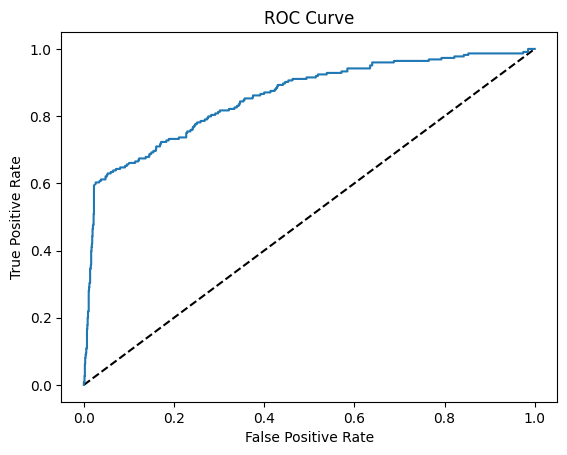

0.856466292912514
[[1261   29]
 [  91  133]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1290
           1       0.82      0.59      0.69       224

    accuracy                           0.92      1514
   macro avg       0.88      0.79      0.82      1514
weighted avg       0.92      0.92      0.92      1514



In [557]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr_step.predict_proba(reduced_test_ridge_step)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, lr_step.predict_proba(reduced_test_ridge_step)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  lr_step.predict(reduced_test_ridge_step)))

# Calculate the classification report
print(classification_report(y_test,  lr_step.predict(reduced_test_ridge_step)))

In [558]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': lr_step.predict(X_test_after_pca_prof.loc[:,reduced_test_ridge_step.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_lr_step.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
#  7th at Scoreboard:	3.936732 0.749565

### SHAP values

In [559]:
# Specify L1 regularization
#liblinear is the optimization method used to estimate the coefficients. liblinear is need for l1

lr = LogisticRegression(random_state=8)

param_grid = {
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]

}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

# Instantiate the GridSearchCV object and run the search
# The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
searcher_ridge = GridSearchCV(lr, param_grid, cv=kf, scoring="precision")
searcher_ridge.fit(X_train_after_pca_smote, y_train_smote)

GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(random_state=8),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='precision')

In [560]:
searcher_ridge.best_params_

{'C': 10}

In [135]:
lr_ridge = LogisticRegression(random_state=8, C=10)
lr_ridge.fit(X_train_after_pca_smote,y_train_smote)

LogisticRegression(C=10, random_state=8)

PermutationExplainer explainer: 1515it [00:24, 35.74it/s]                          


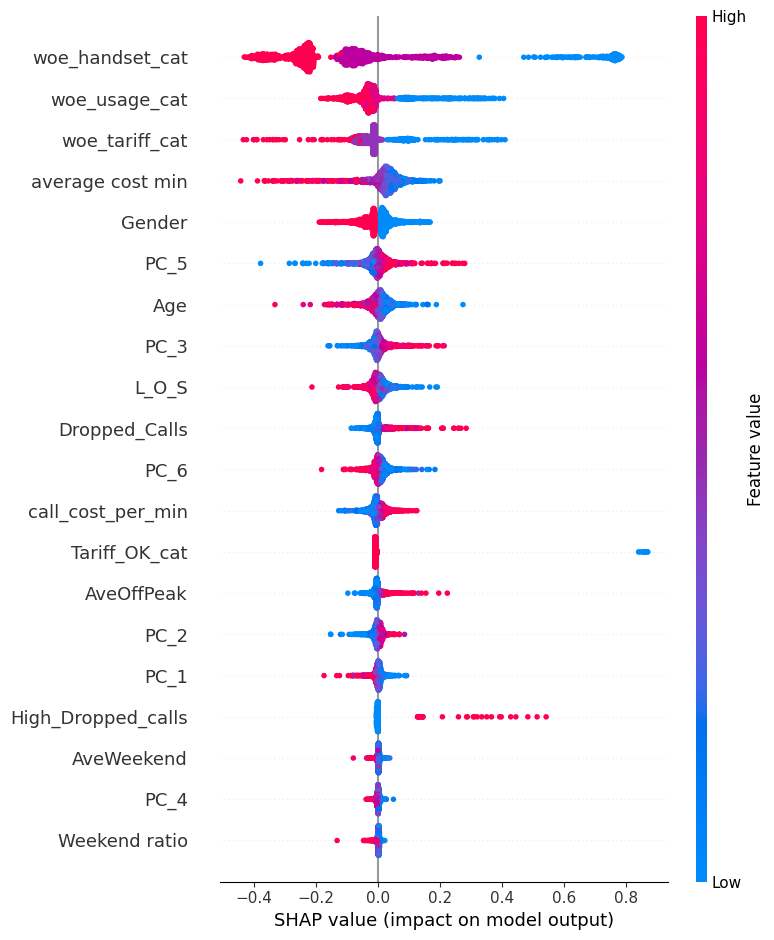

In [136]:
explainer = shap.Explainer(lr_ridge.predict,X_test_after_pca_cl)
shap_values = explainer(X_test_after_pca_cl)

shap.summary_plot(shap_values)

In [137]:
mean_shap_values = np.abs(shap_values.values).mean(axis=0)
mean_shap_values

array([0.0356521 , 0.0259232 , 0.01854029, 0.01746938, 0.01244055,
       0.00342951, 0.001971  , 0.01663774, 0.05021256, 0.00309715,
       0.00698781, 0.01531494, 0.0003966 , 0.2328918 , 0.05590669,
       0.06140927, 0.00984478, 0.01071334, 0.02050048, 0.00342921,
       0.02945749, 0.01686982])

In [138]:
shap_dict = dict(zip(X_train_after_pca_cl.columns.values, mean_shap_values))
sorted_dict = dict(sorted(shap_dict.items(), key=lambda item: item[1], reverse=True))
sorted_dict

{'woe_handset_cat': 0.23289179776630256,
 'woe_usage_cat': 0.06140927104599497,
 'woe_tariff_cat': 0.05590668908370368,
 'average cost min': 0.050212561546775565,
 'Gender': 0.035652095592650423,
 'PC_5': 0.029457487690644858,
 'Age': 0.02592320163324123,
 'PC_3': 0.020500480365077428,
 'L_O_S': 0.018540290620871844,
 'Dropped_Calls': 0.017469376726311964,
 'PC_6': 0.016869821064008618,
 'call_cost_per_min': 0.016637744685961305,
 'Tariff_OK_cat': 0.015314939353909093,
 'AveOffPeak': 0.012440554821664463,
 'PC_2': 0.010713342140026384,
 'PC_1': 0.009844782034346076,
 'High_Dropped_calls': 0.006987810736159451,
 'AveWeekend': 0.0034295064248829163,
 'PC_4': 0.0034292061967095035,
 'Weekend ratio': 0.0030971538369160734,
 'Dropped_calls_ratio': 0.0019709979584484416,
 'above_11_dropped_calls': 0.00039660141707697805}

In [139]:
X_train_shap = X_train_after_pca_smote.reindex(columns=sorted_dict.keys())

X_test_shap = X_test_after_pca_cl.reindex(columns=sorted_dict.keys())

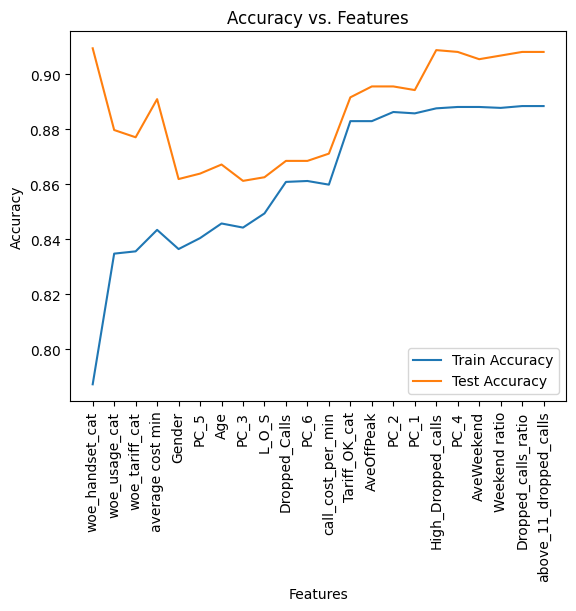

In [566]:
# Initialize lists to store error rates and number of features
train_errors = []
test_errors = []
num_features = []

# Store feature names
feature_names = X_train_shap.columns.tolist()

# Fit the model with increasing number of features
for i in range(1, X_train_shap.shape[1] + 1):
    lr_ridge.fit(X_train_shap.iloc[:, :i], y_train_smote)  # Fit the model with the first i features
    
    # Predictions
    y_train_pred = lr_ridge.predict(X_train_shap.iloc[:, :i])
    y_test_pred = lr_ridge.predict(X_test_shap.iloc[:, :i])
    
    # Calculate error rates
    train_error = accuracy_score(y_train_smote, y_train_pred)
    test_error = accuracy_score(y_test, y_test_pred)
    
    # Append to lists
    train_errors.append(train_error)
    test_errors.append(test_error)
    num_features.append(i)

# Plot the error rates
plt.plot(feature_names, train_errors, label='Train Accuracy')
plt.plot(feature_names, test_errors, label='Test Accuracy')
plt.xlabel('Features')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Features')
plt.legend()
plt.show()

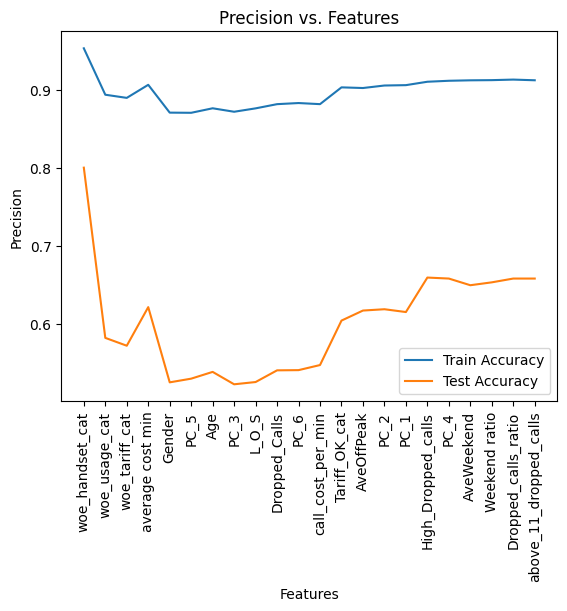

In [567]:
# Initialize lists to store error rates and number of features
train_errors = []
test_errors = []
num_features = []

# Store feature names
feature_names = X_train_shap.columns.tolist()

# Fit the model with increasing number of features
for i in range(1, X_train_shap.shape[1] + 1):
    lr_ridge.fit(X_train_shap.iloc[:, :i], y_train_smote)  # Fit the model with the first i features
    
    # Predictions
    y_train_pred = lr_ridge.predict(X_train_shap.iloc[:, :i])
    y_test_pred = lr_ridge.predict(X_test_shap.iloc[:, :i])
    
    # Calculate error rates
    train_error = precision_score(y_train_smote, y_train_pred)
    test_error = precision_score(y_test, y_test_pred)
    
    # Append to lists
    train_errors.append(train_error)
    test_errors.append(test_error)
    num_features.append(i)

# Plot the error rates
plt.plot(feature_names, train_errors, label='Train Accuracy')
plt.plot(feature_names, test_errors, label='Test Accuracy')
plt.xlabel('Features')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.ylabel('Precision')
plt.title('Precision vs. Features')
plt.legend()
plt.show()

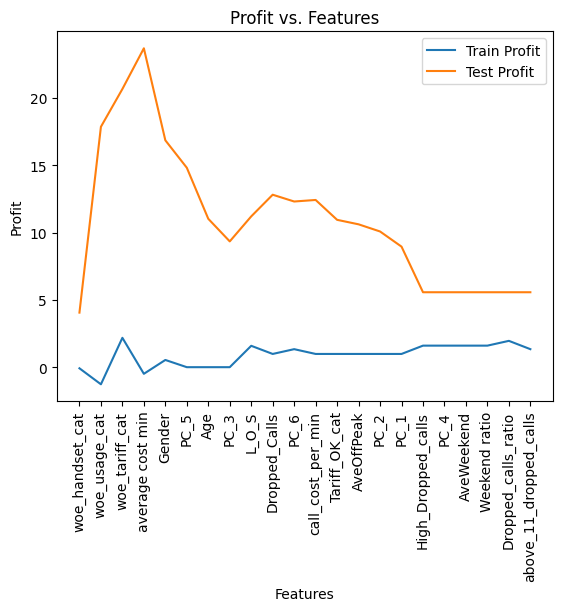

In [568]:
# Initialize lists to store error rates and number of features
train_errors = []
test_errors = []
num_features = []

# Store feature names
feature_names = X_train_shap.columns.tolist()

# Fit the model with increasing number of features
for i in range(1, X_train_shap.shape[1] + 1):
    lr_ridge.fit(X_train_shap.iloc[:, :i], y_train_smote)  # Fit the model with the first i features
    
    # Predictions
    y_train_pred = lr_ridge.predict(X_train_shap.iloc[:, :i])
    y_test_pred = lr_ridge.predict(X_test_shap.iloc[:, :i])

    y_train_prob = lr_ridge.predict_proba(X_train_shap.iloc[:, :i])[:,1]
    y_test_prob = lr_ridge.predict_proba(X_test_shap.iloc[:, :i])[:,1]
    
    # Calculate error rates
    train_error = calculate_profit_metric_2(y_train_smote,y_train_prob)
    test_error = calculate_profit_metric_2(y_test, y_test_prob)
    
    # Append to lists
    train_errors.append(train_error)
    test_errors.append(test_error)
    num_features.append(i)

# Plot the error rates
plt.plot(feature_names, train_errors, label='Train Profit')
plt.plot(feature_names, test_errors, label='Test Profit')
plt.xlabel('Features')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.ylabel('Profit')
plt.title('Profit vs. Features')
plt.legend()
plt.show()

In [569]:
sorted_dict

{'woe_handset_cat': 0.23242764501020813,
 'woe_usage_cat': 0.0618307914014652,
 'woe_tariff_cat': 0.055209559265041466,
 'average cost min': 0.05014230815419716,
 'Gender': 0.03533805692326165,
 'PC_5': 0.029287858772667187,
 'Age': 0.02577789119730994,
 'PC_3': 0.020286117449261423,
 'L_O_S': 0.01875615467755493,
 'Dropped_Calls': 0.01757956046595407,
 'PC_6': 0.0169601897442056,
 'call_cost_per_min': 0.016668067731475934,
 'Tariff_OK_cat': 0.01532514711180509,
 'AveOffPeak': 0.012508706617028926,
 'PC_2': 0.010655698330731348,
 'PC_1': 0.009828569712981843,
 'High_Dropped_calls': 0.00722138825507383,
 'PC_4': 0.0033838717425243177,
 'AveWeekend': 0.003366758736639851,
 'Weekend ratio': 0.003004383331331826,
 'Dropped_calls_ratio': 0.002122913414194807,
 'above_11_dropped_calls': 0.0003740843040710932}

In [140]:
mask_shap = mean_shap_values > 0.07

In [141]:
shap_subset_train = X_train_after_pca_smote.loc[:,mask_shap]
shap_subset_test = X_test_after_pca_cl.loc[:,mask_shap]

In [142]:
shap_subset_train.head()


woe_handset_cat
0        -2.954247
1         0.108214
2         0.108214
3         2.114110
4         2.114110

In [574]:
lr_ridge.fit(shap_subset_train,y_train_smote)

LogisticRegression(C=10, random_state=8)

In [575]:
calculate_profit_metric_2(y_test, lr_ridge.predict_proba(shap_subset_test)[:,1])

4.0524467884764785

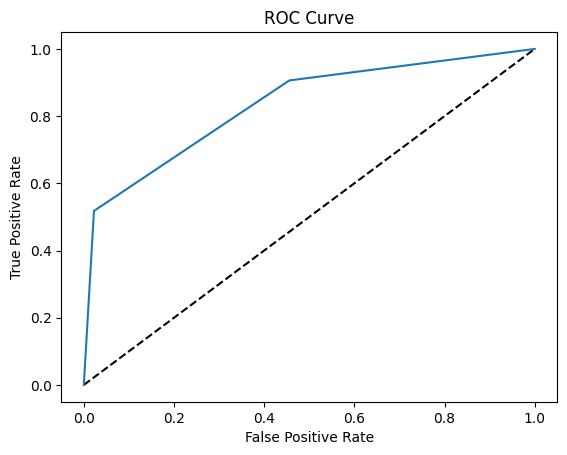

0.8330547480620154
[[1261   29]
 [ 108  116]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1290
           1       0.80      0.52      0.63       224

    accuracy                           0.91      1514
   macro avg       0.86      0.75      0.79      1514
weighted avg       0.90      0.91      0.90      1514



In [576]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr_ridge.predict_proba(shap_subset_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, lr_ridge.predict_proba(shap_subset_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  lr_ridge.predict(shap_subset_test)))

# Calculate the classification report
print(classification_report(y_test,  lr_ridge.predict(shap_subset_test)))

In [577]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': lr_ridge.predict(X_test_after_pca_prof.loc[:,shap_subset_test.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_lr_shap.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
# 	8th position on the Scoreboard: 3.817858 0.728699

### K-Best

In [143]:
lr_k_best = LogisticRegression(random_state=9)

In [144]:
# Specify L2 regularization
#liblinear is the optimization method used to estimate the coefficients. liblinear is need for l1

lr_k_best = LogisticRegression(random_state=9)

pipeline = Pipeline(
    [
     ('selector',SelectKBest(f_regression)),
     ('model',lr_k_best)
    ]
)

param_grid = {
    'model__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'selector__k' : [1,2,3,4,5,6,7,8,9,10]

}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

# Instantiate the GridSearchCV object and run the search
# The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
searcher_k_best = GridSearchCV(pipeline, param_grid, cv=kf, scoring="precision")
searcher_k_best.fit(X_train_after_pca_smote, y_train_smote)


GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=Pipeline(steps=[('selector',
                                        SelectKBest(score_func=<function f_regression at 0x0000021CB28224D0>)),
                                       ('model',
                                        LogisticRegression(random_state=9))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'selector__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='precision')

In [145]:
searcher_k_best.best_params_

{'model__C': 10, 'selector__k': 2}

In [146]:
mask_k_best = searcher_k_best.best_estimator_.named_steps['selector'].get_support()
mask_k_best

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False])

In [147]:
reduced_train_k_best = X_train_after_pca_smote.loc[:,mask_k_best]
reduced_test_k_best = X_test_after_pca_cl.loc[:,mask_k_best]

In [583]:
lr_k_best = LogisticRegression(random_state=9,C=10)
lr_k_best.fit(reduced_train_k_best,y_train_smote)

LogisticRegression(C=10, random_state=9)

In [584]:
calculate_profit_metric_2(y_test, lr_k_best.predict_proba(reduced_test_k_best)[:,1])

0.419008813993508

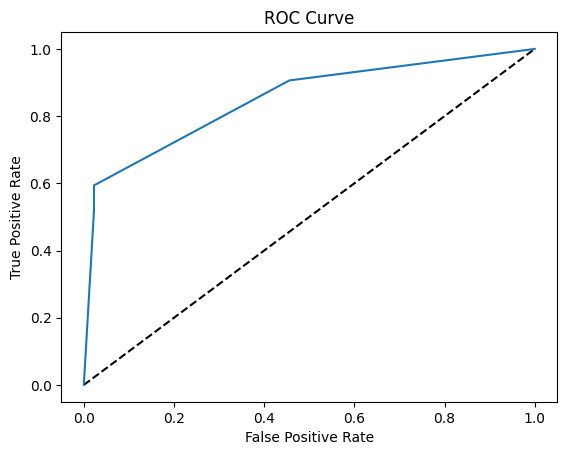

0.8494982004429679
[[1261   29]
 [  91  133]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1290
           1       0.82      0.59      0.69       224

    accuracy                           0.92      1514
   macro avg       0.88      0.79      0.82      1514
weighted avg       0.92      0.92      0.92      1514



In [585]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr_k_best.predict_proba(reduced_test_k_best)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, lr_k_best.predict_proba(reduced_test_k_best)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  lr_k_best.predict(reduced_test_k_best)))

# Calculate the classification report
print(classification_report(y_test,  lr_k_best.predict(reduced_test_k_best)))

In [586]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': lr_k_best.predict(X_test_after_pca_prof.loc[:,reduced_test_k_best.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_lr_k_best.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
# 7th position at Scoreboard: 3.936732 0.749565

### Vote on the features from all feature selection methods

In [148]:
votes = np.sum([mask_lasso,mask_rfe_lr,mask_step_ridge,mask_shap,mask_k_best],axis=0)
print(votes)

[0 0 0 0 1 1 0 0 0 0 2 1 1 5 0 0 0 0 0 0 0 0]


In [149]:
meta_mask_lr = votes > 1

In [150]:
meta_mask_lr

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False])

In [151]:
reduced_vote_train = X_train_after_pca_smote.loc[:,meta_mask_lr]
reduced_vote_test = X_test_after_pca_cl.loc[:,meta_mask_lr]

In [152]:
reduced_vote_train.head()

High_Dropped_calls  woe_handset_cat
0                   1        -2.954247
1                   0         0.108214
2                   0         0.108214
3                   0         2.114110
4                   0         2.114110

In [153]:
lr_ridge = LogisticRegression(random_state=8, C=10)
lr_ridge.fit(reduced_vote_train,y_train_smote)

LogisticRegression(C=10, random_state=8)

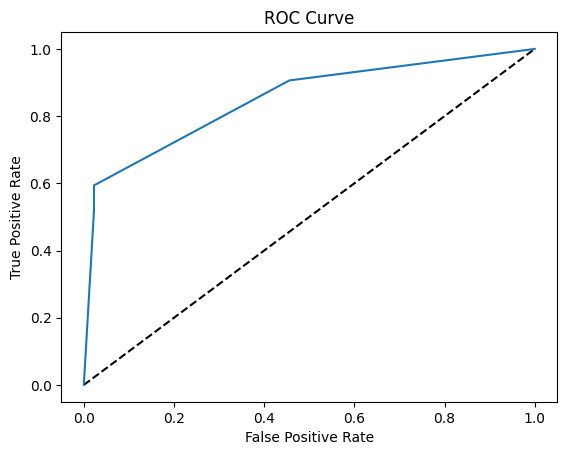

0.8494982004429679
[[1261   29]
 [  91  133]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1290
           1       0.82      0.59      0.69       224

    accuracy                           0.92      1514
   macro avg       0.88      0.79      0.82      1514
weighted avg       0.92      0.92      0.92      1514



In [154]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr_ridge.predict_proba(reduced_vote_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, lr_ridge.predict_proba(reduced_vote_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  lr_ridge.predict(reduced_vote_test)))

# Calculate the classification report
print(classification_report(y_test,  lr_ridge.predict(reduced_vote_test)))

In [602]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': lr_ridge.predict(X_test_after_pca_prof.loc[:,reduced_vote_test.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_lr_vote_2.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
# 7th 3.936732 0.766694 meta_mask_lr = votes >=1
# 7th 3.936732 0.749565 meta_mask_lr = votes > 1

# KNN - K-Nearest Neighbors

### Grid Search

In [253]:
knn = KNeighborsClassifier()

grid_param = {
    "weights" : ["uniform","distance"],
    "n_neighbors" : [3,4,5,6],
    "algorithm" : ["auto"]
}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

knn_searcher = GridSearchCV(knn, grid_param, scoring="precision")
knn_searcher.fit(X_train_after_pca_smote, y_train_smote)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 4, 5, 6],
                         'weights': ['uniform', 'distance']},
             scoring='precision')

In [255]:
knn_searcher.best_params_

{'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'uniform'}

In [259]:
knn = KNeighborsClassifier(algorithm="auto",n_neighbors=4,weights="uniform")
knn.fit(X_train_after_pca_smote,y_train_smote)

KNeighborsClassifier(n_neighbors=4)

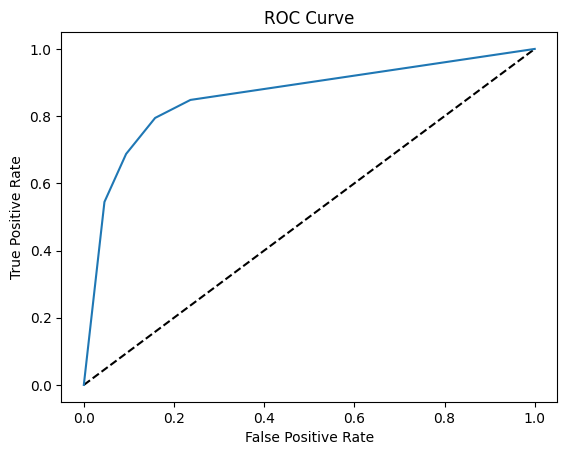

0.8596760797342193
[[1169  121]
 [  70  154]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1290
           1       0.56      0.69      0.62       224

    accuracy                           0.87      1514
   macro avg       0.75      0.80      0.77      1514
weighted avg       0.89      0.87      0.88      1514



In [258]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_after_pca_cl)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, knn.predict_proba(X_test_after_pca_cl)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test, knn.predict(X_test_after_pca_cl)))

# Calculate the classification report
print(classification_report(y_test, knn.predict(X_test_after_pca_cl)))

### SHAP

In [107]:
knn = KNeighborsClassifier(n_neighbors=4, algorithm="auto", weights="distance")

In [108]:
knn.fit(X_train_after_pca_smote,y_train_smote)

KNeighborsClassifier(n_neighbors=4, weights='distance')

PermutationExplainer explainer: 1515it [09:56,  2.51it/s]                          


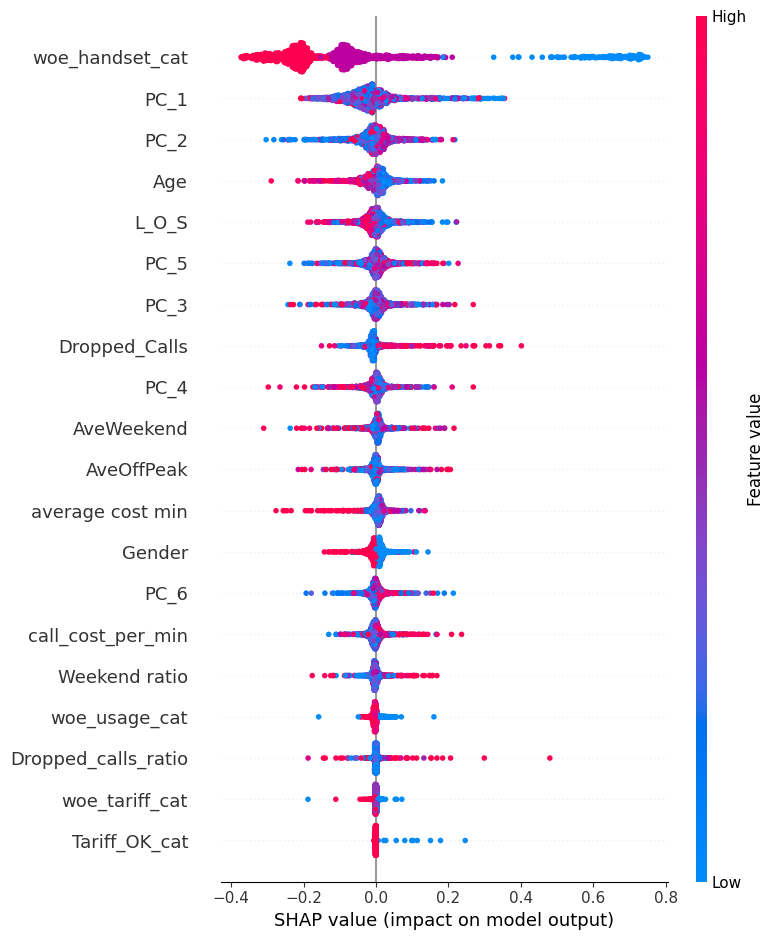

In [109]:
explainer = shap.Explainer(knn.predict,X_test_after_pca_cl)
shap_values = explainer(X_test_after_pca_cl)

shap.summary_plot(shap_values)

In [110]:
mean_shap_values = np.abs(shap_values.values).mean(axis=0)
mean_shap_values

array([0.01435781, 0.02624475, 0.02557133, 0.020266  , 0.01489132,
       0.01712411, 0.005532  , 0.01353879, 0.01484088, 0.00958659,
       0.00072535, 0.00167948, 0.00031764, 0.20711361, 0.00240513,
       0.00617149, 0.05576828, 0.03307794, 0.0240771 , 0.0197406 ,
       0.02480936, 0.0135571 ])

In [111]:
shap_dict = dict(zip(X_train_after_pca_cl.columns.values, mean_shap_values))
sorted_dict = dict(sorted(shap_dict.items(), key=lambda item: item[1], reverse=True))
sorted_dict

{'woe_handset_cat': 0.20711360634081905,
 'PC_1': 0.05576828389576081,
 'PC_2': 0.03307793923381771,
 'Age': 0.02624474600696527,
 'L_O_S': 0.025571334214002643,
 'PC_5': 0.024809355109883465,
 'PC_3': 0.02407709859493209,
 'Dropped_Calls': 0.020266002161642878,
 'PC_4': 0.01974060285817217,
 'AveWeekend': 0.0171241143268884,
 'AveOffPeak': 0.014891317401224895,
 'average cost min': 0.014840879068091702,
 'Gender': 0.014357811937072142,
 'PC_6': 0.01355710339858291,
 'call_cost_per_min': 0.013538789480004783,
 'Weekend ratio': 0.009586585805211916,
 'woe_usage_cat': 0.006171490332652798,
 'Dropped_calls_ratio': 0.00553200432328566,
 'woe_tariff_cat': 0.002405127897201902,
 'Tariff_OK_cat': 0.0016794764020655881,
 'High_Dropped_calls': 0.0007253512669628922,
 'above_11_dropped_calls': 0.0003176414074696759}

In [112]:
X_train_shap = X_train_after_pca_smote.reindex(columns=sorted_dict.keys())

X_test_shap = X_test_after_pca_cl.reindex(columns=sorted_dict.keys())

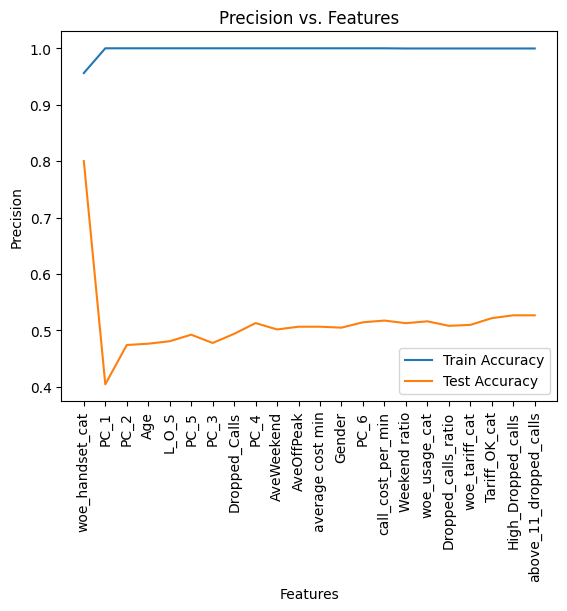

In [113]:
# Initialize lists to store error rates and number of features
train_errors = []
test_errors = []
num_features = []

# Store feature names
feature_names = X_train_shap.columns.tolist()

# Fit the model with increasing number of features
for i in range(1, X_train_shap.shape[1] + 1):
    knn.fit(X_train_shap.iloc[:, :i], y_train_smote)  # Fit the model with the first i features
    
    # Predictions
    y_train_pred = knn.predict(X_train_shap.iloc[:, :i])
    y_test_pred = knn.predict(X_test_shap.iloc[:, :i])
    
    # Calculate error rates
    train_error = precision_score(y_train_smote, y_train_pred)
    test_error = precision_score(y_test, y_test_pred)
    
    # Append to lists
    train_errors.append(train_error)
    test_errors.append(test_error)
    num_features.append(i)

# Plot the error rates
plt.plot(feature_names, train_errors, label='Train Accuracy')
plt.plot(feature_names, test_errors, label='Test Accuracy')
plt.xlabel('Features')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.ylabel('Precision')
plt.title('Precision vs. Features')
plt.legend()
plt.show()

In [114]:
mask_shap = mean_shap_values > 0.07

In [115]:
shap_subset_train = X_train_after_pca_smote.loc[:,mask_shap]
shap_subset_test = X_test_after_pca_cl.loc[:,mask_shap]

In [116]:
knn.fit(shap_subset_train,y_train_smote)

KNeighborsClassifier(n_neighbors=4, weights='distance')

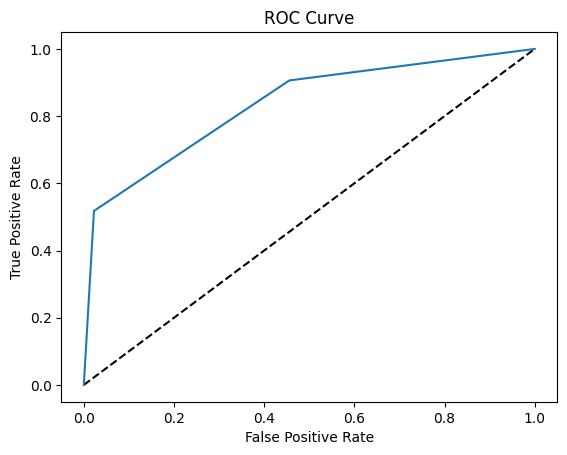

0.8330547480620154
[[1261   29]
 [ 108  116]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1290
           1       0.80      0.52      0.63       224

    accuracy                           0.91      1514
   macro avg       0.86      0.75      0.79      1514
weighted avg       0.90      0.91      0.90      1514



In [117]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(shap_subset_test)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, knn.predict_proba(shap_subset_test)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  knn.predict(shap_subset_test)))

# Calculate the classification report
print(classification_report(y_test,  knn.predict(shap_subset_test)))

In [119]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': knn.predict(X_test_after_pca_prof.loc[:,shap_subset_test.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_knn_shap.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
 	# 9th 3.817858 0.728699

### K-Best

In [84]:
# Specify L2 regularization
#liblinear is the optimization method used to estimate the coefficients. liblinear is need for l1

knn = KNeighborsClassifier()

pipeline = Pipeline(
    [
     ('selector',SelectKBest(f_regression)),
     ('model', knn),

    ]
)

param_grid = {
    "model__weights" : ["uniform","distance"],
    "model__n_neighbors" : [3,4,5,6,7,8],
    "model__algorithm" : ["auto"],
    'selector__k' : [1,2,3,4,5,6]

}

kf = KFold(n_splits=5, shuffle=True, random_state=5)

# Instantiate the GridSearchCV object and run the search
# The GridSeachCV object, when fitted on the data, creates 5-fold splits for every C value and calculates a default scoring metric
searcher_knn = GridSearchCV(pipeline, param_grid, cv=kf, scoring="precision")
searcher_knn.fit(X_train_after_pca_smote, y_train_smote)

GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=Pipeline(steps=[('selector',
                                        SelectKBest(score_func=<function f_regression at 0x0000021CB28224D0>)),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['auto'],
                         'model__n_neighbors': [3, 4, 5, 6, 7, 8],
                         'model__weights': ['uniform', 'distance'],
                         'selector__k': [1, 2, 3, 4, 5, 6]},
             scoring='precision')

In [85]:
searcher_knn.best_params_

{'model__algorithm': 'auto',
 'model__n_neighbors': 4,
 'model__weights': 'distance',
 'selector__k': 5}

In [86]:
# Get the best pipeline
best_pipeline = searcher_knn.best_estimator_

# Extract the best feature selector from the pipeline
best_selector = best_pipeline.named_steps['selector']

In [155]:
mask_knn_k = best_selector.get_support()
mask_knn_k

array([False, False, False,  True, False, False, False, False, False,
       False,  True, False,  True,  True, False,  True, False, False,
       False, False, False, False])

In [156]:
# Get the indices of the selected features
selected_indices = best_selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train_after_pca_smote.columns[selected_indices]
selected_feature_names

Index(['Dropped_Calls', 'High_Dropped_calls', 'above_11_dropped_calls',
       'woe_handset_cat', 'woe_usage_cat'],
      dtype='object')

In [157]:
reduced_train_k_best = X_train_after_pca_smote.loc[:,mask_knn_k]
reduced_test_k_best = X_test_after_pca_cl.loc[:,mask_knn_k]

In [91]:
knn_k_best = KNeighborsClassifier(n_neighbors=4,algorithm="auto",weights="distance")
knn_k_best.fit(reduced_train_k_best,y_train_smote)

KNeighborsClassifier(n_neighbors=4, weights='distance')

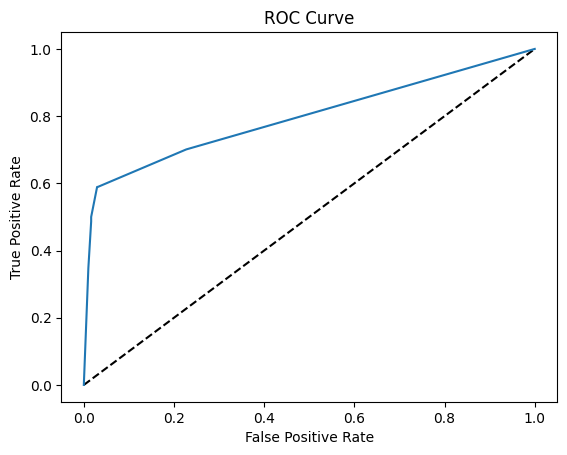

0.7962347729789591
[[1269   21]
 [ 112  112]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1290
           1       0.84      0.50      0.63       224

    accuracy                           0.91      1514
   macro avg       0.88      0.74      0.79      1514
weighted avg       0.91      0.91      0.90      1514



In [92]:
 #Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, knn_k_best.predict_proba(reduced_test_k_best)[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate roc_auc_score
print(roc_auc_score(y_test, knn_k_best.predict_proba(reduced_test_k_best)[:,1]))

# Calculate the confusion matrix
print(confusion_matrix(y_test,  knn_k_best.predict(reduced_test_k_best)))

# Calculate the classification report
print(classification_report(y_test,  knn_k_best.predict(reduced_test_k_best)))

In [106]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': knn_k_best.predict(X_test_after_pca_prof.loc[:,reduced_test_k_best.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_knn_k_best.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
 # 9th	3.852983 0.703369

# ENSEMBLE (Random Forest, Logistic, KNN) using VotingClassifier

### RandomSearchCV 

In [168]:
random_ens = RandomForestClassifier(bootstrap=True,random_state=8)
lr_ens = LogisticRegression(random_state=8)
knn_ens = KNeighborsClassifier()


classifiers = [('lr', lr_ens), ('rf', random_ens), ('knn', knn_ens)]

vc = VotingClassifier(estimators=classifiers, voting="hard", n_jobs=-1) 

kf = KFold(n_splits=5, shuffle=True, random_state=5)

params = {
    'lr__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'rf__n_estimators' : [50,70,100,120,150],
    'rf__criterion': ['gini','entropy'],
    'rf__max_features' : [1,2,"log2","sqrt"],
    'knn__weights' : ["uniform","distance"],
    "knn__n_neighbors" : [3,4,5,6]
}

vc_searcher = RandomizedSearchCV(vc, params, cv=kf, scoring="precision", n_jobs=-1, random_state=11)

vc_searcher.fit(X_train_after_pca_smote, y_train_smote)  

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=VotingClassifier(estimators=[('lr',
                                                           LogisticRegression(random_state=8)),
                                                          ('rf',
                                                           RandomForestClassifier(random_state=8)),
                                                          ('knn',
                                                           KNeighborsClassifier())],
                                              n_jobs=-1),
                   n_jobs=-1,
                   param_distributions={'knn__n_neighbors': [3, 4, 5, 6],
                                        'knn__weights': ['uniform', 'distance'],
                                        'lr__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                  1000],
                                        'rf__criterion': ['gini', 'entropy'],
                                        'rf__max_features': [1, 2, 'log2',
                                                             'sqrt'],
                                        'rf__n_estimators': [50, 70, 100, 120,
                                                             150]},
                   random_state=11, scoring='precision')

In [169]:
vc_searcher.best_params_

{'rf__n_estimators': 120,
 'rf__max_features': 2,
 'rf__criterion': 'gini',
 'lr__C': 1,
 'knn__weights': 'uniform',
 'knn__n_neighbors': 4}

In [175]:
random_ens = RandomForestClassifier(bootstrap=True,random_state=8, n_estimators=120, max_features=2,criterion="gini", max_leaf_nodes=15)
lr_ens = LogisticRegression(random_state=8,C=1)
knn_ens = KNeighborsClassifier(weights="uniform", n_neighbors=4)

classifiers = [('lr', lr_ens), ('rf', random_ens), ('knn', knn_ens)]

vc = VotingClassifier(estimators=classifiers, voting="hard", n_jobs=-1) 

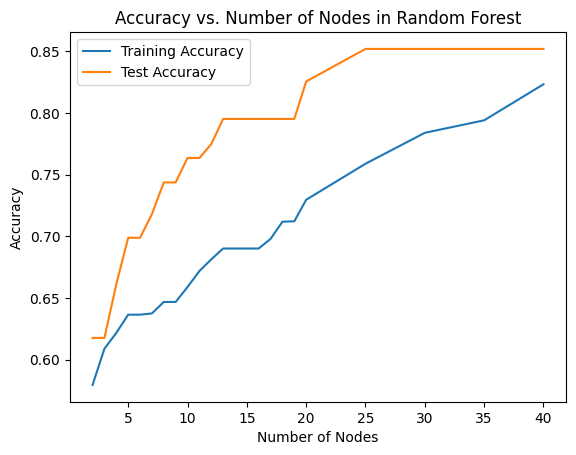

In [204]:
# Define a range of values for the number of nodes
node_values = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40]  # Adjust this range as needed

# Initialize lists to store accuracy values
train_accuracies = []
test_accuracies = []

# Train Random Forest models with different numbers of nodes
for num_nodes in node_values:
    # Create and fit Random Forest model
    rf_model = RandomForestClassifier(bootstrap=True,random_state=8, n_estimators=70, max_features=2,criterion="entropy",max_leaf_nodes=num_nodes)
    rf_model.fit(reduced_train_ens, y_train_smote)

    #RandomForestClassifier(bootstrap=True, max_features="log2", random_state=45, class_weight="balanced")
    # Predict on training and test data
    train_preds = rf_model.predict(reduced_train_ens)
    test_preds = rf_model.predict(reduced_test_ens)
    
    # Calculate accuracy and append to lists
    train_accuracy = accuracy_score(y_train_smote, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(node_values, train_accuracies, label='Training Accuracy')
plt.plot(node_values, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Nodes in Random Forest')
plt.legend()
plt.show()

In [176]:
vc.fit(X_train_after_pca_smote,y_train_smote)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, random_state=8)),
                             ('rf',
                              RandomForestClassifier(max_features=2,
                                                     max_leaf_nodes=15,
                                                     n_estimators=120,
                                                     random_state=8)),
                             ('knn', KNeighborsClassifier(n_neighbors=4))],
                 n_jobs=-1)

In [180]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': vc.predict(X_test_after_pca_prof.drop(["Connect_Date","id"], axis=1))}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_ens.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

### Step Forward

In [183]:
random_ens = RandomForestClassifier(bootstrap=True,random_state=8)
lr_ens = LogisticRegression(random_state=8)
knn_ens = KNeighborsClassifier()



classifiers = [('lr', lr_ens), ('rf', random_ens), ('knn', knn_ens)]

vc = VotingClassifier(estimators=classifiers, voting="hard", n_jobs=-1) 

pipeline = Pipeline(
    [
     ('selector',SequentialFeatureSelector(vc,cv=kf,scoring="precision")),
     ('model',vc)
    ]
)


kf = KFold(n_splits=5, shuffle=True, random_state=5)

params = {
    'selector__n_features_to_select' : [1,2,3,4,5,6,7,8],
    'model__lr__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'model__rf__n_estimators' : [50,70,100,120,150],
    'model__rf__criterion': ['gini','entropy'],
    'model__rf__max_features' : [1,2,"log2","sqrt"],
    'model__knn__weights' : ["uniform","distance"],
    "model__knn__n_neighbors" : [3,4,5,6]
}

vc_searcher = RandomizedSearchCV(pipeline, params, cv=kf, scoring="precision", n_jobs=-1, random_state=11)

vc_searcher.fit(X_train_after_pca_smote, y_train_smote)  

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=Pipeline(steps=[('selector',
                                              SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                                                                        estimator=VotingClassifier(estimators=[('lr',
                                                                                                                LogisticRegression(random_state=8)),
                                                                                                               ('rf',
                                                                                                                RandomForestClassifier(random_state=8)),
                                                                                                               ('knn',
                                                                                                                KNeighborsClassifier())],
                                                                                                   n_jobs=-1)...
                   param_distributions={'model__knn__n_neighbors': [3, 4, 5, 6],
                                        'model__knn__weights': ['uniform',
                                                                'distance'],
                                        'model__lr__C': [0.001, 0.01, 0.1, 1,
                                                         10, 100, 1000],
                                        'model__rf__criterion': ['gini',
                                                                 'entropy'],
                                        'model__rf__max_features': [1, 2,
                                                                    'log2',
                                                                    'sqrt'],
                                        'model__rf__n_estimators': [50, 70, 100,
                                                                    120, 150],
                                        'selector__n_features_to_select': [1, 2,
                                                                           3, 4,
                                                                           5, 6,
                                                                           7,
                                                                           8]},
                   random_state=11, scoring='precision')

In [184]:
vc_searcher.best_params_

{'selector__n_features_to_select': 1,
 'model__rf__n_estimators': 100,
 'model__rf__max_features': 'log2',
 'model__rf__criterion': 'gini',
 'model__lr__C': 0.001,
 'model__knn__weights': 'distance',
 'model__knn__n_neighbors': 6}

In [189]:
# Get the best estimator
best_estimator = vc_searcher.best_estimator_

# Access the selector step of the pipeline
selector = best_estimator.named_steps['selector']

# Get the selected features
selected_features = selector.support_

selected_features


array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [190]:
# Get the names of the selected features
selected_feature_names = X_train_after_pca_smote.columns[selected_features]

In [191]:
reduced_train_ens = X_train_after_pca_smote[selected_feature_names]
reduced_test_ens = X_test_after_pca_cl[selected_feature_names]
reduced_train_ens.head()

Age
0 -1.522189
1 -0.820099
2  1.286170
3  0.350050
4 -0.586069

In [193]:
random_ens = RandomForestClassifier(bootstrap=True,random_state=8, n_estimators=100, max_features="log2",criterion="gini",max_leaf_nodes=15)
lr_ens = LogisticRegression(random_state=8,C=0.001)
knn_ens = KNeighborsClassifier(weights="distance", n_neighbors=6)

classifiers = [('lr', lr_ens), ('rf', random_ens), ('knn', knn_ens)]

vc = VotingClassifier(estimators=classifiers, voting="hard", n_jobs=-1) 

vc.fit(reduced_train_ens,y_train_smote)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.001, random_state=8)),
                             ('rf',
                              RandomForestClassifier(max_features='log2',
                                                     max_leaf_nodes=15,
                                                     random_state=8)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=6,
                                                   weights='distance'))],
                 n_jobs=-1)

In [194]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': vc.predict(X_test_after_pca_prof.loc[:,reduced_test_ens.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_ens_step.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

### K-BEST

In [195]:
random_ens = RandomForestClassifier(bootstrap=True,random_state=8)
lr_ens = LogisticRegression(random_state=8)
knn_ens = KNeighborsClassifier()



classifiers = [('lr', lr_ens), ('rf', random_ens), ('knn', knn_ens)]

vc = VotingClassifier(estimators=classifiers, voting="hard", n_jobs=-1) 

pipeline = Pipeline(
    [
     ('selector',SelectKBest(f_regression)),
     ('model',vc)
    ]
)


kf = KFold(n_splits=5, shuffle=True, random_state=5)

params = {
    'selector__k' : [1,2,3,4,5,6],
    'model__lr__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'model__rf__n_estimators' : [50,70,100,120,150],
    'model__rf__criterion': ['gini','entropy'],
    'model__rf__max_features' : [1,2,"log2","sqrt"],
    'model__knn__weights' : ["uniform","distance"],
    "model__knn__n_neighbors" : [3,4,5,6]
}

vc_searcher = RandomizedSearchCV(pipeline, params, cv=kf, scoring="precision", n_jobs=-1, random_state=11)

vc_searcher.fit(X_train_after_pca_smote, y_train_smote)  

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=Pipeline(steps=[('selector',
                                              SelectKBest(score_func=<function f_regression at 0x0000021CB28224D0>)),
                                             ('model',
                                              VotingClassifier(estimators=[('lr',
                                                                            LogisticRegression(random_state=8)),
                                                                           ('rf',
                                                                            RandomForestClassifier(random_state=8)),
                                                                           ('knn',
                                                                            KNeighborsClassifier())],
                                                               n_jobs=-1))]),
                   n_jobs=-1,
                   param_distributions={'model__knn__n_neighbors': [3, 4, 5, 6],
                                        'model__knn__weights': ['uniform',
                                                                'distance'],
                                        'model__lr__C': [0.001, 0.01, 0.1, 1,
                                                         10, 100, 1000],
                                        'model__rf__criterion': ['gini',
                                                                 'entropy'],
                                        'model__rf__max_features': [1, 2,
                                                                    'log2',
                                                                    'sqrt'],
                                        'model__rf__n_estimators': [50, 70, 100,
                                                                    120, 150],
                                        'selector__k': [1, 2, 3, 4, 5, 6]},
                   random_state=11, scoring='precision')

In [196]:
vc_searcher.best_params_

{'selector__k': 5,
 'model__rf__n_estimators': 70,
 'model__rf__max_features': 2,
 'model__rf__criterion': 'entropy',
 'model__lr__C': 0.001,
 'model__knn__weights': 'distance',
 'model__knn__n_neighbors': 4}

In [198]:

# Access the selector step of the pipeline
mask_ens_k_best = vc_searcher.best_estimator_.named_steps['selector'].get_support()
mask_ens_k_best


array([False, False, False,  True, False, False, False, False, False,
       False,  True, False,  True,  True, False,  True, False, False,
       False, False, False, False])

In [200]:
reduced_X_train_ens_k_best = X_train_after_pca_smote.loc[:,mask_ens_k_best]
reduced_X_test_ens_k_best = X_test_after_pca_cl.loc[:,mask_ens_k_best]


In [205]:
random_ens = RandomForestClassifier(bootstrap=True,random_state=8, n_estimators=70, max_features=2,criterion="entropy",max_leaf_nodes=25)
lr_ens = LogisticRegression(random_state=8,C=0.001)
knn_ens = KNeighborsClassifier(weights="distance", n_neighbors=4)

classifiers = [('lr', lr_ens), ('rf', random_ens), ('knn', knn_ens)]

vc = VotingClassifier(estimators=classifiers, voting="hard", n_jobs=-1) 

vc.fit(reduced_X_train_ens_k_best,y_train_smote)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.001, random_state=8)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features=2,
                                                     max_leaf_nodes=25,
                                                     n_estimators=70,
                                                     random_state=8)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance'))],
                 n_jobs=-1)

In [206]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': vc.predict(X_test_after_pca_prof.loc[:,reduced_X_test_ens_k_best.columns])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_ens_k_best.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)

In [ ]:
 # 8th:	3.936732 0.75039

# Adapt Professors Test set

In [94]:
test_set_prof = pd.read_csv(r"C:\KU Leuven\Advanced Analytics\Assignment\data\test.csv")

In [95]:
test_set_prof.head()

Gender   Age Connect_Date      L_O_S  Dropped_Calls    tariff  Handset  \
0      F  20.0     23/05/96  55.582251            3.0   CAT 200     WC95   
1      F  54.0     01/03/98  32.067010            0.0  Play 300    BS110   
2      F  28.0     11/10/98  26.621954            0.0   CAT 200  ASAD170   
3      F  26.0     12/08/98  27.652735            5.0   CAT 200     WC95   
4      F  34.0     28/10/98  25.479355            0.0   CAT 100     WC95   

   Peak_calls_Sum  Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  \
0           513.0    1075.667903              110.0        189.982227   
1            13.0     378.078657               93.0        551.817423   
2          1000.0    2064.343139               90.0        152.731006   
3           122.0     999.111887              126.0        358.760706   
4           164.0     742.647381               73.0        141.180280   

   Weekend_calls_Sum  Weekend_mins_Sum  International_mins_Sum  \
0                8.0          5.017969               25.872662   
1                8.0         17.593417              138.267040   
2               10.0         23.907633              492.202970   
3                0.0          3.024655              174.998124   
4               11.0         47.034972               80.927142   

   Nat_call_cost_Sum    AvePeak  AveOffPeak  AveWeekend  National_calls  \
0          10.766282   9.598648    0.128126    2.044552           609.0   
1           0.570547  33.547208    3.963993    5.503624            87.0   
2          91.460036   2.945673    4.322230    2.370283          1020.0   
3          11.509839  11.984087   -1.064854    9.663168           241.0   
4          27.402638   8.875573    4.853664    3.021928           281.0   

   National mins  AveNational  All_calls_mins  Dropped_calls_ratio Usage_Band  \
0    1397.818565     2.414391     1382.461509             0.002272    MedHigh   
1    1009.005349    11.445797     1085.179552             0.001823        Med   
2    2205.502075     2.415233     2695.044238             0.002011       High   
3    1324.338426     5.814761     1524.022052             0.011887    MedHigh   
4     794.535641     3.952980      887.649410             0.000796        Med   

   Mins_charge  call_cost_per_min  actual call cost  Total_call_cost  \
0   120.133757           8.933287          9.409262         9.195247   
1  -709.894563          11.931697          2.739423        56.143013   
2  1005.776446           9.560903         95.406158       248.197508   
3   124.587195           8.398145         14.464628        55.896596   
4   214.172528          12.766109         34.757126        62.593087   

   Total_Cost Tariff_OK  average cost min  Peak ratio  OffPeak ratio  \
0  167.242853        OK          0.116924    0.824189       0.173365   
1  136.404621        OK          0.120457    0.415020       0.532898   
2  397.739114        OK          0.149435    0.960100       0.034434   
3  196.789012        OK          0.137372    0.745483       0.263256   
4  160.450386        OK          0.180704    0.771754       0.166995   

   Weekend ratio  Nat-InterNat Ratio high Dropped calls No Usage       id  
0       0.009823            0.020349                  F        F  K751808  
1       0.022391            0.124480                  F        F  K837351  
2       0.006660            0.225763                  F        F  K548114  
3       0.005870            0.108872                  F        F  K736156  
4       0.056390            0.090896                  F        F  K508080

In [96]:
test_set_prof['Dropped_calls_ratio'].fillna(X_train['Dropped_calls_ratio'].median(), inplace=True)
test_set_prof['Usage_Band'].fillna(X_train['Usage_Band'].mode().iloc[0], inplace=True)  # mode() returns a Series, so you need to access the first element with iloc[0]
test_set_prof['call_cost_per_min'].fillna(X_train['call_cost_per_min'].median(), inplace=True)

C:\Users\Johnn\AppData\Local\Temp\ipykernel_21708\1947359765.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_set_prof['Dropped_calls_ratio'].fillna(X_train['Dropped_calls_ratio'].median(), inplace=True)
C:\Users\Johnn\AppData\Local\Temp\ipykernel_21708\1947359765.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


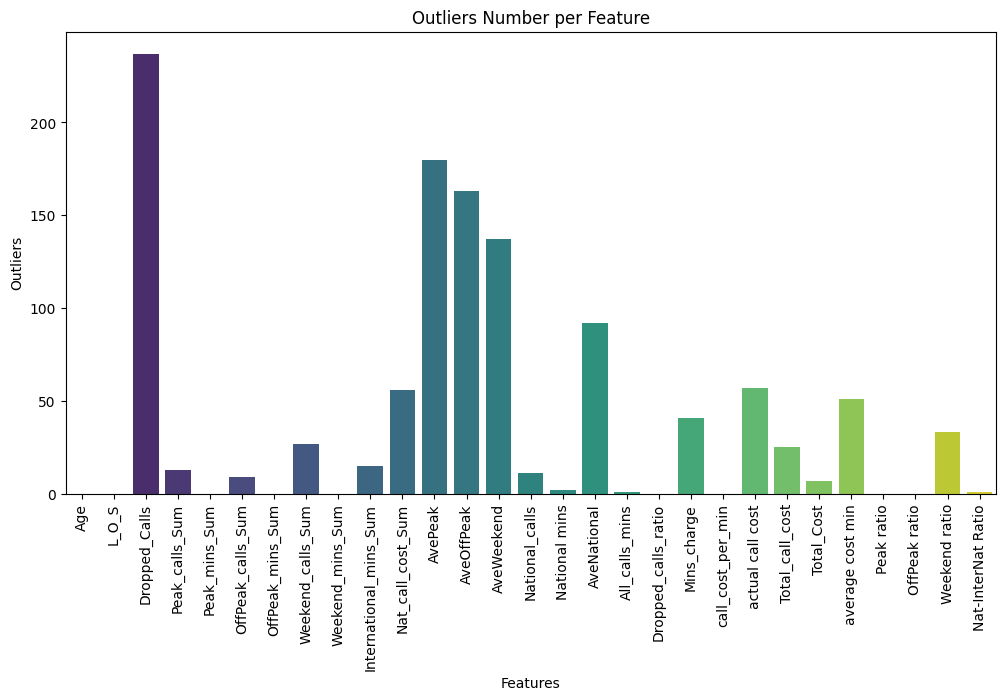

In [97]:
def robust_outlier_detection_test(dataset, columns):
    outliers = {}
    for feature_name in columns:
       median = np.median(X_train[feature_name])
       q75, q25 = np.percentile(X_train[feature_name], [75 ,25])
       iqr = q75-q25
       robust_z = (dataset[feature_name] - median) / iqr
       mask = abs(robust_z) > 3 
       outliers[feature_name] = sum(mask)
    return outliers

def truncate_outliers_test(dataset,columns):
    for feature_name in columns:
       median = np.median(X_train[feature_name])
       q75, q25 = np.percentile(X_train[feature_name], [75 ,25])
       iqr = q75-q25
       k = 3*iqr + median
       dataset[feature_name] = np.where((abs((dataset[feature_name]  - median) / iqr)) > 3, k, dataset[feature_name] )

filtered_columns_test = test_set_prof.select_dtypes(include=["int","float"]).columns

#filtered_columns_test = filtered_columns_test.drop('target')

outlier_dict_test = robust_outlier_detection_test(test_set_prof,filtered_columns_test)

keys = list(outlier_dict_test.keys())
values = list(outlier_dict_test.values())

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=keys, y=values, palette='viridis')
plt.xlabel('Features')
plt.ylabel('Outliers')
plt.title('Outliers Number per Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

c:\KU Leuven\Advanced Analytics\Assignment\.venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


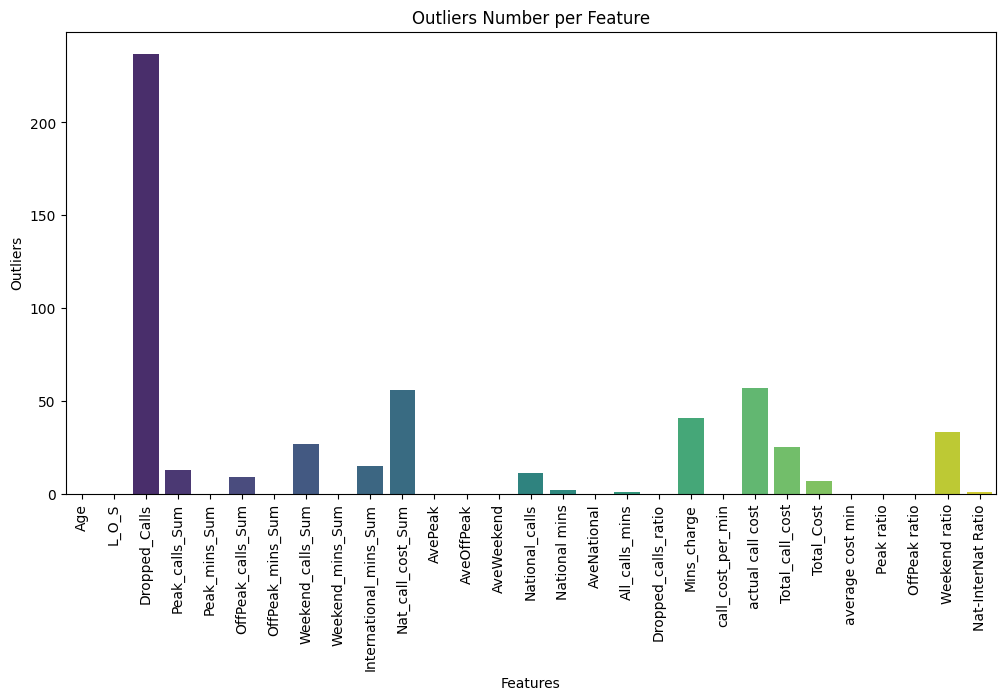

In [98]:
filtered_columns_trunct_test = list(filtered_columns_test)
#filtered_columns_trunct_test
filtered_columns_trunct_test = filtered_columns_trunct_test[11:14]  + [filtered_columns_trunct_test[16]] + [filtered_columns_trunct_test[24]] 

truncate_outliers_test(test_set_prof,filtered_columns_trunct_test)

outlier_dict_test_2 = robust_outlier_detection_test(test_set_prof, filtered_columns_test)

keys = list(outlier_dict_test_2.keys())
values = list(outlier_dict_test_2.values())

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=keys, y=values, palette='viridis')
plt.xlabel('Features')
plt.ylabel('Outliers')
plt.title('Outliers Number per Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [99]:
# Binarize the High Dropped calls feature 


from sklearn.preprocessing import LabelEncoder
# Set up the LabelEncoder object
enc = LabelEncoder()

# Apply the encoding to the "Accessible" column
test_set_prof["High_Dropped_calls"] = enc.fit_transform(test_set_prof["high Dropped calls"])

# Compare the two columns
#print(train[["High_Dropped_calls", "high Dropped calls"]].head())

test_set_prof.drop("high Dropped calls", axis=1, inplace=True)

# The variables connect_month, connect_year, No Usage, Tariff_OK, and Gender are DROPPED from the training set

test_set_prof.drop("No Usage", axis=1, inplace=True)

enc_2 = LabelEncoder()

# Apply the encoding to the "Accessible" column
test_set_prof["Gender"] = enc_2.fit_transform(test_set_prof["Gender"])

   # Create a list of categories
tariff_OK_categories = ["OK", "Other"]

# Create short_flights
okay = "OK"

other = "CAT|Play"
# Create long_flights
#handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (test_set_prof["Tariff_OK"].str.contains(okay)),
    (test_set_prof["Tariff_OK"].str.contains(other))
]

# Apply the conditions list to the flight_categories
test_set_prof["Tariff_OK_cat"] = np.select(conditions, 
                                        tariff_OK_categories)


test_set_prof["Tariff_OK_cat"] = np.where(test_set_prof["Tariff_OK_cat"]=="OK", 1,0)

test_set_prof["Connect_Date"] = pd.to_datetime(test_set_prof["Connect_Date"])

# Create salary labels
drop_calls_labels = ["0-11", "12-15"]

# Create the salary ranges list
drop_calls_ranges = [-0.1, 12, train["Dropped_Calls"].max()]

# Create salary_level
test_set_prof["binned_drop_calls"] = pd.cut(test_set_prof["Dropped_Calls"],
                                  bins=drop_calls_ranges,
                                  labels=drop_calls_labels)

test_set_prof["above_11_dropped_calls"] = np.where(test_set_prof["binned_drop_calls"]=="12-15",1,0)

test_set_prof.drop("binned_drop_calls",axis=1,inplace=True)

C:\Users\Johnn\AppData\Local\Temp\ipykernel_21708\117484850.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_set_prof["Connect_Date"] = pd.to_datetime(test_set_prof["Connect_Date"])


In [100]:
 # Create a list of categories
handset_categories = ["Handset_safe", "Handset_neutral", "Handset_risky"]

# Create short_flights
handset_safe = "BS210|S80|ASAD170|WC95|CAS60"

# Create medium_flights
handset_neutral = "S50|BS110"

# Create long_flights
handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (test_set_prof["Handset"].str.contains(handset_safe)),
    (test_set_prof["Handset"].str.contains(handset_neutral)),
    (test_set_prof["Handset"].str.contains(handset_risky))
]

# Apply the conditions list to the flight_categories
test_set_prof["Handset_Category"] = np.select(conditions, 
                                        handset_categories)


handset_to_woe_dict = dict(zip(handset_cat_woe['Bin Values'], handset_cat_woe['WoE']))
test_set_prof['woe_handset_cat'] = test_set_prof['Handset_Category'].map(handset_to_woe_dict)

   # Create a list of categories
tariff_categories = ["tariff_play_300", "tariff_CAT", "tariff_play_100"]

# Create short_flights
tariff_less_risky = "Play 300"

tariff_neutral = "CAT 200|CAT 50|CAT 100"

# Create medium_flights
tariff_risky = "Play 100"

# Create long_flights
#handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (test_set_prof["tariff"].str.contains(tariff_less_risky)),
    (test_set_prof["tariff"].str.contains(tariff_neutral)),
    (test_set_prof["tariff"].str.contains(tariff_risky))
]

# Apply the conditions list to the flight_categories
test_set_prof["Tariff_category"] = np.select(conditions, 
                                        tariff_categories)

tariff_to_woe_dict = dict(zip(tariff_cat_woe['Bin Values'], tariff_cat_woe['WoE']))
test_set_prof['woe_tariff_cat'] = test_set_prof['Tariff_category'].map(tariff_to_woe_dict)

   # Create a list of categories
usage_categories = ["usage_low", "usage_med", "usage_high"]

# Create short_flights
usage_low = "Low"

usage_med = r"\bMed\b"

usage_high = "High"




# Create long_flights
#handset_risky = "SOP10|ASAD90|CAS30|SOP20"

# Create conditions for values in flight_categories to be created
conditions = [
    (test_set_prof["Usage_Band"].str.contains(usage_low)),
    (test_set_prof["Usage_Band"].str.contains(usage_med)),
    (test_set_prof["Usage_Band"].str.contains(usage_high))
]

# Apply the conditions list to the flight_categories
test_set_prof["Usage_category"] = np.select(conditions, 
                                        usage_categories)

usage_to_woe_dict = dict(zip(usage_cat_woe['Bin Values'], usage_cat_woe['WoE']))
test_set_prof['woe_usage_cat'] = test_set_prof['Usage_category'].map(usage_to_woe_dict)

test_set_prof.drop(["tariff","Handset","Usage_Band","Tariff_OK","Handset_Category","Tariff_category","Usage_category"],axis=1,inplace=True)

In [101]:
test_set_prof.head()

Gender   Age Connect_Date      L_O_S  Dropped_Calls  Peak_calls_Sum  \
0       0  20.0   1996-05-23  55.582251            3.0           513.0   
1       0  54.0   1998-01-03  32.067010            0.0            13.0   
2       0  28.0   1998-11-10  26.621954            0.0          1000.0   
3       0  26.0   1998-12-08  27.652735            5.0           122.0   
4       0  34.0   1998-10-28  25.479355            0.0           164.0   

   Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
0    1075.667903              110.0        189.982227                8.0   
1     378.078657               93.0        551.817423                8.0   
2    2064.343139               90.0        152.731006               10.0   
3     999.111887              126.0        358.760706                0.0   
4     742.647381               73.0        141.180280               11.0   

   Weekend_mins_Sum  International_mins_Sum  Nat_call_cost_Sum    AvePeak  \
0          5.017969               25.872662          10.766282   9.598648   
1         17.593417              138.267040           0.570547  14.632444   
2         23.907633              492.202970          91.460036   2.945673   
3          3.024655              174.998124          11.509839  11.984087   
4         47.034972               80.927142          27.402638   8.875573   

   AveOffPeak  AveWeekend  National_calls  National mins  AveNational  \
0    0.128126    2.044552           609.0    1397.818565     2.414391   
1    3.963993    5.503624            87.0    1009.005349     9.838100   
2    4.322230    2.370283          1020.0    2205.502075     2.415233   
3   -1.064854    9.663168           241.0    1324.338426     5.814761   
4    4.853664    3.021928           281.0     794.535641     3.952980   

   All_calls_mins  Dropped_calls_ratio  Mins_charge  call_cost_per_min  \
0     1382.461509             0.002272   120.133757           8.933287   
1     1085.179552             0.001823  -709.894563          11.931697   
2     2695.044238             0.002011  1005.776446           9.560903   
3     1524.022052             0.011887   124.587195           8.398145   
4      887.649410             0.000796   214.172528          12.766109   

   actual call cost  Total_call_cost  Total_Cost  average cost min  \
0          9.409262         9.195247  167.242853          0.116924   
1          2.739423        56.143013  136.404621          0.120457   
2         95.406158       248.197508  397.739114          0.149435   
3         14.464628        55.896596  196.789012          0.137372   
4         34.757126        62.593087  160.450386          0.180704   

   Peak ratio  OffPeak ratio  Weekend ratio  Nat-InterNat Ratio       id  \
0    0.824189       0.173365       0.009823            0.020349  K751808   
1    0.415020       0.532898       0.022391            0.124480  K837351   
2    0.960100       0.034434       0.006660            0.225763  K548114   
3    0.745483       0.263256       0.005870            0.108872  K736156   
4    0.771754       0.166995       0.056390            0.090896  K508080   

   High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  woe_handset_cat  \
0                   0              1                       0         2.114110   
1                   0              1                       0         0.108214   
2                   0              1                       0         2.114110   
3                   0              1                       0         2.114110   
4                   0              1                       0         2.114110   

   woe_tariff_cat  woe_usage_cat  
0        0.027035       0.008955  
1        0.602513       0.289711  
2        0.027035       0.008955  
3        0.027035       0.008955  
4        0.027035       0.289711

In [102]:
test_set_prof[cols_to_scale] = scaler.transform(test_set_prof[cols_to_scale])

X_test_pca_prof = test_set_prof[['National mins', 'OffPeak_calls_Sum', 'OffPeak ratio', 'National_calls', 
                        'Total_Cost', 'Peak_mins_Sum', 'All_calls_mins', 'Mins_charge', 'OffPeak_mins_Sum', 'Nat_call_cost_Sum', 
                        'Peak ratio', 'Weekend_calls_Sum', 'Total_call_cost', 'actual call cost', 'AveNational', 'International_mins_Sum', 
                        'AvePeak', 'Peak_calls_Sum', 'Nat-InterNat Ratio', 'Weekend_mins_Sum']]

pc_test_prof = pca.transform(X_test_pca_prof)

pc_test_df_prof = pd.DataFrame(pc_test_prof)

pca_X_test_6_prof = pc_test_df_prof.iloc[:,0:6]

pca_X_test_6_prof.columns = ["PC_1","PC_2","PC_3","PC_4","PC_5","PC_6"]

X_test_after_pca_prof =test_set_prof.drop(['National mins', 'OffPeak_calls_Sum', 'OffPeak ratio', 'National_calls', 
                                   'Total_Cost', 'Peak_mins_Sum', 'All_calls_mins', 'Mins_charge', 'OffPeak_mins_Sum', 
                                   'Nat_call_cost_Sum', 'Peak ratio', 'Weekend_calls_Sum', 'Total_call_cost', 'actual call cost', 
                                   'AveNational', 'International_mins_Sum', 'AvePeak', 'Peak_calls_Sum', 'Nat-InterNat Ratio', 'Weekend_mins_Sum'],axis=1)

X_test_after_pca_prof.reset_index(drop=True,inplace=True)


X_test_after_pca_prof = pd.merge(X_test_after_pca_prof, pca_X_test_6_prof, left_index=True, right_index=True, how='outer')

In [103]:
X_test_after_pca_prof.head()

Gender       Age Connect_Date     L_O_S  Dropped_Calls  AveOffPeak  \
0       0 -0.898109   1996-05-23  1.553128       0.090661   -1.137856   
1       0  1.754230   1998-01-03 -0.118661      -0.775072   -0.205864   
2       0 -0.274029   1998-11-10 -0.505771      -0.775072   -0.118825   
3       0 -0.430049   1998-12-08 -0.432488       0.667816   -1.427711   
4       0  0.194030   1998-10-28 -0.587002      -0.775072    0.010297   

   AveWeekend  Dropped_calls_ratio  call_cost_per_min  average cost min  \
0   -0.600682            -0.257320          -0.541570         -1.056529   
1    0.342246            -0.279870           0.876645         -0.973110   
2   -0.511889            -0.270432          -0.244715         -0.288902   
3    1.476119             0.225373          -0.794686         -0.573725   
4   -0.334254            -0.331427           1.271312          0.449401   

   Weekend ratio       id  High_Dropped_calls  Tariff_OK_cat  \
0      -0.792161  K751808                   0              1   
1      -0.600529  K837351                   0              1   
2      -0.840389  K548114                   0              1   
3      -0.852435  K736156                   0              1   
4      -0.082125  K508080                   0              1   

   above_11_dropped_calls  woe_handset_cat  woe_tariff_cat  woe_usage_cat  \
0                       0         2.114110        0.027035       0.008955   
1                       0         0.108214        0.602513       0.289711   
2                       0         2.114110        0.027035       0.008955   
3                       0         2.114110        0.027035       0.008955   
4                       0         2.114110        0.027035       0.289711   

       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  
0  0.449811 -1.482964 -1.303595 -1.376256 -1.298376 -1.505133  
1 -2.466915  0.573637  3.260319 -1.095476 -1.411924 -1.056539  
2  8.448497 -0.601817 -0.482954 -0.633793  1.154763  0.550977  
3  0.140628 -0.754745  1.641253 -1.672451 -0.930592 -1.149469  
4 -0.290571 -1.783890  0.202722 -0.236885 -0.741753  0.304278

In [104]:
sum(X_test_after_pca_prof["id"].values == test_set_prof["id"].values)

1682

In [130]:
test_set_prof.head()

Gender       Age Connect_Date     L_O_S  Dropped_Calls  Peak_calls_Sum  \
0       0 -0.898109   1996-05-23  1.553128       0.090661        1.098718   
1       0  1.754230   1998-01-03 -0.118661      -0.775072       -0.932705   
2       0 -0.274029   1998-11-10 -0.505771      -0.775072        3.077324   
3       0 -0.430049   1998-12-08 -0.432488       0.667816       -0.489855   
4       0  0.194030   1998-10-28 -0.587002      -0.775072       -0.319215   

   Peak_mins_Sum  OffPeak_calls_Sum  OffPeak_mins_Sum  Weekend_calls_Sum  \
0       0.719522           0.057411         -0.617264          -0.515314   
1      -0.651268          -0.115925          1.192921          -0.515314   
2       2.662306          -0.146513         -0.803624          -0.394562   
3       0.569086           0.220550          0.227099          -0.998319   
4       0.065124          -0.319849         -0.861410          -0.334187   

   Weekend_mins_Sum  International_mins_Sum  Nat_call_cost_Sum   AvePeak  \
0         -1.234265               -1.013068          -0.305185  1.170085   
1         -0.887943               -0.222488          -0.662460  2.396198   
2         -0.714052                2.267092           2.522455 -0.450420   
3         -1.289160                0.035878          -0.279129  1.751121   
4         -0.077136               -0.625816           0.277780  0.993962   

   AveOffPeak  AveWeekend  National_calls  National mins  AveNational  \
0   -1.137856   -0.600682        0.919851       0.592397    -0.613709   
1   -0.205864    0.342246       -1.035795      -0.116076     2.739000   
2   -0.118825   -0.511889        2.459641       2.064112    -0.613328   
3   -1.427711    1.476119       -0.458842       0.458506     0.921973   
4    0.010297   -0.334254       -0.308984      -0.506870     0.081152   

   All_calls_mins  Dropped_calls_ratio  Mins_charge  call_cost_per_min  \
0        0.218161            -0.257320     0.108339          -0.541570   
1       -0.245569            -0.279870    -1.611133           0.876645   
2        2.265658            -0.270432     1.943021          -0.244715   
3        0.438981             0.225373     0.117565          -0.794686   
4       -0.553696            -0.331427     0.303149           1.271312   

   actual call cost  Total_call_cost  Total_Cost  average cost min  \
0         -0.348520        -1.069215   -0.237003         -1.056529   
1         -0.582429        -0.293215   -0.609514         -0.973110   
2          2.667365         2.881254    2.547279         -0.288902   
3         -0.171230        -0.297288    0.119900         -0.573725   
4          0.540422        -0.186602   -0.319053          0.449401   

   Peak ratio  OffPeak ratio  Weekend ratio  Nat-InterNat Ratio       id  \
0    0.958770      -0.739893      -0.792161           -1.332741  K751808   
1   -0.859562       0.970087      -0.600529           -0.355934  K837351   
2    1.562754      -1.400665      -0.840389            0.594158  K548114   
3    0.609004      -0.312361      -0.852435           -0.502345  K736156   
4    0.725751      -0.770190      -0.082125           -0.670970  K508080   

   High_Dropped_calls  Tariff_OK_cat  above_11_dropped_calls  woe_handset_cat  \
0                   0              1                       0         2.114110   
1                   0              1                       0         0.108214   
2                   0              1                       0         2.114110   
3                   0              1                       0         2.114110   
4                   0              1                       0         2.114110   

   woe_tariff_cat  woe_usage_cat  
0        0.027035       0.008955  
1        0.602513       0.289711  
2        0.027035       0.008955  
3        0.027035       0.008955  
4        0.027035       0.289711

In [207]:
test_set_prof.shape

(1682, 38)

In [105]:
X_test_after_pca_prof.head()

Gender       Age Connect_Date     L_O_S  Dropped_Calls  AveOffPeak  \
0       0 -0.898109   1996-05-23  1.553128       0.090661   -1.137856   
1       0  1.754230   1998-01-03 -0.118661      -0.775072   -0.205864   
2       0 -0.274029   1998-11-10 -0.505771      -0.775072   -0.118825   
3       0 -0.430049   1998-12-08 -0.432488       0.667816   -1.427711   
4       0  0.194030   1998-10-28 -0.587002      -0.775072    0.010297   

   AveWeekend  Dropped_calls_ratio  call_cost_per_min  average cost min  \
0   -0.600682            -0.257320          -0.541570         -1.056529   
1    0.342246            -0.279870           0.876645         -0.973110   
2   -0.511889            -0.270432          -0.244715         -0.288902   
3    1.476119             0.225373          -0.794686         -0.573725   
4   -0.334254            -0.331427           1.271312          0.449401   

   Weekend ratio       id  High_Dropped_calls  Tariff_OK_cat  \
0      -0.792161  K751808                   0              1   
1      -0.600529  K837351                   0              1   
2      -0.840389  K548114                   0              1   
3      -0.852435  K736156                   0              1   
4      -0.082125  K508080                   0              1   

   above_11_dropped_calls  woe_handset_cat  woe_tariff_cat  woe_usage_cat  \
0                       0         2.114110        0.027035       0.008955   
1                       0         0.108214        0.602513       0.289711   
2                       0         2.114110        0.027035       0.008955   
3                       0         2.114110        0.027035       0.008955   
4                       0         2.114110        0.027035       0.289711   

       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  
0  0.449811 -1.482964 -1.303595 -1.376256 -1.298376 -1.505133  
1 -2.466915  0.573637  3.260319 -1.095476 -1.411924 -1.056539  
2  8.448497 -0.601817 -0.482954 -0.633793  1.154763  0.550977  
3  0.140628 -0.754745  1.641253 -1.672451 -0.930592 -1.149469  
4 -0.290571 -1.783890  0.202722 -0.236885 -0.741753  0.304278

In [209]:
X_test_after_pca["id"]

0       K117540
1       K276210
2       K316950
3       K311260
4       K246870
         ...   
1509    K377090
1510    K138560
1511    K145760
1512    K192540
1513    K201200
Name: id, Length: 1514, dtype: object

In [369]:
data = {'ID': X_test_after_pca_prof["id"], 'PRED': random_f_best.predict(X_test_after_pca_prof[["woe_handset_cat"]])}

# Create DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
file_path = 'C:\KU Leuven\Advanced Analytics\Assignment\predictions_14.csv'  # Specify the file path where you want to save the CSV file
df.to_csv(file_path, index=False)